<a href="https://colab.research.google.com/github/AndrzejOlejniczak/AndrzejOlejniczak/blob/main/_WAPW_Information_Retrieval_Paper_PART_ONE_bool_search_experiments_2025_04_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Retrieval Paper
### PART ONE: Boolean query experiments

## 0. Prepare working environment

### 0.1. Install libraries

#### 0.1.1. Research repository access libraries

In [1]:
!pip install pybliometrics
!pip install arxiv
!pip install scholarly
!pip install acl-anthology
!pip install semanticscholar

In [3]:
!pip install python-dotenv

### 0.2. Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0.3. Import libraries

In [4]:
# Import standard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import system libraries and Python native libraries
import os
import shutil
import dotenv
import warnings

import math

from collections import OrderedDict

from datetime import datetime
import time

import re
from itertools import product

In [5]:
import requests
import pybliometrics
from pybliometrics.scopus import ScopusSearch
import arxiv
from scholarly import scholarly
from acl_anthology import Anthology
from semanticscholar import SemanticScholar

In [6]:
sns.set_theme(style="darkgrid", palette="deep")
sns.set_context("paper")

### 0.4. Define main variables

In [7]:
SEED = 44
DATA_PATH = '/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER'
DATA_PATH_sem_sch = os.path.join(DATA_PATH, 'SEM_SCH_SCRAPING')
DATA_PATH_lda_models = os.path.join(DATA_PATH, "LDA_MODELS")
DATA_PATH_similarity_exp = os.path.join(DATA_PATH, "SIMILARITY_EXPERIMENTS")
DATA_Pathj_bool_queries = os.path.join(DATA_PATH, "BOOLEAN_QUERIES")

In [8]:
# Get the number of CPU cores
CPU_COUNT = os.cpu_count()
print(f"Number of CPU cores available: {CPU_COUNT}")

Number of CPU cores available: 2


In [9]:
pybliometrics.scopus.init()

Creating config file at /root/.config/pybliometrics.cfg with default paths...
Please enter your API Key(s), obtained from http://dev.elsevier.com/myapikey.html.  Separate multiple keys by comma:
f3e51b6ba511d68ca9e711dcbcbe3111
API Keys are sufficient for most users.  If you have an InstToken, please enter the tokens pair now. Separate multiple tokens by a comma. The correspondig key's position should match the position of the token.If you don't have tokens, just press Enter:

Configuration file successfully created at /root/.config/pybliometrics.cfg
For details see https://pybliometrics.rtfd.io/en/stable/configuration.html.


In [10]:
# Initialize Pybliometrics configuration
pybliometrics.scopus.utils.create_config()

AttributeError: module 'pybliometrics.scopus' has no attribute 'utils'

In [11]:
CWD = os.getcwd()

In [12]:
os.listdir(CWD)

['.config', 'drive', 'sample_data']

In [13]:
'''
# Load the API key from .env
dotenv.load_dotenv(dotenv_path=".env.txt")
os.environ["PYBLIOMETRICS_API_KEY"] = os.getenv("ELSEVIER_API_KEY")
'''

'\n# Load the API key from .env\ndotenv.load_dotenv(dotenv_path=".env.txt")\nos.environ["PYBLIOMETRICS_API_KEY"] = os.getenv("ELSEVIER_API_KEY")\n'

In [14]:
# Set general Seaborn style
sns.set_theme(style="whitegrid")  # Ensures the grid and clean aesthetics
sns.set_context("paper")

# Update Matplotlib rcParams for consistent styling
plt.rcParams.update({
    "axes.titlesize": 14,  # Title size
    "axes.titleweight": "normal",  # Title weight
    "axes.labelsize": 12,  # Label size
    "axes.grid": True,  # Enable grid
    "grid.linestyle": "--",  # Dashed grid lines
    "grid.alpha": 0.7,  # Subtle transparency for grid
    "xtick.labelsize": 11,  # X-axis tick labels
    "ytick.labelsize": 11,  # Y-axis tick labels
    "xtick.direction": "out",  # Tick direction
    "ytick.direction": "out",
    "figure.figsize": (10, 5),  # Default figure size
    "legend.fontsize": 11,  # Legend font size
    "font.family": "sans-serif",  # Use a modern sans-serif font
    "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica"],  # Preferred fonts
    "axes.edgecolor": "black",  # Darker axes for better contrast
    "axes.spines.top": False,  # Remove top border
    "axes.spines.right": False,  # Remove right border
})

# Optional: Set Seaborn color palette
sns.set_palette("muted")  # More subtle, professional color scheme

# Now, all plots will follow this elegant styling!

### 0.5. Define helper functions

#### 0.5.1. Utility functions

In [15]:
def replace_with_nan(value):
    if (isinstance(value, str) and len(value) <= 4) or value=='None' or (isinstance(value, list) and len(value) == 0):
        return np.nan
    return value

In [16]:
def save_df_with_timestamp(df: pd.DataFrame, partial_filename: str, data_path=None) -> str:
    # Generate the timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Construct the full filename
    filename = f"{partial_filename}_{timestamp}.csv"

    if data_path:
        filename_with_datapath = os.path.join(data_path, filename)
    else:
        filename_with_datapath = filename

    # Save the DataFrame to CSV
    df.to_csv(filename_with_datapath, index=False)

    return filename_with_datapath

In [17]:
def read_newest_timestamped_csv(partial_name: str, folder_path: str, **kwargs) -> pd.DataFrame:
    """
    Finds the newest CSV file in the specified folder that starts with <partial_name>
    and has a timestamp of the form YYYYMMDD_HHMMSS somewhere before the .csv extension,
    then returns it as a DataFrame. Additional keyword arguments can be passed to
    pd.read_csv() using **kwargs.

    Example filename:
        expanded_paper_dabase_20241227_122326.csv

    Parameters
    ----------
    partial_name : str
        The first part of the filename (e.g., "expanded_paper_dabase").
    folder_path : str
        The path to the folder where the files are located.
    **kwargs : dict
        Additional keyword arguments to pass to pd.read_csv().

    Returns
    -------
    pd.DataFrame
        The DataFrame corresponding to the newest CSV file found.

    Raises
    ------
    FileNotFoundError
        If no matching CSV files are found in the folder.
    """

    newest_file = None
    newest_timestamp = None
    print(f'Checking for files that start with {partial_name}\n')
    # List all items in the folder
    for filename in os.listdir(folder_path):
        # Check if the file starts with partial_name
        if filename.startswith(partial_name):
            base_name = filename[:-4]
            print(base_name)
            timestamp_str = base_name[-15:]

            # Attempt to parse the timestamp
            try:
                dt_obj = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
                print(dt_obj)
            except ValueError:
                # If we can't parse it, skip this file
                continue

            # Update newest_file if this one is more recent
            if newest_timestamp is None or dt_obj > newest_timestamp:
                newest_timestamp = dt_obj
                newest_file = filename

    if newest_file is None:
        raise FileNotFoundError(
            f"No file found that starts with '{partial_name}' "
        )

    # Construct the full path to the newest file
    full_path = os.path.join(folder_path, newest_file)

    # Read CSV into a DataFrame, passing any additional keyword arguments to pd.read_csv()
    return pd.read_csv(full_path, **kwargs)

#### 0.5.2. Respository search functions

**COMMENTARY:**

In the table below, there are repositories of choice for our queries.

| Repository            | Library/API          | Access Level      | Features                                  |
|-----------------------|----------------------|-------------------|-------------------------------------------|
| **Elsevier**          | `pybliometrics`      | Subscription      | Comprehensive metadata, bibliometrics.   |
| **Semantic Scholar**  | `semanticscholar`    | Free              | Focused on citations and semantic search. |
| **arXiv**             | `arxiv`              | Free              | Preprints in computational linguistics.   |
| **Google Scholar**    | `scholarly` (unofficial) | Free            | Broadest coverage but unofficial.        |
| **ACL Anthology**     | `acl-anthology` (unofficial wrappers or web scraping) | Free | Specialized in computational linguistics research. |

In [18]:
def query_elsevier(boolean_query):
    try:
        search = ScopusSearch(boolean_query, view="STANDARD")
        return search.results
    except Exception as e:
        print(f"Error querying Elsevier: {e}")
        return None

In [20]:
'''
def query_elsevier_paginated(boolean_query, max_results=100, **kwargs):
    results = []
    start = 0
    count = 25  # Maximum results per page

    try:
        while len(results) < max_results:
            search = ScopusSearch(
                boolean_query,
                start=start,
                count=count,
                cursor=None,
                view="STANDARD",
                sort="relevancy",
                **kwargs  # Pass additional filters (e.g., date, subj, etc.)
            )

            if not search.results:
                break  # Stop if no more results are returned

            results.extend(search.results)
            start += count  # Move to the next page

            if len(results) >= max_results:  # Stop if we've hit the requested max
                return results[:max_results]

    except Exception as e:
        print(f"Error querying Elsevier: {e}")

    return results[:max_results]  # Return limited results
'''


'\ndef query_elsevier_paginated(boolean_query, max_results=100, **kwargs):\n    results = []\n    start = 0\n    count = 25  # Maximum results per page\n\n    try:\n        while len(results) < max_results:\n            search = ScopusSearch(\n                boolean_query,\n                start=start,\n                count=count,\n                cursor=None,\n                view="STANDARD",\n                sort="relevancy",\n                **kwargs  # Pass additional filters (e.g., date, subj, etc.)\n            )\n\n            if not search.results:\n                break  # Stop if no more results are returned\n\n            results.extend(search.results)\n            start += count  # Move to the next page\n\n            if len(results) >= max_results:  # Stop if we\'ve hit the requested max\n                return results[:max_results]\n\n    except Exception as e:\n        print(f"Error querying Elsevier: {e}")\n\n    return results[:max_results]  # Return limited results\

In [21]:
def query_elsevier_paginated(boolean_query, max_results=100, **kwargs):
    results = []
    try:
        # Enable cursor-based pagination
        search = ScopusSearch(
            boolean_query,
            cursor=False,  # Enable Scopus' cursor-based pagination
            view="STANDARD",
            sort="relevancy",
            **kwargs  # Pass additional filters (e.g., date, subj, etc.)
        )

        for result in search.results:
            results.append(result)
            if len(results) >= max_results:  # Stop if max results reached
                break

        return results[:max_results]  # Return only max_results

    except Exception as e:
        print(f"Error querying Elsevier: {e}")
        return None


In [22]:
def query_semantic_scholar(boolean_query, limit=200):
    try:
        # Initialize the Semantic Scholar client
        sch = SemanticScholar()

        # Perform the search
        results = sch.search_paper(boolean_query, limit=limit)  # Adjust limit as needed

        # Extract relevant details
        papers = []
        for i, paper in enumerate(results):
            if i >= limit:
                break
            else:
                papers.append({
                    "paper_id": paper['paperId'],
                    "title": paper['title'],
                    "authors": [author['name'] for author in paper['authors']],
                    "abstract": paper['abstract'],
                    "year": paper['year'],
                    "url": paper['url'],

                })
                try:
                    papers[-1]['doi'] = paper['externalIds']['DOI']

                except Exception as e:
                    print(f"Error extracting DOI: {e}")
                    papers[-1]['doi'] = None
                finally:
                    continue
        return papers
    except Exception as e:
        print(f"Error querying Semantic Scholar: {e}")
        return None

In [23]:
def query_semantic_scholar_paginated(boolean_query, limit=200):
    try:
        # Initialize the Semantic Scholar client
        sch = SemanticScholar()

        # Prepare for pagination
        papers = []
        batch_size = 100  # API limit per request
        offset = 0

        while len(papers) < limit:
            # Adjust the batch size for the last request if necessary
            current_batch_size = min(batch_size, limit - len(papers))

            # Perform the search with offset and batch size
            results = sch.search_paper(boolean_query, limit=current_batch_size, offset=offset)

            # Stop if no more results are returned
            if not results:
                break

            # Extract relevant details from the current batch
            for paper in results:

                papers.append({
                    "title": paper['title'],
                    "authors": [author['name'] for author in paper['authors']],
                    "abstract": paper.get('abstract', 'No abstract available'),
                    "year": paper['year'],
                    "url": paper['url'],
                })

            # Update offset for the next batch
            offset += current_batch_size

        return papers
    except Exception as e:
        print(f"Error querying Semantic Scholar: {e}")
        return None

In [24]:
def fetch_abstract_from_semantic_scholar(doi):
    try:
        # Initialize the Semantic Scholar API client
        sch = SemanticScholar()

        # Fetch paper details using the DOI
        paper = sch.get_paper(doi, fields=["title", "abstract", "url"])

        # Extract relevant information
        return {
            "title": paper["title"],
            "abstract": paper["abstract"],
            "url": paper["url"],
        }
    except Exception as e:
        print(f"Error fetching abstract for DOI {doi}: {e}")
        return None

In [25]:
def query_arxiv(boolean_query):
    try:
        client = arxiv.Client()

        search = arxiv.Search(
            query=boolean_query,
            max_results=100,
            sort_by=arxiv.SortCriterion.Relevance,
            sort_order=arxiv.SortOrder.Descending
        )
        results = client.results(search)
        list_of_papers = []
        for result in results:
            list_of_papers.append(
                {
                    'entry_id': result.entry_id,
                    'title': result.title,
                    'authors': [author.name for author in result.authors],
                    'summary': result.summary,
                    'published': result.published,
                    'updated': result.updated,
                    'categories': result.categories,
                    'primary_category': result.primary_category,
                    'comment': result.comment,
                    'doi': result.doi,
                    'pdf_url': result.pdf_url,
                }
            )
        return list_of_papers
    except Exception as e:
        print(f"Error querying arXiv: {e}")
        return None


In [26]:
def query_google_scholar(boolean_query, limit=100):
    try:
        search = scholarly.search_pubs(
            boolean_query,
            patents=False,
            sort_by='relevance',
        )

        results = []
        try:
            for i, result in enumerate(search):
                # Flatten the JSON-like structure
                if i == 0:
                    print(result)
                flattened_result = {
                    "title": result.get("bib", {}).get("title", "No title available"),
                    "author": ", ".join(result.get("bib", {}).get("author", [])),
                    "pub_year": result.get("bib", {}).get("pub_year", "No publication year available"),
                    "venue": result.get("bib", {}).get("venue", "No venue available"),
                    "abstract": result.get("bib", {}).get("abstract", "No abstract available"),
                    "gsrank": result.get("gsrank", "No rank available"),
                    "pub_url": result.get("pub_url", "No publication URL available"),
                    "num_citations": result.get("num_citations", "No citation count available"),
                    "citedby_url": result.get("citedby_url", "No cited-by URL available"),
                    "related_articles_url": result.get("url_related_articles", "No related articles URL available"),
                    'eprint_url': result.get("eprint_url", "No eprint URL available"),
                }
                results.append(flattened_result)

                if i >= limit - 1:
                    break
        except Exception as e:
            print(f"Error during search: {e}")

        print(f"Fetched {len(results)} results.")
        return results

    except Exception as e:
        print(f"Error querying Google Scholar: {e}")
        return None


In [27]:
def query_acl_anthology(boolean_query):
    try:
        base_url = "https://aclanthology.org/search/"
        params = {"q": boolean_query}
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        results = []
        for result in soup.find_all("p", class_="card-title"):
            title = result.text.strip()
            link = result.find("a")["href"]
            results.append({"title": title, "link": link})
        return results
    except Exception as e:
        print(f"Error querying ACL Anthology: {e}")
        return None


In [28]:
def query_acl_anthology(boolean_query):
    try:
        anthology = Anthology()
        # Search the anthology for the given Boolean query
        # The library supports simple keyword searches, but you may need to parse and customize the Boolean query logic manually
        results = anthology.search(boolean_query)
        return [{"title": entry.title, "authors": [author.full_name for author in entry.authors], "year": entry.year, "url": entry.url} for entry in results]
    except Exception as e:
        print(f"Error querying ACL Anthology: {e}")
        return None


#### 0.5.3. Metric functions

In [29]:
def precision(gt_dict, **kwargs):
    judged = [(doc, rel) for doc, rel in gt_dict.items() if rel is not None]
    relevant = [doc for doc, rel in judged if rel is True]
    return len(relevant) / len(judged) if judged else 0

def precision_at_k(gt_dict, k=10, **kwargs):
    top_k = list(gt_dict.items())[:k]
    relevant_at_k = sum(1 for doc, rel in top_k if rel is True)
    return relevant_at_k / k

def ndcg_at_k(gt_dict, k=10, **kwargs):
    top_k = list(gt_dict.items())[:k]
    dcg = sum((2**int(rel) - 1) / math.log2(i + 2) for i, (doc, rel) in enumerate(top_k) if rel is not None)
    ideal_rels = sorted([1 if v is True else 0 for v in gt_dict.values() if v is not None], reverse=True)[:k]
    idcg = sum((2**rel - 1) / math.log2(i + 2) for i, rel in enumerate(ideal_rels))
    return dcg / idcg if idcg > 0 else 0

def mrr(gt_dict, **kwargs):
    for idx, (doc, rel) in enumerate(gt_dict.items(), start=1):
        if rel is True:
            return 1 / idx
    return 0

def map_score(gt_dict, **kwargs):
    num_relevant = 0
    sum_precisions = 0
    for idx, (doc, rel) in enumerate(gt_dict.items(), start=1):
        if rel is True:
            num_relevant += 1
            sum_precisions += num_relevant / idx
    return sum_precisions / num_relevant if num_relevant else 0

def bpref(gt_dict, **kwargs):
    judged_relevant = [doc for doc, rel in gt_dict.items() if rel is True]
    judged_irrelevant = [doc for doc, rel in gt_dict.items() if rel is False]
    if not judged_relevant or not judged_irrelevant:
        return 0
    bpref_sum = 0
    for rel_doc in judged_relevant:
        rel_index = list(gt_dict.keys()).index(rel_doc)
        num_irrel_before = sum(1 for irr_doc in judged_irrelevant if list(gt_dict.keys()).index(irr_doc) < rel_index)
        bpref_sum += 1 - (num_irrel_before / len(judged_irrelevant))
    return bpref_sum / len(judged_relevant)

def rank_eff(gt_dict, **kwargs):
    judged_relevant = [doc for doc, rel in gt_dict.items() if rel is True]
    judged_irrelevant = [doc for doc, rel in gt_dict.items() if rel is False]
    r = len(judged_relevant)
    n = r + len(judged_irrelevant)
    if r == 0 or n == r:
        return 0
    keys = list(gt_dict.keys())
    score_sum = 0
    for rel_doc in judged_relevant:
        rel_idx = keys.index(rel_doc)
        num_irrel_below = sum(1 for irr_doc in judged_irrelevant if keys.index(irr_doc) > rel_idx)
        score_sum += num_irrel_below
    return score_sum / (r * (n - r))


In [30]:
def compute_ir_metrics(gt_dict, experiment_name="experiment", k=10, **kwargs):
    return {
        "experiment": experiment_name,
        "precision": precision(gt_dict, **kwargs),
        f"precision@{k}": precision_at_k(gt_dict, k=k, **kwargs),
        f"nDCG@{k}": ndcg_at_k(gt_dict, k=k, **kwargs),
        "MRR": mrr(gt_dict, **kwargs),
        "MAP": map_score(gt_dict, **kwargs),
        "bpref": bpref(gt_dict, **kwargs),
        "rank_eff": rank_eff(gt_dict, **kwargs)
    }


In [66]:
def plot_ir_metrics_radar(metrics_dict, title=None):
    # Filter out the 'experiment' key
    metric_names = [k for k in metrics_dict if k != "experiment"]
    values = [metrics_dict[k] for k in metric_names]

    # Close the loop: add the first value to the end
    values.append(values[0])
    angles = np.linspace(0, 2 * np.pi, len(metric_names), endpoint=False).tolist()
    angles.append(angles[0])  # close the loop

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color='slategrey', linewidth=1.25, linestyle='solid')
    ax.fill(angles, values, color='slategrey', alpha=0.25)

    # Configure axes
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels=[])
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10)
    ax.yaxis.grid(True, linestyle='dotted')

    # Use custom label placement instead:
    for angle, label in zip(angles[:-1], metric_names):
        x = np.cos(angle) * 1.1
        y = np.sin(angle) * 1.1
        ha = 'center'
        if angle == 0 or angle == np.pi:
            ha = 'center'
        elif 0 < angle < np.pi:
            ha = 'left'
        else:
            ha = 'right'
        ax.text(angle, 1.05, label, size=10, horizontalalignment=ha, verticalalignment='center')

    # Title
    if title:
        ax.set_title(title, size=16, pad=30)

    plt.tight_layout()
    plt.show()

    return fig


## 1. Boolean query search

In [32]:
bool_query_1 = 'NLP and ML and "architectural design" and BIM'

In [33]:
bool_query_2 = 'architecture AND NLP AND ML'

In [34]:
bool_query_3 = 'architecture AND participation AND (NLP OR "machine learning")'

In [35]:
bool_query_4 = 'architecture AND theory AND "natural language processing"'

### 1.1. Scopus database

#### 1.1.1. Scopus - data retrieval

##### 1.1.1.1. Query 1

In [ ]:
elsevier_results_1 = query_elsevier_paginated(bool_query_1, max_results=100)

In [ ]:
elsevier_results_1_df = pd.DataFrame(elsevier_results_1)
elsevier_results_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   eid                  16 non-null     object
 1   doi                  16 non-null     object
 2   pii                  7 non-null      object
 3   pubmed_id            0 non-null      object
 4   title                16 non-null     object
 5   subtype              16 non-null     object
 6   subtypeDescription   16 non-null     object
 7   creator              16 non-null     object
 8   afid                 0 non-null      object
 9   affilname            16 non-null     object
 10  affiliation_city     16 non-null     object
 11  affiliation_country  16 non-null     object
 12  author_count         0 non-null      object
 13  author_names         0 non-null      object
 14  author_ids           0 non-null      object
 15  author_afids         0 non-null      object
 16  coverDate 

##### 1.1.1.2. Query 2

In [ ]:
elsevier_results_2 = query_elsevier_paginated(bool_query_2, max_results=100)

In [ ]:
elsevier_results_2_df = pd.DataFrame(elsevier_results_2)
elsevier_results_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   eid                  100 non-null    object
 1   doi                  98 non-null     object
 2   pii                  34 non-null     object
 3   pubmed_id            3 non-null      object
 4   title                100 non-null    object
 5   subtype              100 non-null    object
 6   subtypeDescription   100 non-null    object
 7   creator              100 non-null    object
 8   afid                 0 non-null      object
 9   affilname            100 non-null    object
 10  affiliation_city     100 non-null    object
 11  affiliation_country  100 non-null    object
 12  author_count         0 non-null      object
 13  author_names         0 non-null      object
 14  author_ids           0 non-null      object
 15  author_afids         0 non-null      object
 16  coverDate

In [ ]:
elsevier_results_2_refined = query_elsevier_paginated(bool_query_2_refined, max_results=100)

In [ ]:
elsevier_results_2_df_refined = pd.DataFrame(elsevier_results_2)
elsevier_results_2_df_refined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   eid                  100 non-null    object
 1   doi                  98 non-null     object
 2   pii                  34 non-null     object
 3   pubmed_id            3 non-null      object
 4   title                100 non-null    object
 5   subtype              100 non-null    object
 6   subtypeDescription   100 non-null    object
 7   creator              100 non-null    object
 8   afid                 0 non-null      object
 9   affilname            100 non-null    object
 10  affiliation_city     100 non-null    object
 11  affiliation_country  100 non-null    object
 12  author_count         0 non-null      object
 13  author_names         0 non-null      object
 14  author_ids           0 non-null      object
 15  author_afids         0 non-null      object
 16  coverDate

In [ ]:
elsevier_results_2_df_refined.title.values

array(['AI-driven fusion with cybersecurity: Exploring current trends, advanced techniques, future directions, and policy implications for evolving paradigms– A comprehensive review',
       'Advances in natural language processing for healthcare: A comprehensive review of techniques, applications, and future directions',
       'Exploring the ability of emerging large language models to detect cyberbullying in social posts through new prompt-based classification approaches',
       'Artificial intelligence interventions in 2D MXenes-based photocatalytic applications',
       'Deep learning-assisted methods for accelerating the intelligent screening of novel 2D materials: New perspectives focusing on data collection and description',
       'A machine learning-based two-stage integrated framework for cost reasonableness prediction of green building projects',
       'A novel uncertainty-aware liquid neural network for noise-resilient time series forecasting and classification',
       

In [ ]:
bool_query_2_refined = "KEY(architecture) AND TITLE-ABS-KEY(nlp) AND TITLE-ABS-KEY(ml)"

##### 1.1.1.3. Query 3

In [ ]:
elsevier_results_3 = query_elsevier_paginated(
    bool_query_3,
    max_results=100,
    date='2023-2024'
    )

In [ ]:
elsevier_results_3_df = pd.DataFrame(elsevier_results_3)
elsevier_results_3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   eid                  100 non-null    object
 1   doi                  99 non-null     object
 2   pii                  22 non-null     object
 3   pubmed_id            19 non-null     object
 4   title                100 non-null    object
 5   subtype              100 non-null    object
 6   subtypeDescription   100 non-null    object
 7   creator              100 non-null    object
 8   afid                 0 non-null      object
 9   affilname            98 non-null     object
 10  affiliation_city     98 non-null     object
 11  affiliation_country  98 non-null     object
 12  author_count         0 non-null      object
 13  author_names         0 non-null      object
 14  author_ids           0 non-null      object
 15  author_afids         0 non-null      object
 16  coverDate

##### 1.1.1.4. Query 4

In [ ]:
elsevier_results_4 = query_elsevier_paginated(
    bool_query_4,
    max_results=100,
    date="2024",
    )

In [ ]:
elsevier_results_4_df = pd.DataFrame(elsevier_results_4)
elsevier_results_4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   eid                  100 non-null    object
 1   doi                  100 non-null    object
 2   pii                  22 non-null     object
 3   pubmed_id            17 non-null     object
 4   title                100 non-null    object
 5   subtype              100 non-null    object
 6   subtypeDescription   100 non-null    object
 7   creator              100 non-null    object
 8   afid                 0 non-null      object
 9   affilname            99 non-null     object
 10  affiliation_city     99 non-null     object
 11  affiliation_country  99 non-null     object
 12  author_count         0 non-null      object
 13  author_names         0 non-null      object
 14  author_ids           0 non-null      object
 15  author_afids         0 non-null      object
 16  coverDate

#### 1.1.2. Save / load data

###### **SAVE RETRIEVED DATA**

In [ ]:
save_df_with_timestamp(
    df=elsevier_results_1_df, partial_filename='scopus_100_query_1', data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/scopus_100_query_1_20250202_122826.csv'

In [ ]:
save_df_with_timestamp(
    df=elsevier_results_2_df, partial_filename='scopus_100_query_2', data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/scopus_100_query_2_20250202_122827.csv'

In [ ]:
save_df_with_timestamp(
    df=elsevier_results_3_df, partial_filename='scopus_100_query_3', data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/scopus_100_query_3_20250202_122828.csv'

In [ ]:
save_df_with_timestamp(
    df=elsevier_results_4_df, partial_filename='scopus_100_query_4', data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/scopus_100_query_4_20250202_122829.csv'

###### **LOAD RETRIEVED DATA:**

In [36]:
try:
    elsevier_results_1_df = read_newest_timestamped_csv(
        partial_name='scopus_100_query_1', folder_path=DATA_Pathj_bool_queries)
except Exception as e:
    print(e)

try:
    elsevier_results_2_df = read_newest_timestamped_csv(
        partial_name='scopus_100_query_2', folder_path=DATA_Pathj_bool_queries)
except Exception as e:
    print(e)

try:
    elsevier_results_3_df = read_newest_timestamped_csv(
        partial_name='scopus_100_query_3', folder_path=DATA_Pathj_bool_queries)
except Exception as e:
    print(e)

try:
    elsevier_results_4_df = read_newest_timestamped_csv(
        partial_name='scopus_100_query_4', folder_path=DATA_Pathj_bool_queries)
except Exception as e:
    print(e)

Checking for files that start with scopus_100_query_1

scopus_100_query_1_20250202_122826
2025-02-02 12:28:26
Checking for files that start with scopus_100_query_2

scopus_100_query_2_20250202_122827
2025-02-02 12:28:27
Checking for files that start with scopus_100_query_3

scopus_100_query_3_20250202_122828
2025-02-02 12:28:28
Checking for files that start with scopus_100_query_4

scopus_100_query_4_20250202_122829
2025-02-02 12:28:29


#### 1.1.3. Ground truth analysis

##### 1.1.3.1. Query 1

In [37]:
print(bool_query_1)

NLP and ML and "architectural design" and BIM


###### **CHECK THE GROUND TRUTH**

In [39]:
elsevier_results_gt_1 = {
    '10.1201/9781003592631': True, # a book
    '10.1016/j.aei.2024.102653': False, # not architectural design
    '10.3390/buildings14082499': False, # not specifically regarding architectural design
    '10.3390/buildings14040934': False, # construction
    '10.4018/9798369309681': False, # a book in computer science
    '10.1007/978-3-031-62582-4_22': False, # regarding more general notion of (engineering) design
    '10.1016/j.aei.2023.102137': True, # code compliance is a main consideration of an architect
    '10.1016/j.foar.2023.06.001': True, #
    '10.1016/j.autcon.2023.104936': False, #
    '10.1016/j.autcon.2023.104937': False,
    '10.1016/j.autcon.2023.104780': False, # BIM management but close to AD
    '10.1108/OHI-05-2022-0124': True, # heritage reconstruction count as architectural design
    '10.1051/smdo/2023005': False, # general BIM and BIM management
    '10.1201/9781003354222-14': False, # general BIM
    '10.1016/j.aei.2021.101474': False, # general BIM
    '10.1061/9780784479827.084': False, # BIM management
}

###### **COMPUTE METRICS**

### 📊 Summary of IR Metrics (Used in `compute_ir_metrics`)

| Metric         | Description                                                                 | Interprets...                                                                 |
|----------------|-----------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| `precision`     | Fraction of judged retrieved documents that are relevant.                  | Overall relevance density in the result list.                                 |
| `precision@k`   | Fraction of top-*k* retrieved documents that are relevant.                  | How relevant are the **first k results** shown to the user?                   |
| `nDCG@k`        | Discounted gain of relevant documents up to rank *k*, normalized to ideal. | How well are relevant documents **ranked early** in the top-k list?           |
| `MRR`           | Reciprocal of the rank of the first relevant document.                     | How soon does the **first relevant hit** appear?                              |
| `MAP`           | Mean of precision scores at the ranks of relevant documents.               | On average, how **early and frequently** are relevant docs retrieved?         |
| `bpref`         | Preference-based rank comparison ignoring unjudged docs.                   | How often are **irrelevant docs ranked below relevant ones**, ignoring gaps? |
| `rank_eff`      | Ratio of judged irrelevant docs ranked below relevant ones.                | Structural quality of the ranking **among judged documents only**.           |


In [40]:
OrderedDict(elsevier_results_gt_1.items()) == OrderedDict(elsevier_results_gt_1)

True

In [41]:
elsevier_q1_results_dct = compute_ir_metrics(gt_dict=OrderedDict(elsevier_results_gt_1.items()) ,experiment_name='elsevier_q1', k=10)
print(elsevier_q1_results_dct)

{'experiment': 'elsevier_q1', 'precision': 0.25, 'precision@10': 0.3, 'nDCG@10': 0.6436579276931672, 'MRR': 1.0, 'MAP': 0.4985119047619047, 'bpref': 0.625, 'rank_eff': 0.625}


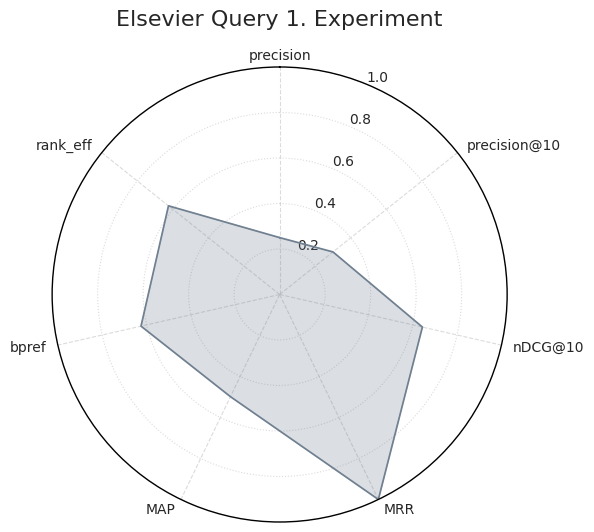

In [72]:
elsevier_q1_results_fig = plot_ir_metrics_radar(elsevier_q1_results_dct, title='Elsevier Query 1. Experiment')

##### 1.1.3.2. Query 2

In [43]:
print(bool_query_2)

architecture AND NLP AND ML


###### **CHECK THE GROUND TRUTH**

In [69]:
elsevier_results_gt_2 = {
    '10.1016/j.inffus.2024.102922': False,
    '10.1016/j.ipm.2024.104043': False,
    '10.1016/j.ccr.2025.216460': False,
    '10.1016/j.ccr.2025.216436': False,
    '10.1016/j.jobe.2024.111733': .5, # cost estimates
    '10.21037/jmai-24-159': False,
    '10.1016/j.eswa.2024.125931': False,
    '10.1016/j.artmed.2025.103066': False,
    '10.1016/j.dajour.2025.100545': False,
    '10.1007/s10462-024-11080-y': False,
    '10.1016/j.pecs.2024.101201': False,
    '10.1016/j.joitmc.2024.100445': False,
    '10.1016/j.csi.2024.103906': False,
    '10.1016/j.enbuild.2024.115247': 0.5, # human-building interaction
    '10.1016/j.engstruct.2024.119472': 0.5, # structural engineering
    '10.1002/cpe.8356': False,
    '10.1016/j.enbuild.2024.115173': False, # Building monitoring systems
    '10.1007/s10462-024-11040-6': False,
    '10.1016/j.compbiomed.2024.109569': False,
    '10.1016/j.cviu.2024.104253': .5, # Computer vision applyable for architecture, no NLP though
    '10.1016/j.autcon.2024.105890': True, # Only hit for now
    '10.1016/j.techfore.2024.123903': False,
    '10.1016/j.cis.2024.103360': False,
    '10.11591/ijece.v15i1.pp559-568': False,
    '10.11591/ijece.v15i1.pp1027-1037': False,
    '10.1016/j.neucom.2024.128096': False,
    '10.1145/3672451': False,
    '10.1145/3672451': False,
    '10.1145/3677117.3685005': False,
    '10.1201/9781003377818-2': False,
    '10.26342/2024-73-16': False,
    '10.3390/jcp4030026': False,
    '10.3390/make6030084': False,
    '10.3390/math12182918': False,
    '10.3390/computers13090239': False,
    '10.3390/info15090517': False,
    '10.3390/bdcc8090113': False,
    '10.3390/bdcc8090107': False,
    '10.1016/j.mcpdig.2024.06.009': False,
    '10.3390/diagnostics14171853': False,
    '10.3390/s24175523': False,
    '10.3390/jcm13175101': False,
    '10.1162/coli_a_00523': False,
    '10.1016/j.jacadv.2024.101072': False,
    '10.1016/S2589-7500(24)00124-9': False,
    '10.1007/s10772-024-10121-9': False,
    '10.1007/s00521-024-10165-7': 0.5, # A stretch, but image classification and RS can be used for urban planning and architecture
    '10.1007/s10664-024-10505-0': False,
    '10.1097/CCO.0000000000001068': False,
    '10.1016/j.jmb.2024.168687': False,
    '10.11591/ijeecs.v35.i3.pp1751-1764': False,
    '10.1007/s42979-024-02698-4': False,
    '10.1109/JAS.2024.124215': False,
    '10.1007/s41870-024-01781-6': False,
    '10.11591/eei.v13i2.6301': False,
    '10.1007/s12145-024-01236-3': False,
    '10.3758/s13423-023-02395-y': False,
    '10.1007/s11600-023-01067-8': False,
    '10.1109/TNNLS.2022.3171398': False,
    '10.4018/978-1-6684-9716-6.ch002': False,
    '10.4018/979-8-3693-1822-5': False,
    '10.1145/3641276': False,
    '10.1063/5.0198729': False,
    '10.4018/979-8-3693-0968-1.ch003': False,
    '10.4018/9798369309681': False,  # a book
    '10.4018/979-8-3693-1842-3.ch008': False,
    '10.4018/979-8-3693-1842-3': False, # a book
    '10.1016/j.isci.2024.109127': False,
    '10.4018/979-8-3693-2238-3': False,
    '10.1145/3616855.3635745': False,
    '10.1162/coli_a_00492': False,
    '10.19101/IJATEE.2023.10102336': 0.5, # Structural engineering, no NLP - to rethink
    '10.3390/iot5010005': 0.5, # home security systems and NLP
    '10.3390/biomedinformatics4010047': False,
    '10.3390/biomedinformatics4010029': False,
    '10.34028/21/2/13': False,
    '10.1109/ACCESS.2024.3491373': False,
    '10.1109/ICACCS60874.2024.10717182': False,
    '10.18413/2313-8912-2024-10-3-0-7': False,
    '10.1109/I-SMAC61858.2024.10714750': False,
    '10.3389/frai.2024.1435895': False,
    '10.1109/ACCESS.2024.3489776': False,
    '10.1007/978-981-97-6588-1_23': False,
    '10.1002/9781119905202.ch4': False,
    '10.1002/9781119905202.ch1': False, # !! example of 'architecture' problem
    '10.1109/TSE.2024.3482719': False,
    '10.2196/58439': False,
    '10.4337/9781800375635.00009': False,
    '10.7717/peerj-cs.2293': False,
    '10.1109/ETFA61755.2024.10711078': False, # regards industrial auttomation and 'smartness', not buildings
    '10.1109/ACCESS.2024.3479774': False,
    '10.1080/19331681.2024.2417263': False,
    '10.1109/NMITCON62075.2024.10699279': False,
    '10.1109/NMITCON62075.2024.10699066': False,
    '10.1007/978-3-031-53972-5': 0.5, # a book with a chapter on smart city communication
    '10.1109/ICoICI62503.2024.10696406': False,
    '10.1080/17517575.2024.2417404': False,
    '10.1109/ICoICI62503.2024.10696424': False,
    '10.1109/IC2SDT62152.2024.10696409': False,
    '10.1109/IVIT62102.2024.10692892': False,
    '10.22712/susb.20240026': True, # wow! the last one is quite True: NLP use for sustainable materials database search.
}

###### **COMPUTE METRICS**

In [70]:
elsevier_q2_results_dct = compute_ir_metrics(gt_dict=OrderedDict(elsevier_results_gt_2.items()) ,experiment_name='elsevier_q2', k=10)
print(elsevier_q2_results_dct)

{'experiment': 'elsevier_q2', 'precision': 0.02, 'precision@10': 0.0, 'nDCG@10': 0.0, 'MRR': 0.047619047619047616, 'MAP': 0.03380952380952381, 'bpref': 0.4111111111111111, 'rank_eff': 0.4111111111111111}


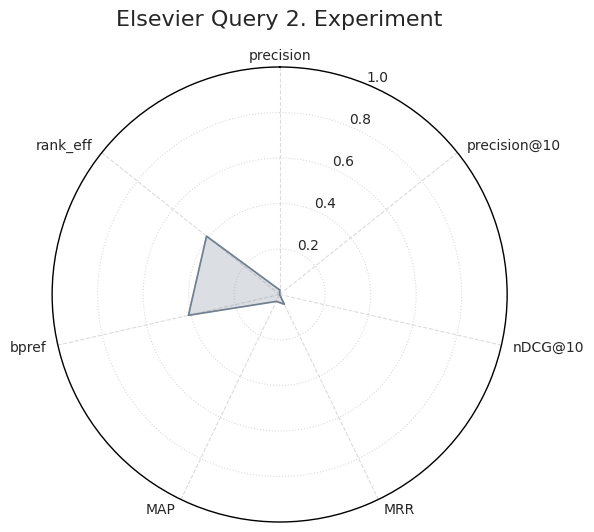

In [74]:
elsevier_q2_results_fig = plot_ir_metrics_radar(elsevier_q2_results_dct, title='Elsevier Query 2. Experiment')

##### 1.1.2.3. Query 3

In [75]:
print(bool_query_3)

architecture AND participation AND (NLP OR "machine learning")


###### **CHECK THE GROUND TRUTH**

In [77]:
elsevier_results_gt_3 = {
    '10.4324/9781003458081-9': False,
    '10.4324/9781003458081-2': False,
    '10.1016/j.energy.2024.134098': False,
    '10.1016/j.energy.2024.133737': False,
    '10.1016/j.neucom.2024.128501': False,
    'nan': False, # Even though a book
    '10.1016/j.rsma.2024.103846': False,
    '10.1016/j.pnpbp.2024.111120': False,
    '10.1016/j.pnpbp.2024.111119': False,
    '10.1163/9789004702691': False,
    '10.14254/1795-6889.2024.20-3.4': False,
    '10.5194/nhess-24-4631-2024': 0.5, # regarding geosciences but may be applied in urban planner's / city architect's parctice. Assumes use of statistical models. Research included iser participation.
    '10.1145/3689042': False,
    '10.37385/jaets.v6i1.6225': False,
    '10.1016/j.energy.2024.133382': False,
    '10.1016/j.aquaculture.2024.741351': False,
    '10.1002/14651858.CD011677.pub4': False,
    '10.1201/9781003521457': True, # However: full text was not inspected. Author assumes there is something about participation
    '10.1201/9781003521440': True, # As above. Again: assuming participation is discussed
    '10.1145/3678698.3687184': False,
    '10.1108/MD-03-2023-0449': False,
    '10.1145/3704806': False,
    '10.1201/9781032622088': False,
    '10.1016/j.est.2024.114381': False,
    '10.1145/3696014': False,
    '10.1038/s41597-024-03433-7': False,
    '10.1186/s40494-024-01268-4': False,
    '10.1186/s10033-024-01036-2': False,
    '10.1038/s41598-024-61412-9': False,
    '10.1038/s41598-024-61598-y': False,
    '10.1186/s13102-024-00885-7': False,
    '10.1007/s43621-024-00266-7': 0.5, # does not include a participatory process
    '10.37934/araset.42.2.221233': False,
    '10.1016/j.plas.2024.100130': False,
    '10.1186/s41239-024-00457-2': False,
    '10.1038/s41598-024-59236-8': False,
    '10.1186/s12913-024-10861-z': False,
    '10.1038/s41539-024-00237-7': False,
    '10.1186/s40494-024-01222-4': True, # although regards general heritage, through ICOMOS and clear participation problem discussed - we do True
    '10.1186/s12984-024-01324-x': False,
    '10.1186/s13059-024-03221-x': False,
    '10.1007/s40593-024-00402-4': False,
    '10.1007/s10579-023-09717-5': False,
    '10.1186/s13677-024-00618-8': False,
    '10.1038/s41598-024-56518-z': False,
    '10.1186/s12984-024-01318-9': False,
    '10.1186/s13048-024-01351-1': False,
    '10.1186/s40494-024-01145-0': True, # regarding both architecture and participation, first strong hit
    '10.1038/s41598-023-51110-3': False,
    '10.1038/s41467-024-44900-4': False,
    '10.4324/9781003356738': False,
    '10.1145/3681716.3681744': True, # use of ai for participatory co-creation of smart cities futures - suitable for research
    '10.1063/5.0235174': 0.5, # to rethink ...?
    '10.1145/3687299': False,
    '10.1039/d4ta05925e': False,
    '10.1016/j.ejphar.2024.176840': False,
    '10.29379/jedem.v16i3.921': False,
    '10.4324/9781003458425': False,
    '10.1103/PRXQuantum.5.040307': False,
    '10.1016/j.ecmx.2024.100790': False,
    '10.18280/ijsse.140502': False,
    '10.1016/j.ecmx.2024.100724': False,
    '10.3390/life14101313': False,
    '10.3390/systems12100395': False,
    '10.3390/aerospace11100837': False,
    '10.3390/info15100603': False,
    '10.3390/info15100626': False,
    '10.3390/info15100640': False,
    '10.3390/en17205186': False,
    '10.48084/etasr.8395': False,
    '10.3390/buildings14103039': False,
    '10.3390/land13101584': True, # and a strong one - both ML and participation present in architectural research. Worth noting: 72nd entry in the search
    '10.3390/land13101688': 0.5, # no participation
    '10.1371/journal.pone.0306923': False,
    '10.3390/land13101709': False,
    '10.1016/j.apergo.2024.104308': False,
    '10.1016/j.jum.2024.04.001': False, # regards built environment however no ml models (just spatial regression) and no participation (only in references)
    '10.1002/for.3096': False,
    '10.1177/14780771241234449': True, # assuming that use of text2image impy participation in research(ed) procedure
    '10.1007/s11042-024-18518-z': False,
    '10.1177/03611981231225655': False,
    '10.1177/14780771231220903': True, # maybe the strongest hit, again 82nd search result!!!!
    '10.1177/02683962231202535': False, # workplace not from architectural perspective
    '10.1007/s40593-023-00357-y': False,
    '10.1007/s10799-022-00376-6': False,
    '10.1007/s10660-022-09569-1': False,
    '10.1051/bioconf/202412303008': 0.5, # A week hit: architecture only through planning of landscape use
    '10.4018/979-8-3693-5288-5': False,
    '10.1515/9781501518430': False,
    '10.1002/9781394200733.ch4': False,
    '10.1145/3637528.3671642': False,
    '10.7500/AEPS20231102004': False,
    '10.4018/978-1-6684-7051-0': False,
    '10.52305/YUWN2377': False,
    '10.1098/rstb.2023.0485': False,
    '10.2174/97898152385181240101':False,
    '10.4018/979-8-3693-5832-0': False,
    '10.1016/j.est.2024.112601': False,
    '10.1016/j.scs.2024.105525': True, #
    '10.1016/j.energy.2024.131672': False,

}

###### **COMPUTE METRICS**


In [78]:
elsevier_q3_results_dct = compute_ir_metrics(gt_dict=OrderedDict(elsevier_results_gt_3.items()) ,experiment_name='elsevier_q3', k=10)
print(elsevier_q3_results_dct)

{'experiment': 'elsevier_q3', 'precision': 0.09, 'precision@10': 0.0, 'nDCG@10': 0.0, 'MRR': 0.05555555555555555, 'MAP': 0.08640444051660423, 'bpref': 0.4328165374677002, 'rank_eff': 0.43281653746770027}


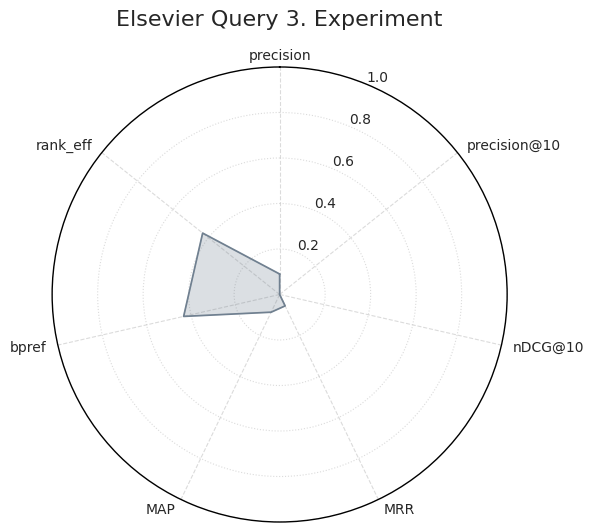

In [79]:
elsevier_q3_results_fig = plot_ir_metrics_radar(elsevier_q3_results_dct, title='Elsevier Query 3. Experiment')

##### 1.1.2.4. Query 4

In [80]:
  print(bool_query_4)

architecture AND theory AND "natural language processing"


###### **CHECK THE GROUND TRUTH**

In [81]:
elsevier_results_gt_4 = {
  "10.53391/mmnsa.1577228": False,
  "10.4186/ej.2024.28.12.79": False,
  "10.13196/j.cims.2024.0598": False,
  "10.1561/1500000097": False,
  "10.1201/9781003465904-7": False,
  "10.21037/jmai-24-67": False,
  "10.1021/acsnano.4c12884": False,
  "10.1126/sciadv.adp6040": False,
  "10.1016/j.knosys.2024.112719": False,
  "10.1016/j.knosys.2024.112711": False,
  "10.1163/9789004702691": False,
  "10.1016/j.cels.2024.11.006": False,
  "10.1515/9783111070162-011": False,
  "10.1108/QEA-01-2024-0006": False,
  "10.1145/3702315": False,
  "10.1016/j.oceaneng.2024.119711": False,
  "10.1016/j.neuropsychologia.2024.108986": False,
  "10.1016/j.eswa.2024.125128": False,
  "10.1016/j.eswa.2024.125126": False,
  "10.1145/3657294": False,
  "10.1016/j.patter.2024.101098": False,
  "10.1021/acs.jpcb.4c02507": False,
  "10.1201/9781003521440": True, # first hit, 23rd search reult
  "10.1145/3701728": False,
  "10.1145/3703454": False,
  "10.1007/s11023-024-09692-y": False,
  "10.1016/j.autcon.2024.105739": False,
  "10.1038/s41467-024-51970-x": False,
  "10.1007/s42001-024-00326-y": False,
  "10.1007/s10115-024-02214-3": False,
  "10.1016/j.cogsys.2024.101279": False,
  "10.1038/s41597-024-03766-3": False,
  "10.1038/s41598-024-70766-z": False,
  "10.1038/s43856-024-00495-x": False,
  "10.1142/S012906572450062X": False,
  "10.1007/s13278-024-01344-4": False,
  "10.1016/j.dt.2024.07.012": False,
  "10.1017/iop.2024.11": False,
  "10.1016/j.media.2024.103324": False,
  "10.1007/s00366-024-02049-0": False,
  "10.1007/s12145-024-01463-8": True, # Use of NLP for building function information retrieval. Can be used in theoretical research regarding urban planning and architecture
  "10.1016/j.wasman.2024.07.031": False,
  "10.1007/s10901-024-10153-2": True,
  "10.1007/s13278-024-01328-4": False,
  "10.1038/s41467-024-51395-6": False,
  "10.1007/s12145-024-01448-7": False,
  "10.1016/j.jechem.2024.07.045": False,
  "10.1186/s13677-024-00691-z": False,
  "10.1061/JUPDDM.UPENG-4770": True,
  "10.1186/s13677-024-00693-x": False,
  "10.1007/s11280-024-01317-9": False,
  "10.1007/s42452-024-06324-z": False,
  "10.1007/s11128-024-04580-x": False,
  "10.3390/su16219275": True,
  "10.3390/app142110025": False,
  "10.3390/electronics13214316": False,
  "10.3390/s24216876": False,
  "10.1016/j.actpsy.2024.104593": False,
  "10.3390/math12213416": False,
  "10.3390/cancers16213702": False,
  "10.3390/electronics13214227": False,
  "10.3390/math12213318": False,
  "10.1111/cogs.70004": False,
  "10.1007/s11277-024-11586-2": False,
  "10.1016/j.jeap.2024.101449": False,
  "10.1016/j.jclepro.2024.143978": False,
  "10.1016/j.culher.2024.09.011": True,
  "10.1016/j.jmrt.2024.10.034": False,
  "10.1016/j.jjimei.2024.100300": False,
  "10.1016/j.jjimei.2024.100299": False,
  "10.1002/widm.1563": False,
  "10.1016/j.datak.2024.102351": False,
  "10.1016/j.earscirev.2024.104941": False,
  "10.1016/j.ensm.2024.103785": False,
  "10.1016/j.cie.2024.110597": False,
  "10.3390/app14209458": False,
  "10.3390/su16209074": True,
  "10.3390/buildings14103039": True,
  "10.3390/su16208889": False,
  "10.3390/app14209302": False,
  "10.3390/buildings14103305": True,
  "10.1016/j.dcan.2022.10.018": False,
  "10.3390/smartcities7050094": True,
  "10.3390/fi16100379": False,
  "10.3390/fi16100365": False,
  "10.3390/app14198884": False,
  "10.3390/math12192998": False,
  "10.3778/j.issn.1673-9418.2407038": False,
  "10.3778/j.issn.1673-9418.2401072": False,
  "10.3778/j.issn.1673-9418.2403083": False,
  "10.3390/rs16193590": False,
  "10.3390/math12193158": False,
  "10.3390/app14199020": False,
  "10.1111/cbdd.14639": False,
  "10.1111/cogs.13500": False,
  "10.1016/j.mfglet.2024.09.164": False,
  "10.1016/j.ascom.2024.100886": False,
  "10.1016/j.mfglet.2024.09.030": False,
  "10.1371/journal.pone.0311161": False,
  "10.1093/genetics/iyae136": False
}

###### **COMPUTE METRICS**


In [82]:
elsevier_q4_results_dct = compute_ir_metrics(gt_dict=OrderedDict(elsevier_results_gt_4.items()) ,experiment_name='elsevier_q4', k=10)
print(elsevier_q4_results_dct)

{'experiment': 'elsevier_q4', 'precision': 0.1, 'precision@10': 0.0, 'nDCG@10': 0.0, 'MRR': 0.043478260869565216, 'MAP': 0.08508699072898433, 'bpref': 0.39888888888888896, 'rank_eff': 0.3988888888888889}


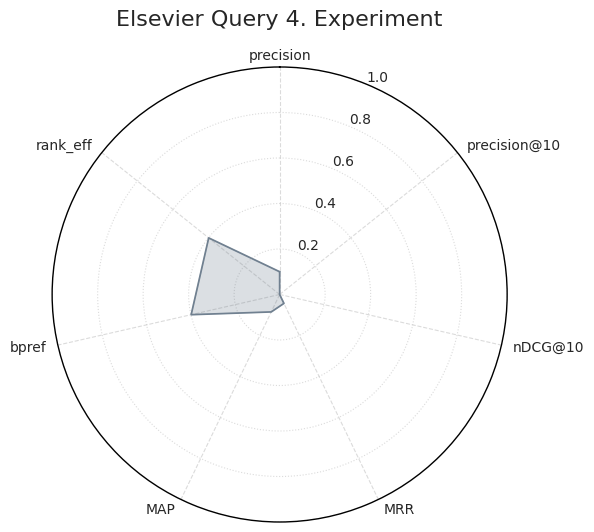

In [84]:
elsevier_q4_results_fig = plot_ir_metrics_radar(elsevier_q4_results_dct, title='Elsevier Query 4. Experiment')

### 1.2. Semantic Scholar database

#### 1.2.1 Semantic Scholar - data retrieval

##### 1.2.1.1. Query 1

In [ ]:
semanticscholar_results_1 = query_semantic_scholar(bool_query_1, limit=100)

{'paperId': 'c32522a460606e5a6d4583d2b522d00a0a428dea', 'externalIds': {'DOI': '10.1155/2022/9754748', 'CorpusId': 253835075}, 'corpusId': 253835075, 'publicationVenue': {'id': '02a4454a-84c8-471c-9b40-cc045d4f3223', 'name': 'Security and Communication Networks', 'type': 'journal', 'alternate_names': ['Secur Commun Netw'], 'issn': '1939-0122', 'url': 'https://www.hindawi.com/journals/scn/', 'alternate_urls': ['http://onlinelibrary.wiley.com/journal/10.1002/(ISSN)1939-0122', 'http://www.interscience.wiley.com/journal/security']}, 'url': 'https://www.semanticscholar.org/paper/c32522a460606e5a6d4583d2b522d00a0a428dea', 'title': 'Retracted: Large-Scale Shopping Mall Architectural Design Based on Intelligent BIM Technology', 'abstract': '<jats:p />', 'venue': 'Security and Communication Networks', 'year': 2022, 'referenceCount': 2, 'citationCount': 0, 'influentialCitationCount': 0, 'isOpenAccess': True, 'openAccessPdf': {'url': 'https://downloads.hindawi.com/journals/scn/2022/9754748.pdf', 

In [ ]:
semanticscholar_results_1_df = pd.DataFrame(semanticscholar_results_1)
semanticscholar_results_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   paper_id  12 non-null     object 
 1   title     12 non-null     object 
 2   authors   12 non-null     object 
 3   abstract  12 non-null     object 
 4   year      11 non-null     float64
 5   url       12 non-null     object 
 6   doi       6 non-null      object 
dtypes: float64(1), object(6)
memory usage: 804.0+ bytes


##### 1.2.1.2. Query 2

In [ ]:
semanticscholar_results_2 = query_semantic_scholar(bool_query_2, limit=100)

{'paperId': '5d60c26cd892df2ddbbfeb33350d694054afde52', 'externalIds': {'DBLP': 'conf/sita/AattouriMR23', 'DOI': '10.1109/SITA60746.2023.10373715', 'CorpusId': 266745839}, 'corpusId': 266745839, 'publicationVenue': None, 'url': 'https://www.semanticscholar.org/paper/5d60c26cd892df2ddbbfeb33350d694054afde52', 'title': 'Call Center Customer Sentiment Analysis Using ML and NLP', 'abstract': 'In the contemporary digital era, call centers have significantly incorporated automation through callbots, but they often lack an essential aspect of customer service: empathy. This paper explores the integration of sentiment analysis into call center operations to introduce an emotional dimension to callbot interactions. Utilizing natural language processing and machine learning, the paper examines both text-based and signal-based sentiment analysis approaches. The proposed sentiment analysis architecture encompasses data input and output interfaces, preprocessing, sentiment analysis, and a decision 

In [ ]:
semanticscholar_results_2_df = pd.DataFrame(semanticscholar_results_2)
semanticscholar_results_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   paper_id  89 non-null     object 
 1   title     89 non-null     object 
 2   authors   89 non-null     object 
 3   abstract  84 non-null     object 
 4   year      88 non-null     float64
 5   url       89 non-null     object 
 6   doi       82 non-null     object 
dtypes: float64(1), object(6)
memory usage: 5.0+ KB


##### 1.2.1.3. Query 3

In [ ]:
semanticscholar_results_3 = query_semantic_scholar(bool_query_3, limit=100)

Error extracting DOI: 'DOI'


In [ ]:
semanticscholar_results_3_df = pd.DataFrame(semanticscholar_results_3)
semanticscholar_results_3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   paper_id  2 non-null      object 
 1   title     2 non-null      object 
 2   authors   2 non-null      object 
 3   abstract  2 non-null      object 
 4   year      1 non-null      float64
 5   url       2 non-null      object 
 6   doi       1 non-null      object 
dtypes: float64(1), object(6)
memory usage: 244.0+ bytes


##### 1.2.1.4. Query 4

In [ ]:
bool_query_4

'architecture AND theory AND "natural language processing"'

In [ ]:
semanticscholar_results_4 = query_semantic_scholar(bool_query_4, limit=100)

Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI: 'DOI'
Error extracting DOI

In [ ]:
semanticscholar_results_4_df = pd.DataFrame(semanticscholar_results_4)
semanticscholar_results_4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   paper_id  100 non-null    object 
 1   title     100 non-null    object 
 2   authors   100 non-null    object 
 3   abstract  87 non-null     object 
 4   year      98 non-null     float64
 5   url       100 non-null    object 
 6   doi       62 non-null     object 
dtypes: float64(1), object(6)
memory usage: 5.6+ KB


#### 1.2.2 Save / load data

###### **SAVE RETRIEVED DATA**

In [ ]:
save_df_with_timestamp(
    df=semanticscholar_results_1_df , partial_filename='semanticscholar_100_query_1' ,data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/semanticscholar_100_query_1_20250222_191115.csv'

In [ ]:
save_df_with_timestamp(
    df=semanticscholar_results_2_df , partial_filename='semanticscholar_100_query_2' ,data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/semanticscholar_100_query_2_20250222_191115.csv'

In [ ]:
save_df_with_timestamp(
    df=semanticscholar_results_3_df , partial_filename='semanticscholar_100_query_3' ,data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/semanticscholar_100_query_3_20250222_191115.csv'

In [ ]:
save_df_with_timestamp(
    df=semanticscholar_results_4_df , partial_filename='semanticscholar_100_query_4' ,data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/semanticscholar_100_query_4_20250222_191116.csv'

###### **LOAD RETRIEVED DATA:**

In [85]:
semanticscholar_results_1_df = read_newest_timestamped_csv(
    partial_name='semanticscholar_100_query_1', folder_path=DATA_Pathj_bool_queries)
semanticscholar_results_2_df = read_newest_timestamped_csv(
    partial_name='semanticscholar_100_query_2', folder_path=DATA_Pathj_bool_queries)
semanticscholar_results_3_df = read_newest_timestamped_csv(
    partial_name='semanticscholar_100_query_3', folder_path=DATA_Pathj_bool_queries)
semanticscholar_results_4_df = read_newest_timestamped_csv(
    partial_name='semanticscholar_100_query_4', folder_path=DATA_Pathj_bool_queries)

Checking for files that start with semanticscholar_100_query_1

semanticscholar_100_query_1_20250126_161004
2025-01-26 16:10:04
semanticscholar_100_query_1_20250126_171422
2025-01-26 17:14:22
semanticscholar_100_query_1_20250129_184009
2025-01-29 18:40:09
semanticscholar_100_query_1_20250222_191115
2025-02-22 19:11:15
Checking for files that start with semanticscholar_100_query_2

semanticscholar_100_query_2_20250126_161004
2025-01-26 16:10:04
semanticscholar_100_query_2_20250126_171423
2025-01-26 17:14:23
semanticscholar_100_query_2_20250129_184009
2025-01-29 18:40:09
semanticscholar_100_query_2_20250222_191115
2025-02-22 19:11:15
Checking for files that start with semanticscholar_100_query_3

semanticscholar_100_query_3_20250222_191115
2025-02-22 19:11:15
Checking for files that start with semanticscholar_100_query_4

semanticscholar_100_query_4_20250222_191116
2025-02-22 19:11:16


#### 1.2.3. Ground truth analysis

##### 1.2.3.1. Query 1

In [ ]:
print(bool_query_1)

NLP and ML and "architectural design" and BIM


###### **CHECK THE GROUND TRUTH**

In [86]:
semanticscholar_results_gt_1 = {
  "c32522a460606e5a6d4583d2b522d00a0a428dea": True,
  # "5a354fb49118b8c030674b8ced4a395259b52715": True, # Duplicate
  "edf360cac67f15813fd973053532c44441dba5cd": False,
  "bdfa5e7034874fc186d3199e02e6a44abe44fd86": True,
  "b41c160261050745f7e935a01743b57d241802e0": True,
  "b1b96fa659abb1b1fbb50c62feb86cbe3e88e708": True,
  # "f5898ea41a45ec291a14d24739e15fbd04b63acf": True, # Duplicate
  "0f4111f0d8b5078ee5bb605f63fa682c74953816": False,
  "418cbaa6eb86e179b9725bc9197f7f171200a901": False,
  "51836769d094a0b801cf717365ffa165a420c3b8": True,
  "b4a039966e844deabcaf97b8f24e6d548d30d7fd": False
}

###### **COMPUTE METRICS**


In [87]:
semsch_q1_results_dct = compute_ir_metrics(gt_dict=OrderedDict(semanticscholar_results_gt_1.items()) ,experiment_name='semsch_q1', k=10)
print(semsch_q1_results_dct)

{'experiment': 'semsch_q1', 'precision': 0.5555555555555556, 'precision@10': 0.5, 'nDCG@10': 0.8930068676327362, 'MRR': 1.0, 'MAP': 0.7683333333333333, 'bpref': 0.7, 'rank_eff': 0.7}


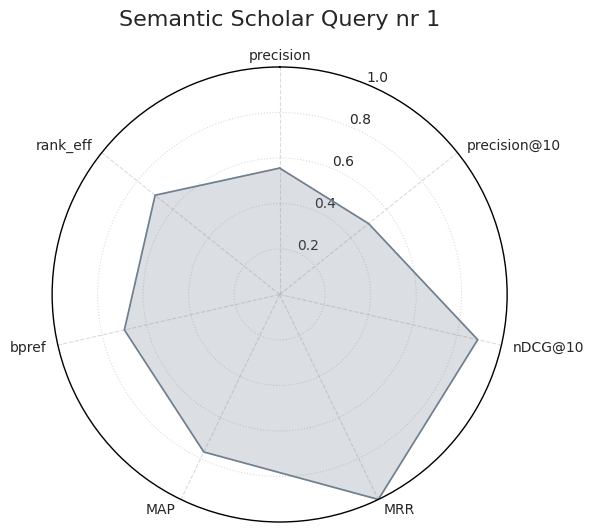

In [88]:
semsch_q1_results_fig = plot_ir_metrics_radar(semsch_q1_results_dct, title='Semantic Scholar Query nr 1')

##### 1.2.3.2. Query 2

In [89]:
print(bool_query_2)

architecture AND NLP AND ML


###### **CHECK THE GROUND TRUTH**

In [90]:
semanticscholar_results_gt_2 = {
  "5d60c26cd892df2ddbbfeb33350d694054afde52": False,
  "1c8a938305c4a60a474760c2802de3d301e31e83": False,
  "a0df2e634e4fcac23bb161323ecac5ab8b714220": False,
  "141f4828fd36991ee830201a4f39fa202a6b59e2": False,
  "87797ef383952035d9f87cb8f4066ea56147c670": False,
  "23c809a02b8584f3cbfbb92819a9d7a38346b338": False,
  "710eb8b927d2861fe938a3dc4df58240888ad1a8": False,
  "b8c94c065c7d048a39a07a7cf244bd89bb39f72e": False,
  "8acf65e8a815be774aa9d4a9473d26e74a79f5c3": False,
  "92a38658f063486edbe5c639b1659d7eb6eee2a6": False,
  "9606c85e44e421f7eb822c9f7130610d6d9d8ad9": False,
  "18c7f19036af9a08a1316d01a28deb0cdc12d60f": False,
  "a265c2e7ae4dfa79ffa56d5f90bed4142b601cfa": False,
  "ff7bce06a79d083a2747bd5f5ccfe1d709cb35a8": False,
  "dddd2fa8bdf970dbbbe771b731f777220de377db": False,
  "c57c1777154eeb244a8b7a927a1e0b5673c05b71": False,
  "06fca85fbbc76b3f6b6addd62df5168772d28a1e": False,
  "844d97973ba192492f6442816a3a20b8fa6fe1ae": False,
  "9bdcd041f0fabe3b42a7cb5bca14b01a0ef72e1a": False,
  "91d36ad5b881727a79785638edacfa18a5ed556d": False,
  "368231b27466feec1bd00d6bbd797aa43462e7cd": False,
  "b736737f3d49f19e289e61bce574f704fbe773c3": False,
  "9265fe2d40265a46012b2803b460ce13bc0102ba": False,
  "78ea7b6c31825b268fbf0ee3266c32b3306660af": False,
  "19813a9e5f9bcdf5cca83161acec76b0268f8e6c": False,
  "d162997cabd76fa4b03c13c6859f757f9387caa0": False,
  "eafffd9e3440ebb2114d1e666258c7a9d262ca48": False,
  "e9ab4f5cf821ea44ebe4fe678ab572360eebb97b": False,
  "4c39e73dca8e5b92ebef3ef7af8448958540d98a": False,
  # "bfb56eaa592fa18ba7d1cf31ed11856c8be31f74": False, # Duplicate
  "2d0037c85cf51d7a97664fc991f79132160d06a4": False,
  "b940da4f329442385a7e6b0df36714aa0cd2dab1": False,
  "dadf09774ea6d9ae0488dedc7df1302121186233": False,
  "0fa0be36ed9220a343569088c85358425955199e": False,
  "820f20696d898176d60d71bd64c061145c8c9ec2": False,
  "1130018f09fc1ca9eaede2446c4c87b9c4d97727": False,
  "f9567a39987d5e6ad03a915c76dc1aeb9193d87e": False,
  "1646c28db1d0253898bc3782d1a9063b8ba1dd6c": False,
  "edd56bf65fc0d4e58aec28109e3e3d3cbf18ab88": False,
  "c690de68bb6127da71532999d73701d1bdd82800": False,
  "a55cc3f1188bef91d86d6c59bfd7dab384491784": False,
  "de2be1b023ee3f171983391a7518e36a50575aff": False,
  "2c7e253bd2a75605bfee960ae12ac5a0dc811f06": False,
  "c02c9c06e04e432e7024c2f3f4a0e60167a33564": False,
  "6fd36dd51da2a18b53fc7bdb9797f279ceb80462": False,
  "131895ba247dfea36058fc529bd347448e0d788a": False,
  "ee7c75f14f5453dc4a86315be8f0a36e3c6db948": False,
  "39a6d8711f5702386e0d614949e5f4ae4be5c574": False,
  "bf361308d778705a95f6c37cf5cc78f9a8ebe179": False,
  "7c944ac865d26045d9033f429ed17e0a80560408": False,
  "097a35a9cb77037b3905be873225dcc6dd4bdeca": False,
  "08f07767bec6ca374f0ae69268d9846f87d46088": False,
  "4a5d283647e7826a8da873c2a50c94146678165d": False,
  "65cb00f3974a80b31107b3bbec5ea1ca90a31172": False,
  "edf360cac67f15813fd973053532c44441dba5cd": False,
  "19cc20e0f266880415aae3ea9866f77b6a96f50d": False,
  "f6de443b1c6f49625575735ee01d714e1d63cde6": False,
  "2f654be328fa62574d66f14583c844e773822f0c": False,
  "bab1c8213f6dfac2e22b0245f3da9b18a1db555b": False,
  "09d90b2c29eb59576f88d3f1c0794b2c3d04219d": False,
  "a8f05dbe7cee10d5c01b3f3d0a0776ff1d01f63a": False,
  "2f1b64b98ee2f04308f4f3b41814e8291f52ddf5": False,
  "01cf7e39c9b2495df0f46385229599b1aaf6360d": False,
  "418cbaa6eb86e179b9725bc9197f7f171200a901": False,
  "4336daf3f8ea2a7c2c68f6dcf7f904869448d393": False,
  "e163f6c285dc5b276c286563513dc66fad3ec2e1": False,
  "a4f95e1bcb0f7fe57e02dae86b74a8af2da64656": False,
  "c77e874b18852738acbccf17f9e585a78973d924": False,
  "2122bf50caa9a2190a66699323945a9d623bdb70": False,
  "aa1e2cecae6bfce858b852f4e4f31f5d5b286b9b": False,
  "0f4111f0d8b5078ee5bb605f63fa682c74953816": False,
  "e3d242738ae73d1db82356548f053c1c6ff29bd6": False,
  "215caac8e67072863e8e6cfb41b06db4c00d3272": False,
  "0a12958cb412a85da95659bce7a09b6fdc09919a": False,
  "421e40b3464725b005b6cfb6c00704eb32e8a537": False,
  "eed42f2980a6d90acc9a238f9933b5d906963ec9": False,
  "b4a039966e844deabcaf97b8f24e6d548d30d7fd": False,
  "506d05bf93b0807ae17ac990584d7aa5895c0f91": False,
  "a7baa898be4bfb930dbcf6d73a5a78f7dbcb2ff2": False,
  "0786b6161f358e8e2a53de7c9c36d7d1c3dbed6d": False,
  "06ef0bbf0dfd0c333912c7a66d633b6f2cadea96": False,
  "15a8b63b766895999041fbbed6cb0fc4988413ff": False,
  "a7910e1051d050aeb7c24bd17ac5b5b05378dc17": False,
  "dc28b25afe6832b80d825f0066af351ecaf16c97": False,
  "c88153b02f42965e23d9b838ef222a6f367a61e0": False,
  "626cdfc5fca9aaa2bac8b41d69ef133bde4e45c5": False,
  "95c667caae2e5d1915662d8c82edc75194031afc": False,
  "28575baa7520427427ef004bbda5fe981f89b171": False,
  "b4ed572e75e0cd861a6740e9c8a5e64283163b60": False
}

###### **COMPUTE METRICS**


In [91]:
semsch_q2_results_dct = compute_ir_metrics(gt_dict=OrderedDict(semanticscholar_results_gt_2.items()) ,experiment_name='semsch_q2', k=10)
print(semsch_q2_results_dct)

{'experiment': 'semsch_q2', 'precision': 0.0, 'precision@10': 0.0, 'nDCG@10': 0, 'MRR': 0, 'MAP': 0, 'bpref': 0, 'rank_eff': 0}


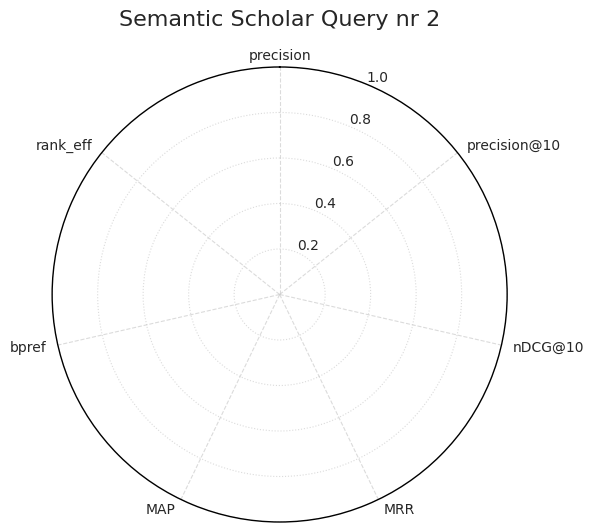

In [92]:
semsch_q2_results_fig = plot_ir_metrics_radar(semsch_q2_results_dct, title='Semantic Scholar Query nr 2')

##### 1.2.3.3. Query 3

In [93]:
print(bool_query_3)

architecture AND participation AND (NLP OR "machine learning")


###### **CHECK THE GROUND TRUTH**

In [94]:
semanticscholar_results_gt_3 = {
  "0786b6161f358e8e2a53de7c9c36d7d1c3dbed6d": False,
  "b4ed572e75e0cd861a6740e9c8a5e64283163b60": False,
}

###### **COMPUTE METRICS**


In [95]:
semsch_q3_results_dct = compute_ir_metrics(gt_dict=OrderedDict(semanticscholar_results_gt_3.items()) ,experiment_name='semsch_q3', k=10)
print(semsch_q3_results_dct)

{'experiment': 'semsch_q3', 'precision': 0.0, 'precision@10': 0.0, 'nDCG@10': 0, 'MRR': 0, 'MAP': 0, 'bpref': 0, 'rank_eff': 0}


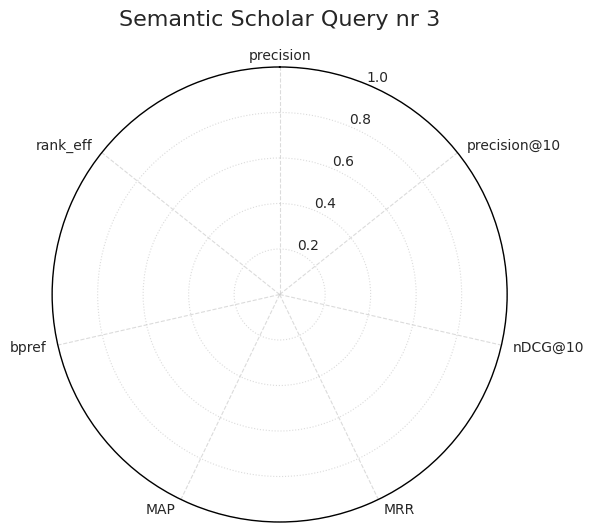

In [97]:
semsch_q3_results_fig = plot_ir_metrics_radar(semsch_q3_results_dct, title='Semantic Scholar Query nr 3')

##### 1.2.2.4. Query 4

In [98]:
print(bool_query_4)

architecture AND theory AND "natural language processing"


###### **CHECK THE GROUND TRUTH**

In [99]:
semanticscholar_results_gt_4 = {
  "63ba89023cabd912b04aafc379a23e9bbd7ebd14": False,
  "2d305ef55e99f28baf7cda3dbc8ffa80b5f7ff8f": False,
  "a27b59ebd57b74a1169d4da61f95ccc1236fab80": False,
  "f9392301c5af8ab227cf7644da5c03552471f0b2": False,
  "ff41621d15ca42b3bae3f661139d9625b1e168c4": False,
  "0e86009cd0c3b0674cd5af62b407035bda3f394b": False,
  "e05b86cf8be0277650b32da6a29b0410db43e0ba": False,
  "469fce4c3438d6bce5fa4f1df9a5f6a9ce94850d": False,
  "f35fb6e3685b9f15f48c58f580fc57bca89bde61": False,
  "7258b78e972731c02007a051d5f7d94f8da4e2a9": False,
  "37fd789552b003b48c1f31dfb741a0c6e581fae1": False,
  "b45d656ac8cc2e940609580cf291ee76ffcac20a": False,
  "00ea3ee83b4a705d65889d302adcb0bbb99c8d61": False,
  "62249064f016261768ba9366924c37b9b1f35cf5": False,
  "846c2bfe8da1394f2a73cae3b044e343b267892b": False,
  "0499939b6d855b5b49a9b9829ce0d19850b346cd": False,
  "92eb187cfa76c55ea4d7b06c8fca52804a77afcf": False,
  "82f18c7165234a3f108ae030c1b99932eb758743": False,
  "1a6370fe7358422c91337d98cc6816ba5f59e5a4": False,
  "3cd33840a269cd9562e9f489babc4ca6922b7abe": False,
  "d0ae1b0e40a19d83153932bc728182802408b349": False,
  "038d3f65a4fb3e62209a6633d2b2e6f77a4208a7": False,
  "90ae8a12ed6702cba2a29c93701087a4717e846a": False,
  "ddc5ca48fd6e96299484066580e0ad68f9e50d53": False,
  "cc142aa425bff39a9385154d34485dc13ce3cf95": False,
  "dfbb35ac7a00501b2a1e11dfae495716c93b1843": False,
  "368231b27466feec1bd00d6bbd797aa43462e7cd": False,
  "ccec3e46f8822dea1542bbb317241979b64dd40f": False,
  "dcd22b4c55ac30067d332b2606d8e68c29545b7d": False,
  "e32c18903a392b72b1112dbd6efee6d947896a9d": False,
  "ec352252a11c7f39894f333606d647522e2f922b": False,
  "0267d5d2c482c43773e53143ab4c81835c497e82": False,
  "022b3d5f684dd6e1b74e0455b5b78a3986c8b69f": False,
  "68815ba8b7a0a3c281671fa34482dcfada7399cf": False,
  "05a0b83f95e663782693e803814ed2700d8b2224": False,
  "19cc20e0f266880415aae3ea9866f77b6a96f50d": False,
  "f6de443b1c6f49625575735ee01d714e1d63cde6": False,
  "2f654be328fa62574d66f14583c844e773822f0c": False,
  "bab1e8213f6dfac2e22b0245f3da9b18a1db555b": False,
  "09d90b2c29eb59576f88d3f1c0794b2c3d04219d": False,
  "d335d189df3920ad6a9353eaf6f70b6766948959": False,
  "c83c539e53f9c57ed837770fe33ec20d002a07a7": False,
  "ef24793e72ee3a087d26623eb828e5bf7103caac": False,
  "de783338efce31d0a62f23304142e6fc6e9205d2": False,
  "e4e5bccdd0af4f2fea2e635726f1dd6dbf13ef03": False,
  "ebd0aafaa6cb10ecb7691b6cf1e6df49be21df99": False,
  "7be2c257ef67c1eef8149d676d0e80e67fc30f90": False,
  "4edcf607399574c145dadad3a2aa491e0774119d": False,
  "c593e4a629d57180a8d63fe0c376b4447f82fd83": False,
  "7b3aac3093875b668765696151bdc5ea838cd0c2": False,
  "8f041722a30964b0b069606ade34ac597971279e": False,
  "c70f2b6fc4baf869765ea41d7a9111ef55bce829": False,
  "1c60ebd41ea95f44bcb9c3534c0071279092c0a1": False,
  "bba699257629e3d51cfd88a89e2fc9f43001e7b4": False,
  "d2542c3e1393880c41488bf4aaa4189f2b906be7": False,
  "1b6798695de27880009346c6c2023665139b0014": False,
  "0c2b1397bacf3c2a24225f15bc4039ccfe27b35a": False,
  "38c13841f7293219eb12e1b158c4d491b3877248": False,
  "65326fa5744e656f7017fd1cd2788b9d81ec60aa": False,
  "69234add10b72f26774a59e116425dc73dbca381": False,
  "31012bdd2244db3c045841800a4a2d3fa0e54b85": False,
  "da838db79e7593018894ada44db35eee670941d6": False,
  "5399abf0754f7f72770ced395bac73ab39f462c6": False,
  "27770662c1b15ddbff01cdb0d28ee53ebf8db05a": False,
  "e0be84ed54b2789a41678a5d54d2ff5e6b9ac900": False,
  "68ca176c7566067ae4b3311957cc4a134bfbc819": False,
  "b974bdb5159896593869554f2000e7ff6a188316": False,
  "168e46b35be2b49c1d64e8731efdb4484d75aad5": False,
  "cff1dc2f592a4f6f325fce959ba34e03d7bdf7bb": False,
  "1b2324270b4c00002d395611acad3f4147d92c6f": False,
  "3ee3f666a1d6f0ddfe48acfac16e1c0a1a52bee8": False,
  "c2701220df16b77f1df3e285fc2465d8f0ba031a": False,
  "e858cdef60d3bd07676cb4436d47c0a918b7ada2": False,
  "af9b3487291a4eea3c91e7862603451b93a3b906": False,
  "847ebf35379100df0ab402641ab8bca49b8ec5a6": False,
  "0d95b06c9f99ddabfd9f3eb15d2d24a91ac2f00f": False,
  # "6adc5b9e65d313b21601a66a555eb8fc033bdea4": False,  # duplicate of 0d95b06c9f99ddabfd9f3eb15d2d24a91ac2f00f
  "2dc3c1850df21e3342414b9d289f16f791e2c216": False,
  "e5ea4638eb0277650f0a53c0ede0b303314bfb3f": False,
  "eedd71fc42b1af732f5c8ce1b2febefdb8cd53d5": False,
  "6af8873120fcb7313c44f52f70ee1cf62fdfac0f": False,
  "335d9acd9a3001109072e71e222ccf1e5b1ec082": False,
  "e8515e3f40ba6a62afd5177bbe235f408b421c4e": False,
  "fa0d704d5171ef80911087ff5fae735b1aec67c1": False,
  "703f9bb6542705bb2897f2dbd4771c1e8d6e4a07": False,
  "c6f93df4ed25a54115d41c9190ccbccfad3cf234": False,
  "6a8a6cb33404907abcce31e9b5ce7e9ff19e284c": False,
  "e6a930fc209e14237bb2b9e17f7acfac97cf00e8": False,
  "b61edbcec8e29dbf7a9fc34ac170e367b8aaab16": False,
  "a4f95e1bcb0f7fe57e02dae86b74a8af2da64656": False,
  "b17e827549b75376a2e56e4324b28e96bb13e576": False,
  "3a4840ecfddc5e938e715379462af6fdbaa5e9b6": False,
  "106dd62b0538bf8c0fb9c0dafcecaec9c561470c": False,
  "13ac118cd306d44b880e12000441822e842ab956": False,
  # "6a8a6cb33404907abcce31e9b5ce7e9ff19e284c_dup": False,  # duplicate of "6a8a6cb33404907abcce31e9b5ce7e9ff19e284c"
  # "e6a930fc209e14237bb2b9e17f7acfac97cf00e8_dup": False,  # duplicate of "e6a930fc209e14237bb2b9e17f7acfac97cf00e8"
  # "b61edbcec8e29dbf7a9fc34ac170e367b8aaab16_dup": False,  # duplicate of "b61edbcec8e29dbf7a9fc34ac170e367b8aaab16"
  # "a4f95e1bcb0f7fe57e02dae86b74a8af2da64656_dup": False,  # duplicate of "a4f95e1bcb0f7fe57e02dae86b74a8af2da64656"
  # "b17e827549b75376a2e56e4324b28e96bb13e576_dup": False,  # duplicate of "b17e827549b75376a2e56e4324b28e96bb13e576"
  # "3a4840ecfddc5e938e715379462af6fdbaa5e9b6_dup": False   # duplicate of "3a4840ecfddc5e938e715379462af6fdbaa5e9b6"

}

###### **COMPUTE METRICS**


In [100]:
semsch_q4_results_dct = compute_ir_metrics(gt_dict=OrderedDict(semanticscholar_results_gt_4.items()) ,experiment_name='semsch_q4', k=10)
print(semsch_q4_results_dct)

{'experiment': 'semsch_q4', 'precision': 0.0, 'precision@10': 0.0, 'nDCG@10': 0, 'MRR': 0, 'MAP': 0, 'bpref': 0, 'rank_eff': 0}


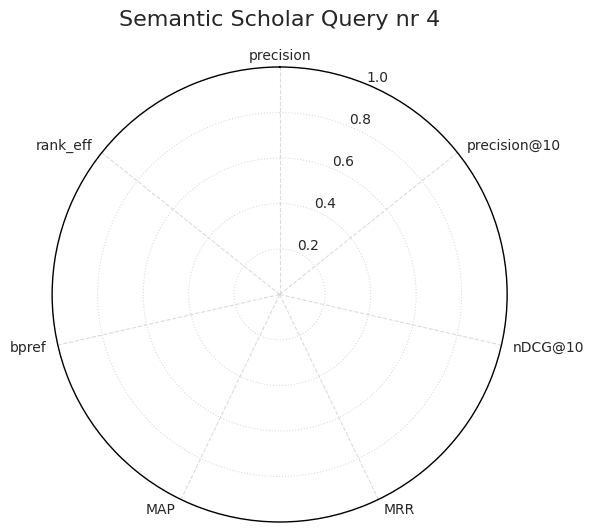

In [101]:
semsch_q4_results_fig = plot_ir_metrics_radar(semsch_q4_results_dct, title='Semantic Scholar Query nr 4')

### 1.3. Arxiv database

#### 1.3.1. Arxiv - data retrieval

##### 1.3.1.1. Query 1

In [ ]:
arxiv_results_1 = query_arxiv(bool_query_1)

In [ ]:
arxiv_results_1_df = pd.DataFrame(arxiv_results_1)
arxiv_results_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   entry_id          100 non-null    object             
 1   title             100 non-null    object             
 2   authors           100 non-null    object             
 3   summary           100 non-null    object             
 4   published         100 non-null    datetime64[ns, UTC]
 5   updated           100 non-null    datetime64[ns, UTC]
 6   categories        100 non-null    object             
 7   primary_category  100 non-null    object             
 8   comment           51 non-null     object             
 9   doi               28 non-null     object             
 10  pdf_url           100 non-null    object             
dtypes: datetime64[ns, UTC](2), object(9)
memory usage: 8.7+ KB


##### 1.3.1.2. Query 2

In [ ]:
arxiv_results_2 = query_arxiv(bool_query_2)

In [ ]:
arxiv_results_2_df = pd.DataFrame(arxiv_results_2)
arxiv_results_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   entry_id          41 non-null     object             
 1   title             41 non-null     object             
 2   authors           41 non-null     object             
 3   summary           41 non-null     object             
 4   published         41 non-null     datetime64[ns, UTC]
 5   updated           41 non-null     datetime64[ns, UTC]
 6   categories        41 non-null     object             
 7   primary_category  41 non-null     object             
 8   comment           26 non-null     object             
 9   doi               3 non-null      object             
 10  pdf_url           41 non-null     object             
dtypes: datetime64[ns, UTC](2), object(9)
memory usage: 3.7+ KB


##### 1.3.1.3. Query 3

In [ ]:
arxiv_results_3 = query_arxiv(bool_query_3)

In [ ]:
arxiv_results_3_df = pd.DataFrame(arxiv_results_3)
arxiv_results_3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   entry_id          100 non-null    object             
 1   title             100 non-null    object             
 2   authors           100 non-null    object             
 3   summary           100 non-null    object             
 4   published         100 non-null    datetime64[ns, UTC]
 5   updated           100 non-null    datetime64[ns, UTC]
 6   categories        100 non-null    object             
 7   primary_category  100 non-null    object             
 8   comment           48 non-null     object             
 9   doi               19 non-null     object             
 10  pdf_url           100 non-null    object             
dtypes: datetime64[ns, UTC](2), object(9)
memory usage: 8.7+ KB


##### 1.3.1.4. Query 4

In [ ]:
arxiv_results_4 = query_arxiv(bool_query_4)

In [ ]:
arxiv_results_4_df = pd.DataFrame(arxiv_results_4)
arxiv_results_4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   entry_id          60 non-null     object             
 1   title             60 non-null     object             
 2   authors           60 non-null     object             
 3   summary           60 non-null     object             
 4   published         60 non-null     datetime64[ns, UTC]
 5   updated           60 non-null     datetime64[ns, UTC]
 6   categories        60 non-null     object             
 7   primary_category  60 non-null     object             
 8   comment           39 non-null     object             
 9   doi               10 non-null     object             
 10  pdf_url           60 non-null     object             
dtypes: datetime64[ns, UTC](2), object(9)
memory usage: 5.3+ KB


#### 1.3.2. Save / load data

###### **SAVE RETRIEVED DATA**

In [ ]:
save_df_with_timestamp(
    df=arxiv_results_1_df , partial_filename='arxiv_100_query_1' ,data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/arxiv_100_query_1_20250222_192702.csv'

In [ ]:
save_df_with_timestamp(
    df=arxiv_results_2_df , partial_filename='arxiv_100_query_2' ,data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/arxiv_100_query_2_20250222_192703.csv'

In [ ]:
save_df_with_timestamp(
    df=arxiv_results_3_df , partial_filename='arxiv_100_query_3' ,data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/arxiv_100_query_3_20250222_192703.csv'

In [ ]:
save_df_with_timestamp(
    df=arxiv_results_4_df , partial_filename='arxiv_100_query_4' ,data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/arxiv_100_query_4_20250222_192703.csv'

###### **LOAD RETRIEVED DATA:**

In [102]:
arxiv_results_1_df = read_newest_timestamped_csv(
    partial_name='arxiv_100_query_1', folder_path=DATA_Pathj_bool_queries)
arxiv_results_2_df = read_newest_timestamped_csv(
    partial_name='arxiv_100_query_2', folder_path=DATA_Pathj_bool_queries)
arxiv_results_3_df = read_newest_timestamped_csv(
    partial_name='arxiv_100_query_3', folder_path=DATA_Pathj_bool_queries)
arxiv_results_4_df = read_newest_timestamped_csv(
    partial_name='arxiv_100_query_4', folder_path=DATA_Pathj_bool_queries)

Checking for files that start with arxiv_100_query_1

arxiv_100_query_1_20250126_172550
2025-01-26 17:25:50
arxiv_100_query_1_20250222_192702
2025-02-22 19:27:02
Checking for files that start with arxiv_100_query_2

arxiv_100_query_2_20250126_172550
2025-01-26 17:25:50
arxiv_100_query_2_20250222_192703
2025-02-22 19:27:03
Checking for files that start with arxiv_100_query_3

arxiv_100_query_3_20250222_192703
2025-02-22 19:27:03
Checking for files that start with arxiv_100_query_4

arxiv_100_query_4_20250222_192703
2025-02-22 19:27:03


#### 1.3.3. Ground truth analysis

##### 1.3.3.1. Query 1

In [103]:
print(bool_query_1)

NLP and ML and "architectural design" and BIM


###### **CHECK THE GROUND TRUTH**

In [105]:
arxiv_results_gt_1 = {
  # Batch 1 (entries 0–39)
  "http://arxiv.org/abs/1303.5874v1": False,
  "http://arxiv.org/abs/2308.00227v1": True,
  "http://arxiv.org/abs/2409.18345v1": True,
  "http://arxiv.org/abs/2304.09333v1": True,
  "http://arxiv.org/abs/2306.14165v1": True,
  "http://arxiv.org/abs/2411.15371v2": False,
  "http://arxiv.org/abs/2305.18032v1": True,
  "http://arxiv.org/abs/2212.00942v1": False,
  "http://arxiv.org/abs/2406.10237v1": True,
  "http://arxiv.org/abs/2406.01480v1": False,
  "http://arxiv.org/abs/2402.07585v1": False,
  "http://arxiv.org/abs/2405.19755v1": False,
  "http://arxiv.org/abs/2405.16875v1": False,
  "http://arxiv.org/abs/2106.10635v1": False,
  "http://arxiv.org/abs/2303.03854v1": True,
  "http://arxiv.org/abs/2304.11719v2": True,
  "http://arxiv.org/abs/2407.19464v3": False,
  "http://arxiv.org/abs/2304.11672v1": False,
  "http://arxiv.org/abs/2110.15448v1": False,
  "http://arxiv.org/abs/1906.02400v1": False,
  "http://arxiv.org/abs/1710.10188v1": False,
  "http://arxiv.org/abs/2109.01211v1": False,
  "http://arxiv.org/abs/2306.12274v1": True,
  "http://arxiv.org/abs/2501.17437v1": False,
  "http://arxiv.org/abs/2210.12307v1": False,
  "http://arxiv.org/abs/2411.09951v1": False,
  "http://arxiv.org/abs/2303.15116v1": False,
  "http://arxiv.org/abs/2101.10848v1": False,
  "http://arxiv.org/abs/2408.15870v1": False,
  "http://arxiv.org/abs/2104.00547v2": False,
  "http://arxiv.org/abs/2308.05443v1": False,
  "http://arxiv.org/abs/2407.14847v1": False,
  "http://arxiv.org/abs/2406.16903v1": True,
  "http://arxiv.org/abs/2402.03602v1": False,
  "http://arxiv.org/abs/2205.00816v2": False,
  "http://arxiv.org/abs/2409.13837v1": False,
  "http://arxiv.org/abs/2407.01987v1": False,
  "http://arxiv.org/abs/1010.5170v1": False,
  "http://arxiv.org/abs/2105.04103v1": True,
  "http://arxiv.org/abs/2408.08054v1": True,

  # Batch 2 (entries 40–59)
  "http://arxiv.org/abs/2311.18166v1": True,
  "http://arxiv.org/abs/2211.02716v1": False,
  "http://arxiv.org/abs/2303.13365v1": False,
  "http://arxiv.org/abs/2307.13197v1": False,
  "http://arxiv.org/abs/2312.11375v1": False,
  "http://arxiv.org/abs/2411.18898v1": False,
  "http://arxiv.org/abs/2409.11263v1": False,
  "http://arxiv.org/abs/2412.11365v2": False,
  "http://arxiv.org/abs/1602.06750v1": False,
  "http://arxiv.org/abs/2107.08262v1": False,
  "http://arxiv.org/abs/1401.8084v4": False,
  "http://arxiv.org/abs/2305.15420v1": True,
  "http://arxiv.org/abs/2106.07410v1": False,
  "http://arxiv.org/abs/2104.02756v1": False,
  "http://arxiv.org/abs/2409.04025v2": False,
  "http://arxiv.org/abs/2205.08572v1": True,
  "http://arxiv.org/abs/2110.03353v1": False,
  "http://arxiv.org/abs/2304.10813v3": False,
  "http://arxiv.org/abs/2001.11093v1": False,
  "http://arxiv.org/abs/2306.08888v1": False,

  # Batch 3 (entries 60–99) – these are duplicates of Batch 2
  #"http://arxiv.org/abs/2311.18166v1_duplicate": True,         # Duplicate of entry 40
  #"http://arxiv.org/abs/2211.02716v1_duplicate": False,         # Duplicate of entry 41
  #"http://arxiv.org/abs/2303.13365v1_duplicate": False,         # Duplicate of entry 42
  #"http://arxiv.org/abs/2307.13197v1_duplicate": False,         # Duplicate of entry 43
  #"http://arxiv.org/abs/2312.11375v1_duplicate": False,         # Duplicate of entry 44
  #"http://arxiv.org/abs/2411.18898v1_duplicate": False,         # Duplicate of entry 45
  #"http://arxiv.org/abs/2409.11263v1_duplicate": False,         # Duplicate of entry 46
  # "http://arxiv.org/abs/2412.11365v2_duplicate": False,         # Duplicate of entry 47
  #"http://arxiv.org/abs/1602.06750v1_duplicate": False,         # Duplicate of entry 48
  #"http://arxiv.org/abs/2107.08262v1_duplicate": False,         # Duplicate of entry 49
  #"http://arxiv.org/abs/1401.8084v4_duplicate": False,          # Duplicate of entry 50
  #"http://arxiv.org/abs/2305.15420v1_duplicate": True,          # Duplicate of entry 51
  #"http://arxiv.org/abs/2106.07410v1_duplicate": False,         # Duplicate of entry 52
  #"http://arxiv.org/abs/2104.02756v1_duplicate": False,         # Duplicate of entry 53
  #"http://arxiv.org/abs/2409.04025v2_duplicate": False,         # Duplicate of entry 54
  #"http://arxiv.org/abs/2205.08572v1_duplicate": True,          # Duplicate of entry 55
  #"http://arxiv.org/abs/2110.03353v1_duplicate": False,         # Duplicate of entry 56
  #"http://arxiv.org/abs/2304.10813v3_duplicate": False,         # Duplicate of entry 57
  #"http://arxiv.org/abs/2001.11093v1_duplicate": False,         # Duplicate of entry 58
  #"http://arxiv.org/abs/2306.08888v1_duplicate": False          # Duplicate of entry 59
}

###### **COMPUTE METRICS**


In [106]:
arxiv_q1_results_dct = compute_ir_metrics(gt_dict=OrderedDict(arxiv_results_gt_1.items()) ,experiment_name='arxiv_q1', k=10)
print(arxiv_q1_results_dct)

{'experiment': 'arxiv_q1', 'precision': 0.25, 'precision@10': 0.6, 'nDCG@10': 0.5684579545875155, 'MRR': 0.5, 'MAP': 0.4796555153342004, 'bpref': 0.6666666666666666, 'rank_eff': 0.6666666666666666}


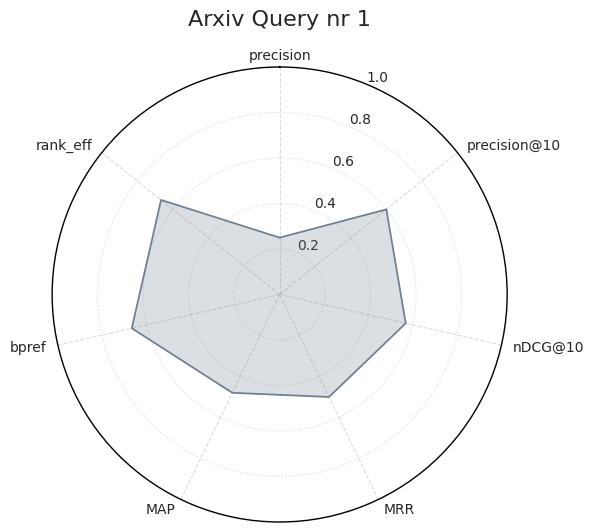

In [107]:
arxiv_q1_results_fig = plot_ir_metrics_radar(arxiv_q1_results_dct, title='Arxiv Query nr 1')

##### 1.3.3.2. Query 2

In [108]:
print(bool_query_2)

architecture AND NLP AND ML


###### **CHECK THE GROUND TRUTH**

In [109]:
arxiv_results_gt_2 = {
  "http://arxiv.org/abs/2110.03353v1": False,
  "http://arxiv.org/abs/2207.12722v1": False,
  "http://arxiv.org/abs/2306.12834v1": False,
  "http://arxiv.org/abs/2111.00830v2": False,
  "http://arxiv.org/abs/2308.08234v1": False,
  "http://arxiv.org/abs/2106.01199v1": False,
  "http://arxiv.org/abs/2305.03117v2": False,
  "http://arxiv.org/abs/2311.09860v1": False,
  "http://arxiv.org/abs/2204.06624v1": False,
  "http://arxiv.org/abs/2304.04029v2": False,
  "http://arxiv.org/abs/2201.05692v1": False,
  "http://arxiv.org/abs/2308.00802v4": False,
  "http://arxiv.org/abs/2008.10138v2": False,
  "http://arxiv.org/abs/2208.14124v1": False,
  "http://arxiv.org/abs/2308.08578v1": False,
  "http://arxiv.org/abs/2211.15927v1": False,
  "http://arxiv.org/abs/2207.03208v2": False,
  "http://arxiv.org/abs/2403.02231v4": True,  # CODE-ACCORD (relates to building regulations in AEC)
  "http://arxiv.org/abs/2404.15382v1": False,
  "http://arxiv.org/abs/2011.02323v1": False,
  "http://arxiv.org/abs/2011.03040v1": False,
  "http://arxiv.org/abs/2101.07463v1": False,
  "http://arxiv.org/abs/2112.15167v1": False,
  "http://arxiv.org/abs/2302.14635v1": False,
  "http://arxiv.org/abs/2502.13668v1": False,
  "http://arxiv.org/abs/2202.02842v3": False,
  "http://arxiv.org/abs/2210.03324v1": False,
  "http://arxiv.org/abs/2401.09685v1": False,
  "http://arxiv.org/abs/2107.08142v3": False,
  "http://arxiv.org/abs/2202.11812v1": False,
  "http://arxiv.org/abs/2401.07483v1": False,
  "http://arxiv.org/abs/2403.04382v1": False,
  "http://arxiv.org/abs/2406.01600v1": False,
  "http://arxiv.org/abs/2407.09162v2": False,
  "http://arxiv.org/abs/2501.19018v2": False,
  "http://arxiv.org/abs/2107.06433v3": False,
  "http://arxiv.org/abs/2306.14263v2": False,
  "http://arxiv.org/abs/2106.14213v1": False,
  "http://arxiv.org/abs/2204.12835v4": False,
  "http://arxiv.org/abs/2012.14353v4": False,
  # "http://arxiv.org/abs/2204.10196v3": False  # Not related to building design
}


###### **COMPUTE METRICS**


In [110]:
arxiv_q2_results_dct = compute_ir_metrics(gt_dict=OrderedDict(arxiv_results_gt_2.items()) ,experiment_name='arxiv_q2', k=10)
print(arxiv_q2_results_dct)

{'experiment': 'arxiv_q2', 'precision': 0.025, 'precision@10': 0.0, 'nDCG@10': 0.0, 'MRR': 0.05555555555555555, 'MAP': 0.05555555555555555, 'bpref': 0.5641025641025641, 'rank_eff': 0.5641025641025641}


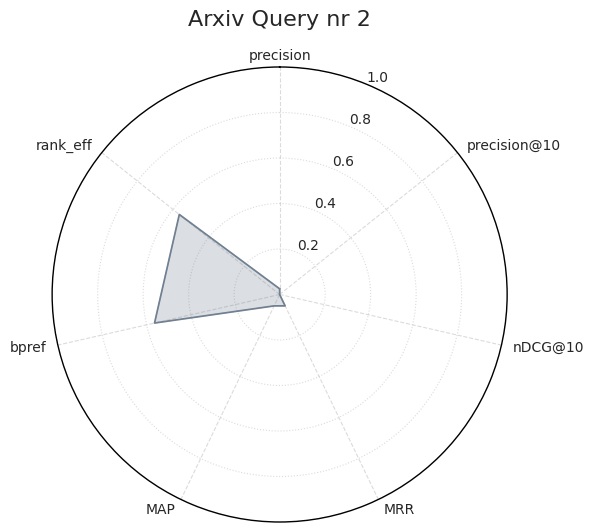

In [111]:
arxiv_q2_results_fig = plot_ir_metrics_radar(arxiv_q2_results_dct, title='Arxiv Query nr 2')

##### 1.3.3.3. Query 3

In [112]:
print(bool_query_3)

architecture AND participation AND (NLP OR "machine learning")


###### **CHECK THE GROUND TRUTH**

In [113]:
arxiv_results_gt_3 = {
  "http://arxiv.org/abs/2202.04742v1": False,
  "http://arxiv.org/abs/2107.06097v1": False,
  "http://arxiv.org/abs/2101.11296v3": False,
  "http://arxiv.org/abs/1810.05102v2": False,
  "http://arxiv.org/abs/1510.02674v1": False,
  "http://arxiv.org/abs/2404.14463v1": False,
  "http://arxiv.org/abs/2305.09134v2": False,
  "http://arxiv.org/abs/2207.03380v1": False,
  "http://arxiv.org/abs/1911.12250v1": False,
  "http://arxiv.org/abs/2206.08094v1": False,
  # "http://arxiv.org/abs/2402.10795v1": False,  # duplicate: appears more than once
  "http://arxiv.org/abs/2501.19091v1": False,
  "http://arxiv.org/abs/2005.14299v1": False,
  "http://arxiv.org/abs/2111.04550v2": False,
  # "http://arxiv.org/abs/2308.08578v1": False,  # duplicate: appears more than once
  # "http://arxiv.org/abs/2211.15927v1": False,  # duplicate: appears more than once
  # "http://arxiv.org/abs/2207.03208v2": False,  # duplicate: appears more than once
  "http://arxiv.org/abs/2403.02231v4": False,
  "http://arxiv.org/abs/2404.15382v1": False,
  "http://arxiv.org/abs/2011.02323v1": False,
  "http://arxiv.org/abs/2011.03040v1": False,
  "http://arxiv.org/abs/2101.07463v1": False,
  "http://arxiv.org/abs/2112.15167v1": False,
  "http://arxiv.org/abs/2302.14635v1": False,
  "http://arxiv.org/abs/2502.13668v1": False,
  "http://arxiv.org/abs/2202.02842v3": False,
  "http://arxiv.org/abs/2210.03324v1": False,
  "http://arxiv.org/abs/2401.09685v1": False,
  "http://arxiv.org/abs/2107.08142v3": False,
  "http://arxiv.org/abs/2202.11812v1": False,
  "http://arxiv.org/abs/2401.07483v1": False,
  "http://arxiv.org/abs/2403.04382v1": False,
  "http://arxiv.org/abs/2406.01600v1": False,
  "http://arxiv.org/abs/2407.09162v2": False,
  "http://arxiv.org/abs/2501.19018v2": False,
  "http://arxiv.org/abs/2107.06433v3": False,
  "http://arxiv.org/abs/2306.14263v2": False,
  "http://arxiv.org/abs/2106.14213v1": False,
  "http://arxiv.org/abs/2204.12835v4": False,
  "http://arxiv.org/abs/2012.14353v4": False,
  "http://arxiv.org/abs/2212.04030v1": False,
  "http://arxiv.org/abs/2401.13001v1": False,
  "http://arxiv.org/abs/2406.03901v1": False,
  "http://arxiv.org/abs/2407.14251v1": False,
  "http://arxiv.org/abs/2112.09288v1": False,
  "http://arxiv.org/abs/1909.01401v1": False,
  "http://arxiv.org/abs/2312.17159v1": False,
  "http://arxiv.org/abs/1912.11279v1": False,
  "http://arxiv.org/abs/2501.13604v1": False,
  "http://arxiv.org/abs/2212.02136v1": False,
  "http://arxiv.org/abs/2201.07402v1": False,
  # "http://arxiv.org/abs/2401.00824v1": False,  # duplicate: appears more than once
  "http://arxiv.org/abs/2006.08742v1": False,
  "http://arxiv.org/abs/2303.03632v1": True,
  "http://arxiv.org/abs/2411.10109v1": False,
  "http://arxiv.org/abs/2007.00641v1": False,
  "http://arxiv.org/abs/2211.05716v2": False,
  "http://arxiv.org/abs/2405.13023v1": False
}

###### **COMPUTE METRICS**


In [114]:
arxiv_q3_results_dct = compute_ir_metrics(gt_dict=OrderedDict(arxiv_results_gt_3.items()) ,experiment_name='arxiv_q3', k=10)
print(arxiv_q3_results_dct)

{'experiment': 'arxiv_q3', 'precision': 0.018867924528301886, 'precision@10': 0.0, 'nDCG@10': 0.0, 'MRR': 0.02040816326530612, 'MAP': 0.02040816326530612, 'bpref': 0.07692307692307687, 'rank_eff': 0.07692307692307693}


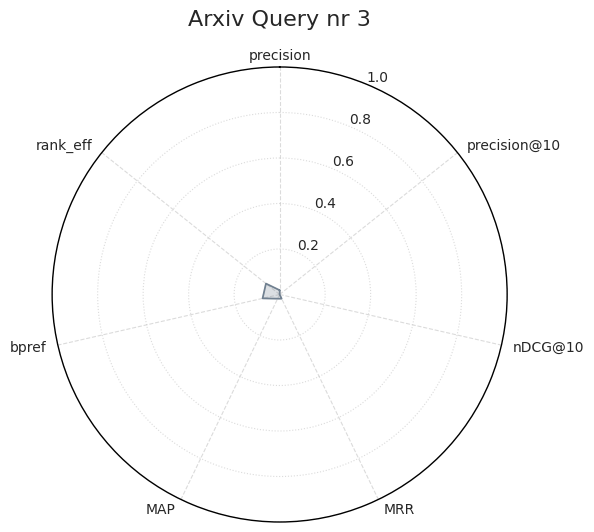

In [115]:
arxiv_q3_results_fig = plot_ir_metrics_radar(arxiv_q3_results_dct, title='Arxiv Query nr 3')

##### 1.3.3.4. Query 4

In [116]:
print(bool_query_4)

architecture AND theory AND "natural language processing"


###### **CHECK THE GROUND TRUTH**

In [117]:
arxiv_results_gt_4 = {
    'http://arxiv.org/abs/2203.14647v2': False,  # Argumentation theory + NLP, no architectural theory involved.
    'http://arxiv.org/abs/2409.07310v1': False,  # Diophantine encoding in NN for NLP and vision tasks, but no relevance to architectural theory.
    'http://arxiv.org/abs/2212.06615v1': False,  # Category theory applied to quantum NLP — theoretical and abstract, but not related to architectural theory.
    'http://arxiv.org/abs/1709.03698v2': False,  # Reversible deep ResNet architectures for NLP and vision, not connected to architectural theory.
    'http://arxiv.org/abs/2501.18793v1': False,  # Transformer model with optimal transport; focuses on model performance in NLP tasks, unrelated to architectural theory.
    'http://arxiv.org/abs/2112.11913v1': False,  # Theoretical exploration of how Transformers represent tree structures, not tied to architecture or its theory.
    'http://arxiv.org/abs/2203.09613v1': False,  # Tensor networks for predicting materials properties, NLP cited as example use case; no architecture or theory links.
    'http://arxiv.org/abs/2202.12205v2': False,  # Structured review of neuro-symbolic NLP models; theoretical, but not tied to architectural domains.
    'http://arxiv.org/abs/1801.04695v3': False,  # Sparsity-based adversarial defense for linear classifiers; relevant to ML theory, not architectural theory.
    'http://arxiv.org/abs/2310.19974v2': False,   # DL for semantic communication under interference; focused on 6G/NLP, not on architectural theory.

    "http://arxiv.org/abs/2407.00958v5": False,  # Focuses on theoretical foundations of LLMs and UAT, no relation to architecture theory (built environment) or its intersection with NLP.
    "http://arxiv.org/abs/2411.19094v2": True,   # Strong match: Uses GPT and NLP methods to assess architectural aesthetics via Alexander’s theory—directly bridges NLP and architectural theory.
    "http://arxiv.org/abs/2403.18969v2": False,  # Broad survey on LLMs, no reference to architecture or architectural theory.
    "http://arxiv.org/abs/1903.09761v1": False,  # Applies vision and NLP to robotic manipulation; unrelated to architectural theory.
    "http://arxiv.org/abs/1906.02989v2": False,  # Survey on graph learning methods; mentions NLP, but no architectural context.
    "http://arxiv.org/abs/2002.08899v1": False,  # Neural machine translation paper focusing on syntax–lexicon separation; no connection to architectural theory.
    "http://arxiv.org/abs/2005.04749v2": False,  # Sentiment analysis using curriculum learning; purely NLP-focused, not related to architectural theory.
    "http://arxiv.org/abs/2012.01231v1": False,  # Sequence generation for music, references NLP techniques but not architecture or theory.
    "http://arxiv.org/abs/2205.15389v1": False,  # Method for visualizing Transformer attention; relevant to NLP model interpretation but not architecture.
    "http://arxiv.org/abs/2211.02415v1": False,   # Multilingual NER and intent classification; standard NLP task, not linked to architectural theory.

    "http://arxiv.org/abs/2305.06140v1": False,  # Fine-tuning sentiment analysis for crude oil market using NLP; economic theory involved, but no architectural theory context.
    "http://arxiv.org/abs/2308.07871v1": False,  # Emotion embeddings across modalities using NLP; unrelated to architectural theory or built environments.
    "http://arxiv.org/abs/2311.00208v3": False,  # Theoretical survey of transformers via formal languages; purely NLP theory, no architectural context.
    "http://arxiv.org/abs/2312.06141v2": False,  # Survey of memory-augmented neural networks across AI applications, including NLP; no connection to architecture or its theory.
    "http://arxiv.org/abs/2401.16736v3": False,  # LLM engineering description; no mention of architecture (as built environment) or architectural theory.
    "http://arxiv.org/abs/2402.15478v3": False,  # Theoretical investigation into transformers’ expressivity in regression; unrelated to architecture or design theory.
    "http://arxiv.org/abs/2407.10114v2": False,  # Interpreting LLMs via Shapley values (TokenSHAP); methodological NLP paper, no architectural content.
    "http://arxiv.org/abs/2408.16740v1": True,   # Discusses theoretical framework for studying LLM-generated texts from a **quantitative linguistics and cultural theory** perspective; touches on **cultural theory of language**, which overlaps with aspects of architectural theory in humanities contexts.
    "http://arxiv.org/abs/2410.06019v1": False,  # Mathematical exploration of transformer perception; applicable to NLP and vision but doesn't touch architectural theory.
    "http://arxiv.org/abs/2410.10054v1": False,   # Fine-tuning strategy for LLMs (AlphaLoRA); internal optimization, unrelated to architecture or its theory.

    "http://arxiv.org/abs/1912.11511v1": False,  # Theoretical analysis of neural networks using Lipschitz constants; unrelated to architectural theory or design.
    "http://arxiv.org/abs/2012.01114v1": False,  # Parallel scheduling for self-attention in NLP; no architectural theory aspect.
    "http://arxiv.org/abs/2203.06153v1": False,  # Symmetry group equivariant ML models, useful in physics and NLP; mentions "architectures" as in ML architectures, not architectural theory.
    "http://arxiv.org/abs/2501.16394v1": False,  # Input-adaptive transformer design for resource-constrained environments; mentions NLP tasks, but not theory of architecture or design.
    "http://arxiv.org/abs/1710.05312v2": False,  # Deep learning for wireless physical layer; includes NLP as a domain, but does not intersect with architectural theory.
    "http://arxiv.org/abs/1801.04223v1": False,  # AI for next-gen wireless networks; NLP is listed, but focus is entirely on telecommunications, not architecture/design theory.
    "http://arxiv.org/abs/1812.02858v2": False,  # Edge ML in wireless networks; NLP is an example domain, but paper is focused on distributed learning, not architecture theory.
    "http://arxiv.org/abs/2211.11483v5": True,   # Philosophical and theoretical discussion on whether LLMs can be conscious; explicitly critiques anthropomorphic metaphors in NLP, relevant for discourse theory in architectural humanities.
    "http://arxiv.org/abs/2307.00653v1": False,  # Uses neuro-symbolic models for Sudoku solving; focuses on logic and reinforcement learning, not architectural theory.
    "http://arxiv.org/abs/2310.16154v1": False,   # Theoretical thesis on deep learning and invariant representations; while abstract theory is discussed, there's no link to architectural theory or the built environment.

    "http://arxiv.org/abs/1709.00308v2": False,  # Survey of deep learning in remote sensing; discusses architectures in the ML sense, not architectural theory.
    "http://arxiv.org/abs/2203.07975v1": False,  # RG-flow categorifier; a theoretical NLP model used for bio/genomics, unrelated to architecture as built environment or theory.
    "http://arxiv.org/abs/1810.12065v4": False,  # Convergence of RNNs in NLP; purely about ML theory, not architectural design or theory.
    "http://arxiv.org/abs/2010.16263v1": True,   # Introduces NLP techniques into the study of **knot theory** via braid word representations; directly intersects NLP with another formal theory.
    "http://arxiv.org/abs/2002.04745v2": False,  # Technical paper on layer normalization in transformers; entirely focused on model stability, not architectural theory.
    "http://arxiv.org/abs/2201.03866v3": False,  # Deep learning for wireless networks; NLP is mentioned as one use case but not analyzed in architectural context.
    "http://arxiv.org/abs/2206.13086v3": False,  # Proposes a ranking-based framework for segmentation (CV/NLP); no architectural theory component.
    "http://arxiv.org/abs/2305.09550v2": False,  # Transformer-based method to obfuscate personally identifiable information; focuses on privacy in NLP, not architecture.
    "http://arxiv.org/abs/2411.06681v1": False,  # Wireless distributed architecture for LLMs; entirely technical focus, no relation to architectural theory.
    "http://arxiv.org/abs/2010.15703v3": False,   # Neural network compression techniques for efficient deployment; focuses on NLP model efficiency, unrelated to architectural theory.

    "http://arxiv.org/abs/1912.03585v1": False,  # Focuses on predicting question deletion in QA forums using neural networks; NLP + IR, no relation to architectural theory.
    "http://arxiv.org/abs/2110.01834v1": False,  # Proposes metacognition-inspired AI architecture; theoretical but general AI, no clear connection to architecture or NLP applications in that field.
    "http://arxiv.org/abs/2109.05090v3": False,  # Enhances dialog self-disclosure in neural models; only focuses on conversational AI and social theory, not architectural theory.
    "http://arxiv.org/abs/2205.07417v2": False,  # Survey of Transformers for 3D point cloud processing; method-level NLP-CV overlap but nothing tied to architectural theory.
    "http://arxiv.org/abs/2211.08506v1": False,  # Introduces 3D grid representation for materials science and deep learning; unrelated to architecture in humanistic or design sense.
    "http://arxiv.org/abs/2309.12404v1": False,  # Uses NLP for predicting molecular parameters from SMILES notation; technical application of NLP to chemistry.
    "http://arxiv.org/abs/2403.08081v1": False,  # Theoretical exploration of token prediction and self-attention; deep dive into transformer theory, no architectural or applied NLP crossover.
    "http://arxiv.org/abs/2405.16747v2": False,  # NTK perspective on linear probing + fine-tuning; entirely focused on LLM training dynamics, not connected to architectural theory.
    "http://arxiv.org/abs/2405.04404v1": False,  # Survey of Mamba architecture and its use in CV, NLP, and remote sensing; no thematic or conceptual overlap with architectural theory.
    "http://arxiv.org/abs/2502.14499v1": False,  # MLGym: environment for testing LLMs on AI research tasks; while it includes NLP among domains, it does not intersect with architecture or theory.
}


###### **COMPUTE METRICS**


In [118]:
arxiv_q4_results_dct = compute_ir_metrics(gt_dict=OrderedDict(arxiv_results_gt_4.items()) ,experiment_name='arxiv_q4', k=10)
print(arxiv_q4_results_dct)

{'experiment': 'arxiv_q4', 'precision': 0.06666666666666667, 'precision@10': 0.0, 'nDCG@10': 0.0, 'MRR': 0.08333333333333333, 'MAP': 0.08115459102301208, 'bpref': 0.5, 'rank_eff': 0.5}


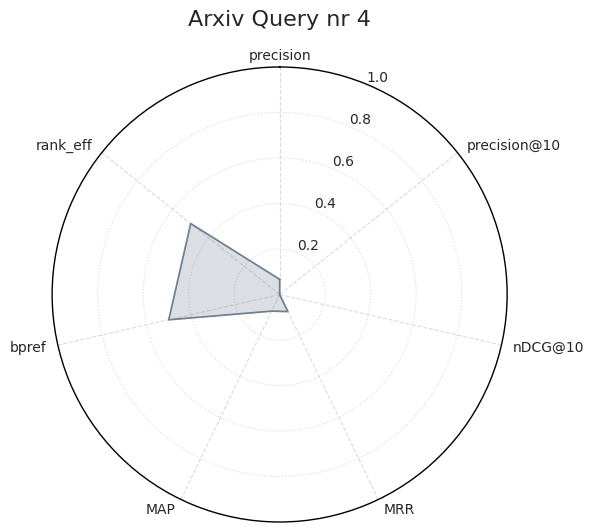

In [119]:
arxiv_q4_results_fig = plot_ir_metrics_radar(arxiv_q4_results_dct, title='Arxiv Query nr 4')

### 1.4. Google Scholar

#### 1.4.1. Google Scholar - data retrieval

##### 1.4.1.1. Query 1

In [ ]:
googscholar_results_1 = query_google_scholar(bool_query_1)

{'container_type': 'Publication', 'source': <PublicationSource.PUBLICATION_SEARCH_SNIPPET: 'PUBLICATION_SEARCH_SNIPPET'>, 'bib': {'title': '… digital tools for assisting low-carbon architectural design: merging the use of machine learning, large language models, and building information modeling for life cycle …', 'author': ['M Płoszaj-Mazurek', 'E Ryńska'], 'pub_year': '2024', 'venue': 'Energies', 'abstract': 'Architectural design decisions play a critical role in a building’s carbon footprint,  building  information modeling (BIM) can support designers in achieving low-carbon architectural design'}, 'filled': False, 'gsrank': 1, 'pub_url': 'https://www.mdpi.com/1996-1073/17/12/2997', 'author_id': ['yFWVSDIAAAAJ', '1zIv1gcAAAAJ'], 'url_scholarbib': '/scholar?hl=en&q=info:8K2eYHaB08sJ:scholar.google.com/&output=cite&scirp=0&hl=en', 'url_add_sclib': '/citations?hl=en&xsrf=&continue=/scholar%3Fq%3DNLP%2Band%2BML%2Band%2B%2522architectural%2Bdesign%2522%2Band%2BBIM%26hl%3Den%26as_sdt%3D1,

In [ ]:
googscholar_results_1_df = pd.DataFrame(googscholar_results_1)
googscholar_results_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 100 non-null    object
 1   author                100 non-null    object
 2   pub_year              100 non-null    object
 3   venue                 100 non-null    object
 4   abstract              100 non-null    object
 5   gsrank                100 non-null    int64 
 6   pub_url               100 non-null    object
 7   num_citations         100 non-null    int64 
 8   citedby_url           100 non-null    object
 9   related_articles_url  100 non-null    object
 10  eprint_url            100 non-null    object
dtypes: int64(2), object(9)
memory usage: 8.7+ KB


In [ ]:
googscholar_results_1_df.head()

,title,author,pub_year,venue,abstract,gsrank,pub_url,num_citations,citedby_url,related_articles_url,eprint_url
0,… digital tools for assisting low-carbon archi...,"M Płoszaj-Mazurek, E Ryńska",2024,Energies,Architectural design decisions play a critical...,1,https://www.mdpi.com/1996-1073/17/12/2997,9,"/scholar?cites=14687225155212455408&as_sdt=5,3...",/scholar?q=related:8K2eYHaB08sJ:scholar.google...,https://www.mdpi.com/1996-1073/17/12/2997/pdf
1,Enhancing Engineering and Architectural Design...,"A Shehadeh, O Alshboul",2025,Buildings,"AI, including ML, natural language processing,...",2,https://www.mdpi.com/2075-5309/15/3/328,1,"/scholar?cites=16308433070646436466&as_sdt=5,3...",/scholar?q=related:ciId03gxU-IJ:scholar.google...,https://www.mdpi.com/2075-5309/15/3/328
2,AI-assisted building design,"S Saad, M Haris, S Ammad, K Rasheed",2024,AI in material science,", can be analyzed using NLP techniques to extr...",3,https://www.taylorfrancis.com/chapters/edit/10...,3,"/scholar?cites=16413868685128990257&as_sdt=5,3...",/scholar?q=related:MX4Fz5rGyeMJ:scholar.google...,No eprint URL available
3,Applications of machine learning to BIM: A sys...,"A Zabin, VA González, Y Zou, R Amor",2022,Advanced Engineering Informatics,"Reasoning (CBR), and NLP techniques were appli...",4,https://www.sciencedirect.com/science/article/...,118,"/scholar?cites=4206412660155643252&as_sdt=5,33...",/scholar?q=related:dHVIIwcuYDoJ:scholar.google...,No eprint URL available
4,BIM-based design decisions documentation using...,"A Zahedi, J Abualdenien, F Petzold",2022,Journal of information …,"In everyday practice, it is not mandatory to d...",5,https://mediatum.ub.tum.de/doc/1683874/documen...,12,"/scholar?cites=10892463843777988508&as_sdt=5,3...",/scholar?q=related:nEcsuSfOKZcJ:scholar.google...,https://mediatum.ub.tum.de/doc/1683874/documen...


##### 1.4.1.2. Query 2

In [ ]:
googscholar_results_2 = query_google_scholar(bool_query_2)

{'container_type': 'Publication', 'source': <PublicationSource.PUBLICATION_SEARCH_SNIPPET: 'PUBLICATION_SEARCH_SNIPPET'>, 'bib': {'title': 'Non-functional requirements to architectural concerns: ML and NLP at crossroads', 'author': ['G Gokyer', 'S Cetin', 'C Sener'], 'pub_year': '2008', 'venue': '2008 the third …', 'abstract': 'text by Natural Language Processing (NLP) and mapping identified NFRs to “architectural  aspects” and “quality attributes” in the problem domain by Machine Learning (ML) techniques.'}, 'filled': False, 'gsrank': 1, 'pub_url': 'https://ieeexplore.ieee.org/abstract/document/4668138/', 'author_id': ['', '', 'CbwZnuUAAAAJ'], 'url_scholarbib': '/scholar?hl=en&q=info:HYmDh0TcL4sJ:scholar.google.com/&output=cite&scirp=0&hl=en', 'url_add_sclib': '/citations?hl=en&xsrf=&continue=/scholar%3Fq%3Darchitecture%2BAND%2BNLP%2BAND%2BML%26hl%3Den%26as_sdt%3D1,33&citilm=1&update_op=library_add&info=HYmDh0TcL4sJ&ei=DYvxZ7fvL8mpieoPiM270QI&json=', 'num_citations': 27, 'citedby_url'

In [ ]:
googscholar_results_2_df = pd.DataFrame(googscholar_results_2)
googscholar_results_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 100 non-null    object
 1   author                100 non-null    object
 2   pub_year              100 non-null    object
 3   venue                 100 non-null    object
 4   abstract              100 non-null    object
 5   gsrank                100 non-null    int64 
 6   pub_url               100 non-null    object
 7   num_citations         100 non-null    int64 
 8   citedby_url           100 non-null    object
 9   related_articles_url  100 non-null    object
 10  eprint_url            100 non-null    object
dtypes: int64(2), object(9)
memory usage: 8.7+ KB


##### 1.4.1.3. Query 3

In [ ]:
googscholar_results_3 = query_google_scholar(bool_query_3)

{'container_type': 'Publication', 'source': <PublicationSource.PUBLICATION_SEARCH_SNIPPET: 'PUBLICATION_SEARCH_SNIPPET'>, 'bib': {'title': 'Participation is not a design fix for machine learning', 'author': ['M Sloane', 'E Moss', 'O Awomolo', 'L Forlano'], 'pub_year': '2022', 'venue': 'Proceedings of the 2nd ACM …', 'abstract': 'modes of participation in design practice and machine learning. It  and machine learning  participation as work, participation as  Architecture and urban planning practices use citizen'}, 'filled': False, 'gsrank': 1, 'pub_url': 'https://dl.acm.org/doi/abs/10.1145/3551624.3555285', 'author_id': ['lkD68xsAAAAJ', '7YMykaUAAAAJ', '', 'gsdLZbUAAAAJ'], 'url_scholarbib': '/scholar?hl=en&q=info:fu3qMmq50XQJ:scholar.google.com/&output=cite&scirp=0&hl=en', 'url_add_sclib': '/citations?hl=en&xsrf=&continue=/scholar%3Fq%3Darchitecture%2BAND%2Bparticipation%2BAND%2B(NLP%2BOR%2B%2522machine%2Blearning%2522)%26hl%3Den%26as_sdt%3D1,33&citilm=1&update_op=library_add&info=fu3qM

In [ ]:
googscholar_results_3_df = pd.DataFrame(googscholar_results_3)
googscholar_results_3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 100 non-null    object
 1   author                100 non-null    object
 2   pub_year              100 non-null    object
 3   venue                 100 non-null    object
 4   abstract              100 non-null    object
 5   gsrank                100 non-null    int64 
 6   pub_url               100 non-null    object
 7   num_citations         100 non-null    int64 
 8   citedby_url           100 non-null    object
 9   related_articles_url  100 non-null    object
 10  eprint_url            100 non-null    object
dtypes: int64(2), object(9)
memory usage: 8.7+ KB


##### 1.4.1.4. Query 4

In [ ]:
googscholar_results_4 = query_google_scholar(bool_query_4)

{'container_type': 'Publication', 'source': <PublicationSource.PUBLICATION_SEARCH_SNIPPET: 'PUBLICATION_SEARCH_SNIPPET'>, 'bib': {'title': 'Natural language processing in biomedicine: a unified system architecture overview', 'author': ['S Doan', 'M Conway', 'TM Phuong'], 'pub_year': '2014', 'venue': 'Clinical bioinformatics', 'abstract': 'From the viewpoint of system architecture, we consider a general architecture in which an  NLP  Our view of a general architecture is depicted in Fig. 2. Below we describe the two main'}, 'filled': False, 'gsrank': 1, 'pub_url': 'https://link.springer.com/protocol/10.1007/978-1-4939-0847-9_16', 'author_id': ['zIJaWPEAAAAJ', 'uiJso6MAAAAJ', 'yJvNgd4AAAAJ'], 'url_scholarbib': '/scholar?hl=en&q=info:utF8bVV2sncJ:scholar.google.com/&output=cite&scirp=0&hl=en', 'url_add_sclib': '/citations?hl=en&xsrf=&continue=/scholar%3Fq%3Darchitecture%2BAND%2Btheory%2BAND%2B%2522natural%2Blanguage%2Bprocessing%2522%26hl%3Den%26as_sdt%3D1,33&citilm=1&update_op=library_ad

In [ ]:
googscholar_results_4_df = pd.DataFrame(googscholar_results_4)
googscholar_results_4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 100 non-null    object
 1   author                100 non-null    object
 2   pub_year              100 non-null    object
 3   venue                 100 non-null    object
 4   abstract              100 non-null    object
 5   gsrank                100 non-null    int64 
 6   pub_url               100 non-null    object
 7   num_citations         100 non-null    int64 
 8   citedby_url           100 non-null    object
 9   related_articles_url  100 non-null    object
 10  eprint_url            100 non-null    object
dtypes: int64(2), object(9)
memory usage: 8.7+ KB


#### 1.4.2. Save / load data

###### **SAVE RETRIEVED DATA**

In [ ]:
save_df_with_timestamp(
    df=googscholar_results_1_df , partial_filename='googscholar_100_query_1' ,data_path=DATA_Pathj_bool_queries)
save_df_with_timestamp(
    df=googscholar_results_2_df , partial_filename='googscholar_100_query_2' ,data_path=DATA_Pathj_bool_queries)
save_df_with_timestamp(
    df=googscholar_results_3_df , partial_filename='googscholar_100_query_3' ,data_path=DATA_Pathj_bool_queries)
save_df_with_timestamp(
    df=googscholar_results_4_df , partial_filename='googscholar_100_query_4' ,data_path=DATA_Pathj_bool_queries)

'/content/drive/MyDrive/_DOKTORAT/PAPER_001/DATA_FOLDER/BOOLEAN_QUERIES/googscholar_100_query_4_20250405_201025.csv'

###### **LOAD RETRIEVED DATA:**

In [120]:
googscholar_results_1_df = read_newest_timestamped_csv(
    partial_name='googscholar_100_query_1', folder_path=DATA_Pathj_bool_queries)
googscholar_results_2_df = read_newest_timestamped_csv(
    partial_name='googscholar_100_query_2', folder_path=DATA_Pathj_bool_queries)
googscholar_results_3_df = read_newest_timestamped_csv(
    partial_name='googscholar_100_query_3', folder_path=DATA_Pathj_bool_queries)
googscholar_results_4_df = read_newest_timestamped_csv(
    partial_name='googscholar_100_query_4', folder_path=DATA_Pathj_bool_queries)

Checking for files that start with googscholar_100_query_1

googscholar_100_query_1_20250127_210158
2025-01-27 21:01:58
googscholar_100_query_1_20250405_201025
2025-04-05 20:10:25
Checking for files that start with googscholar_100_query_2

googscholar_100_query_2_20250127_210207
2025-01-27 21:02:07
googscholar_100_query_2_20250405_201025
2025-04-05 20:10:25
Checking for files that start with googscholar_100_query_3

googscholar_100_query_3_20250405_201025
2025-04-05 20:10:25
Checking for files that start with googscholar_100_query_4

googscholar_100_query_4_20250405_201025
2025-04-05 20:10:25


#### 1.4.3. Ground truth analysis

##### 1.4.3.1. Query 1

In [128]:
print(bool_query_1)

NLP and ML and "architectural design" and BIM


###### **CHECK THE GROUND TRUTH**

In [140]:
google_scholar_results_gt_1 = {
    'https://www.mdpi.com/1996-1073/17/12/2997': True,  # All three elements explicitly present
    'https://www.mdpi.com/2075-5309/15/3/328': False,  # No explicit link to NLP in context of architectural design
    'https://www.taylorfrancis.com/chapters/edit/10.1201/9781003438489-7/ai-assisted-building-design-syed-saad-muhammad-haris-syed-ammad-kumeel-rasheed': True,  # All three discussed: NLP, BIM, architectural design
    'https://www.sciencedirect.com/science/article/pii/S147403462100224X': True,  # NLP techniques applied to BIM in architectural design stages
    'https://mediatum.ub.tum.de/doc/1683874/document.pdf': True,  # Mentions BIM, architectural design, and NLP
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4637891': False,  # No clear mention of NLP
    'https://www.iccaua.com/PDFs/ICCAUA2024/Book_Chapter_AI/07_AI-Driven-7.pdf': True,  # All three: NLP, BIM, architectural design
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4645601': False,  # Focused on generative AI and BIM, unclear about NLP + architectural design
    'https://www.sciencedirect.com/science/article/pii/S2451958823000520': False,  # Mentions AI, BIM, architectural design, but NLP not central
    'https://openaccess.wgtn.ac.nz/articles/thesis/Co-Designing_with_Artificial_Intelligence_Exploring_the_use_of_machine_learning_in_the_AEC_industry/22329208': False,  # ML and architectural design, no clear NLP
    'https://www.mdpi.com/2075-5309/11/12/583': True,  # Mentions BIM, NLP, and architectural design explicitly
    'No publication URL available - Machine-Interpretable BIM-based Communication and Design Decisions Documentation': False,  # No info to confirm NLP presence
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4691649': True,  # All three elements present
    'https://academic.oup.com/jcde/article-abstract/11/3/137/7659834': True,  # NLP-based recommender system in BIM and architectural design
    'https://www.mdpi.com/2673-8945/4/4/46': True,  # Discusses NLP, BIM workflows, and architectural design generation
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4607767': True,  # Explicit on NLP, architectural design, and BIM integration
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4645595': True,  # Uses NLP for querying BIM in architectural design context
    'https://www.sciencedirect.com/science/article/pii/S1474034624001800': True,  # NLP-based AI interacting with BIM in architectural detailing
    'https://www.researchgate.net/profile/Abdulsalam-Shema/publication/385957505_Artificial_Intelligence_AI_In_Architecture_and_Design/links/67a1e7908311ce680c50ae1d/Artificial-Intelligence-AI-In-Architecture-and-Design.pdf': True,  # NLP, BIM, and architectural design mentioned
    'https://www.mdpi.com/2076-3417/15/3/1476': True,  # Review includes NLP, BIM, and architectural design

    'https://erj.journals.ekb.eg/article_344313.html': True,  # Explicitly mentions NLP, BIM, and architectural design
    'https://www.mdpi.com/2071-1050/15/20/15117': False,  # BIM and architectural design, no NLP
    'https://www.politesi.polimi.it/handle/10589/217593': False,  # Mentions NLP and design, unclear BIM link
    'https://journals.sagepub.com/doi/abs/10.1177/14780771241260857': False,  # BIM and architectural design, no NLP
    'https://conferences.lib.unb.ca/index.php/tcrc/article/view/2033': True,  # Clear discussion of BIM, NLP, and relevance to design
    'https://www.mdpi.com/2673-4591/53/1/57': True,  # Mentions NLP, BIM, and AI-aided design data
    'https://sciforum.net/manuscripts/15381/slides.pdf': True,  # NLP, BIM, and architectural design with generative AI
    'https://www.taylorfrancis.com/books/mono/10.4324/9781003297192/machine-learning-phil-bernstein': False,  # Mentions NLP and BIM but not in direct link with architectural design
    'https://link.springer.com/chapter/10.1007/978-3-031-46238-2_8': True,  # Covers NLP, BIM, and architectural design context
    'https://dergipark.org.tr/en/pub/bsengineering/issue/87813/1559637': False,  # Focused on AI in architectural design, but lacks NLP and BIM integration
    'https://search.ebscohost.com/login.aspx?...': True,  # Discusses NLP, BIM, and architectural design in sustainable contexts
    'https://sciforum.net/manuscripts/15381/manuscript.pdf': True,  # Duplicate of #27, still relevant
    'https://www.wemakespaces.archi/...Development.pdf': True,  # NLP tasks in architectural design using CAD/BIM
    'https://openaccess.wgtn.ac.nz/articles/.../24123639': False,  # Architectural design and AI, no explicit NLP
    'https://raf.arh.bg.ac.rs/handle/123456789/1282': True,  # NLP, ML, and architectural design clearly discussed
    'https://ascelibrary.org/doi/abs/10.1061/9780784485231.035': True,  # NLP (language models), BIM, and design interaction
    'https://www.emerald.com/insight/...0435/full/html': False,  # General BIM survey, no direct link to NLP or architectural design
    'https://www.emerald.com/insight/...0408/full/html': False,  # BIM and architectural programming, no NLP
    'https://unswcode.org/...167244131.pdf': True,  # NLP-based engine for BIM names in architectural design context
    'https://www.journals.ap2.pt/index.php/AIS/article/view/996': True,  # NLP, BIM, and automated architectural design generation

    'INTEGRATION OF ARTIFICIAL INTELLIGENCE IN PROFESSIONAL ARCHITECTURAL PRACTICE': False,  # No clear NLP/BIM evidence
    'https://www.researchgate.net/.../Innovative-Technologies-for-a-Sustainable-Built-Environment-Exploring-the-Intersection-of-Sustainability': True,  # Mentions AI, BIM, NLP in architectural design context
    'https://cad-journal.net/files/vol_21/CAD_21(S19)_2024_179-193.pdf': True,  # Mentions BIM, architectural design, and NLP
    'http://uhra.herts.ac.uk/handle/2299/28422': False,  # BIM, no architectural design or NLP
    'https://link.springer.com/article/10.1007/s10694-024-01655-0': False,  # BIM and ML, but no NLP or clear architectural design context
    'https://link.springer.com/chapter/10.1007/978-3-031-37189-9_7': True,  # Clear NLP, architectural design, and connection to BIM tools
    'https://sciendo.com/pdf/10.2478/alfa-2021-0004': False,  # AI and BIM in architecture, no mention of NLP
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4791534': True,  # GPT (NLP), BIM, and architectural design interaction
    'https://ojs.uajy.ac.id/index.php/JARINA/article/view/9415': True,  # NLP, BIM, and architectural design studio context
    'https://dr.ntu.edu.sg/handle/10356/152484': False,  # BIM and event logs, NLP mentioned but no link to architectural design
    'https://ejaset.com/index.php/journal/article/view/223': False,  # AI and BIM in 3D printing, lacks NLP
    'https://research.tue.nl/files/318192361/Laar_van_de_1244068_CME_Pauwels_MSc_th': False,  # NLP and BIM, no architectural design focus
    'https://www.emerald.com/insight/content/doi/10.1108/ecam-02-2019-0097/full/html': True,  # NLP, BIM, architectural design identified as a user need category
    'https://www.mdpi.com/2075-5309/14/2/527': True,  # Mentions NLP, BIM, and architectural design context
    'https://dergipark.org.tr/en/pub/gujs/issue/69788/967981': False,  # BIM and architectural education, no NLP component
    'https://www.wemakespaces.archi/uploads/MICHAL_SOUREK_ARTIFICIAL_INTELLIGENCE_IN_ARCHITECTURE_AND_DEVELOPMENT.pdf': True,  # NLP, BIM, and architectural design discussion
    'http://polipapers.upv.es/index.php/ege/article/view/13942': False,  # AI and BIM design, no NLP mentioned
    'https://www.taylorfrancis.com/chapters/edit/10.4324/9780367824259-11/...': True,  # NLP (word2vec), architectural design, and BIM challenges
    'http://gcris.etu.edu.tr:8080/handle/20.500.11851/10128': True,  # NLP-aided relational info management for architectural design, and BIM comparison
    'https://ascelibrary.org/doi/abs/10.1061/JCCEE5.CPENG-5680': False,  # BIM and design detailing, no clear NLP

    'https://www.researchgate.net/.../Natural-Language-Processing-for-Building-Code-Interpretation-Systematic-Literature-Review-Report.pdf': False,  # NLP and BIM, but no clear architectural design
    'https://webthesis.biblio.polito.it/34505/': True,  # Clear mention of NLP, BIM, and architectural conceptual design
    'https://www.researchgate.net/.../The-Future-Role-of-Artificial-Intelligence-AI-Designs-Integration-into-Architectural-and-Interior-Design-Education...': False,  # Architectural design and BIM, no clear NLP
    'https://books.google.com/.../Artificial-Intelligence-in-Architecture-and-the-Built-Environment': True,  # Mentions CAD/BIM, NLP, and architectural design
    'https://www.sciencedirect.com/science/article/pii/S147403462400301X': True,  # NLP-driven compliance platform, with BIM mapping and design context
    'https://www.sciencedirect.com/science/article/pii/S235271022300904X': True,  # NLP, ML, and BIM combined in construction context with design relevance
    'https://orca.cardiff.ac.uk/id/eprint/175419/': False,  # ML and BIM, but no NLP or clear architectural design link
    'https://cris.unibo.it/.../Teaching%20BIM%20-%20a%20comparison%20between%20actual%20and%20future_COMPLETO.pdf': False,  # Focus on BIM teaching, not NLP or architectural design directly
    'https://www.researchgate.net/.../AI-Applications-in-the-Construction-Industry.pdf': True,  # Includes NLP, ML, BIM, and architectural design use
    'https://www.mdpi.com/2075-5309/14/8/2499': True,  # GPT, NLP, BIM, and collaboration in architectural design
    'https://www.wemakespaces.archi/.../Unleashing%20the%20Potential%20of%20AI%20in%20Architecture...': True,  # NLP, BIM, and architectural design present
    'https://www.sciencedirect.com/science/article/pii/S0926580518305259': False,  # ML and design, BIM mention is vague, no NLP
    'https://www.tandfonline.com/doi/abs/10.1080/17452007.2024.2445033': False,  # Architectural design and BIM, no NLP
    'https://www.researchgate.net/.../Architecture-and-Artificial-Intelligence-A-study-from-the-perspective-of-a-developing-country-like-Bangladesh.pdf': True,  # All three components present
    'https://unsworks.unsw.edu.au/.../Architectural-artificial-intelligence...': True,  # NLP, BIM, and architectural design pedagogy included
    'https://ieomsociety.org/proceedings/2024dubai/274.pdf': True,  # NLP (T5), BIM, and architectural design (G-BIM framework)
    'https://www.researchgate.net/.../Integrating-User-Experience-Knowledge...': False,  # ML and architectural design, no BIM or NLP
    'https://unswcode.org/.../1459062074-2264990_Yurong_Huang_Blair_Final_Thesis_3311376_858487907.pdf': True,  # NLP and BIM with design use case
    'https://www.researchgate.net/.../Exploring-the-Intersection-of-Building-Information-Modeling-BIM-and-Artificial-Intelligence...': True,  # NLP, BIM, architectural design for climate resilience
    'https://dergipark.org.tr/en/pub/jcode/issue/91045/1618548': True,  # Vision-Language models (NLP), architectural design critique, and BIM integration

    'https://iris.unito.it/bitstream/2318/1901536/1/paper1-annotated.pdf': True,  # BIM, architectural design, and NLP tool mentioned
    'https://search.proquest.com/openview/6259c78573d93823d7b8a8846b6aaa93/1?...': True,  # Architectural design system using BIM and NLP
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4598258': True,  # ChatGPT, BIM, NLP, and architectural design
    'https://ascelibrary.org/doi/abs/10.1061/JPCFEV.CFENG-4828': False,  # BIM and ML only, no NLP or clear architectural design context
    'https://link.springer.com/article/10.1007/s44150-023-00103-x': True,  # NLP, architectural design, and mentions BIM models
    'https://vbn.aau.dk/files/549423127/PHD_EkaterinaPetrova.pdf': False,  # BIM and design, no NLP
    'https://books.google.com/.../Active-BIM-in-Optimization...': True,  # Explicit mention of NLP tasks, BIM, and architectural design
    'https://www.e3s-conferences.org/.../e3sconf_arfee24_01007.html': True,  # Mentions NLP, ML, and architectural design
    'https://search.proquest.com/openview/c4fa3c28e8ca7038b6341539caa4fea4/1?...': False,  # Generative AI and design, but NLP not evident
    'https://www.mdpi.com/2673-8945/3/2/10': True,  # Combines NLP, ML, BIM, and architectural/urban design
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4899273': True,  # NLP + CV + BIM + architectural design check
    'https://scholar.archive.org/work/.../Architectural-Artificial-Intelligence': True,  # BIM, NLP, and architectural design pedagogy
    'https://journals.sagepub.com/doi/abs/10.1177/1478077118800888': True,  # NLP interpretation of BIM in design workflows
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4681676': True,  # NLP, BIM workflows, architectural design
    'https://ec-3.org/publications/conference/paper/?id=EC32024_235': True,  # NLP, BIM, and DGMs in architectural design
    'https://search.proquest.com/openview/00bfb1b0486b3bcdb76fb722fbcf3d17/1?...': True,  # Architectural design, BIM, and NLP elements (e.g. ELIZA reference)
    'https://link.springer.com/chapter/10.1007/978-3-031-38325-0_11': True,  # NLP and BIM in architectural conversational systems
    'https://era.library.ualberta.ca/items/116363c5-c6ac-4d5e-9e5b-707bf6e4d67b': False,  # ML and design, BIM appears, NLP not clear
    'https://academic.oup.com/jcde/advance-article-abstract/...': False,  # BIM and design, no NLP
    'https://dl.acm.org/doi/abs/10.1145/3688569': False  # DL for architectural design, BIM mentioned, but NLP not found

}

###### **COMPUTE METRICS**


In [155]:
scholar_q1_results_dct = compute_ir_metrics(gt_dict=OrderedDict(google_scholar_results_gt_1.items()) ,experiment_name='scholar_q1', k=10)
print(scholar_q1_results_dct)

{'experiment': 'scholar_q1', 'precision': 0.63, 'precision@10': 0.5, 'nDCG@10': 0.5834330535576521, 'MRR': 1.0, 'MAP': 0.6394115716401775, 'bpref': 0.4800514800514799, 'rank_eff': 0.4800514800514801}


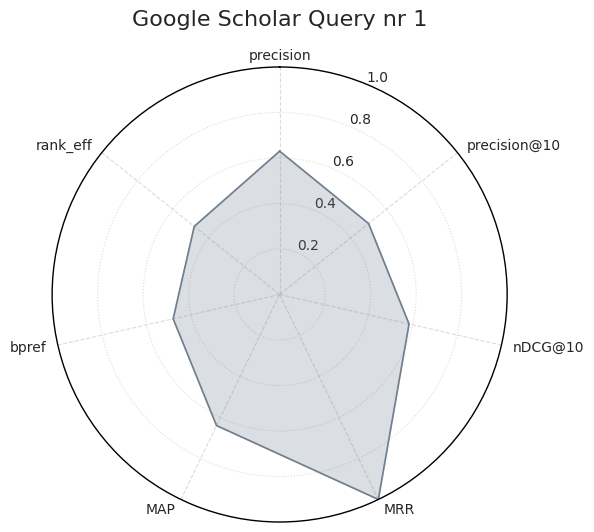

In [156]:
scholar_q1_results_fig = plot_ir_metrics_radar(scholar_q1_results_dct, title='Google Scholar Query nr 1')

##### 1.4.3.2. Query 2

In [144]:
print(bool_query_2)

architecture AND NLP AND ML


###### **CHECK THE GROUND TRUTH**

In [153]:
googscholar_results_2_df[['gsrank', 'pub_url', 'title', 'abstract']].values[80:100]

array([[81,
        'https://www.researchgate.net/profile/Thiemo-Wambsganss/publication/339140733_Unlocking_Transfer_Learning_in_Argumentation_Mining_A_Domain-Independent_Modelling_Approach/links/5e42b8f7458515072d91cf97/Unlocking-Transfer-Learning-in-Argumentation-Mining-A-Domain-Independent-Modelling-Approach.pdf',
        'Unlocking Transfer Learning in Argumentation Mining: A Domain-Independent Modelling Approach.',
        'Mining and the application of NLP and ML to the scope of  architecture is uniquely suited  to act as a unified, domain-agnostic, and easyto-develop solution for AM, due to its architectural'],
       [82, 'https://onlinelibrary.wiley.com/doi/abs/10.1002/int.22529',
        'Hybrid sequence‐based Android malware detection using natural language processing',
        'detection system that leverages NLP and ML techniques. Word  DySign 42 utilizes an  advanced NLP method to  Neural Network (RNN) architecture. LSTM networks improve the'],
       [83, 'https://ieeexp

In [154]:
google_scholar_results_gt_2 = {
    "https://ieeexplore.ieee.org/abstract/document/4668138/": False,  # "architectural concerns" refers to software architecture.
    "https://link.springer.com/chapter/10.1007/978-3-642-14706-7_20": False,  # Not about buildings; software-focused architecture.
    "https://ieeexplore.ieee.org/abstract/document/9762315/": False,  # Neural architecture search; unrelated to building architecture.
    "https://dl.acm.org/doi/abs/10.1145/3386723.3387897": False,  # Healthcare chatbot; no building architecture.
    "https://link.springer.com/article/10.1186/s40537-022-00603-5": False,  # Cloud infrastructure layers; no architectural design of buildings.
    "https://link.springer.com/protocol/10.1007/978-1-4939-0847-9_16": False,  # Biomedicine NLP; no architecture in the AEC sense.
    "https://ieeexplore.ieee.org/abstract/document/10081336/": False,  # MLOps; architecture in software systems.
    "https://theses.hal.science/tel-03411393/": False,  # Systems design decomposition; not building architecture.
    "https://ieeexplore.ieee.org/abstract/document/10159173/": False,  # Instruction set architecture; no relation to buildings.
    "https://www.mdpi.com/2076-3417/14/23/11206": False,  # NLP models and fusion; not about architectural design of buildings.
    "https://dl.acm.org/doi/abs/10.1145/3494523": False,  # Computer architecture and systems; software domain.
    "https://ieeexplore.ieee.org/abstract/document/9328431/": False,  # Software/system design decisions; unrelated to buildings.
    "https://link.springer.com/article/10.1007/11517-021-02399-7": False,  # Prognosis prediction in medicine; no building architecture.
    "https://ieeexplore.ieee.org/abstract/document/8594541/": False,  # NLP and ML systems in Arabic context; not about building architecture.
    "https://dl.acm.org/doi/abs/10.1145/3555776.3577844": False,  # Recommendation systems; not related to built architecture.
    "https://www.igi-global.com/chapter/natural-language-processing-nlp-in-chatbot-design/344253": False,  # Chatbot NLP architecture; not architectural design.
    "https://ieeexplore.ieee.org/abstract/document/9724298/": False,  # Malware detection; architecture in computing.
    "https://aclanthology.org/2020.emnlp-demos.6/": False,  # NLP tools and transformers; no building architecture.
    "https://ieeexplore.ieee.org/abstract/document/9909310/": False,  # NER for low-resource languages; not AEC.
    "https://arxiv.org/abs/1910.03771": False,  # Huggingface Transformers; no mention of architectural design (buildings).

    "https://ieeexplore.ieee.org/abstract/document/9461344/": False,  # SEO-focused; irrelevant to architectural design of buildings.
    "https://www.jmir.org/2021/5/e15708/": False,  # Mental health; not about architectural design.
    "https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4251017": False,  # Fake news detection; unrelated to building design.
    "https://academic.oup.com/jamia/article-abstract/23/6/1077/2399248": False,  # Cancer case detection; unrelated to AEC or architectural design.
    "https://hrcak.srce.hr/clanak/391375": False,  # Turkish NLP and BERT; no connection to building design.
    "https://link.springer.com/article/10.1007/s11277-023-10312-8": False,  # Smart cities in general, but not architectural design per se.
    "https://link.springer.com/article/10.1007/s00799-023-00359-0": False,  # Peer review meta-analysis; not related to architecture.
    "https://ieeexplore.ieee.org/abstract/document/8986173/": False,  # Semantic web assistant; no mention of buildings.
    "https://www.researchgate.net/profile/Vinutha-Ms/publication/369039446_Insights_into_Search_Engine_Optimization_using_Natural_Language_Processing_and_Machine_Learning/links/643e1edae881690c4be0722a/Insights-into-Search-Engine-Optimization-using-Natural-Language-Processing-and-Machine-Learning.pdf": False,  # SEO again; no AEC relevance.
    "https://aclanthology.org/W15-1515.pdf": False,  # General NLP pipeline; not about architectural design of buildings.
    "https://www.sciencedirect.com/science/article/pii/S0010482523001142": False,  # Healthcare EHR decision-making; no relevance to architecture.
    "https://ascelibrary.org/doi/abs/10.1061/JAEIED.AEENG-1516": True,  # ✅ Uses NLP and ML for **building maintenance** tasks, closely related to architectural domain.
    "https://link.springer.com/chapter/10.1007/978-981-13-3459-7_3": False,  # General DL methods; not AEC-specific.
    "https://dl.acm.org/doi/abs/10.1145/3216122.3216173": False,  # Chatbot for pregnancy support; not building design.
    "https://medinform.jmir.org/2019/2/e12109": False,  # Stroke prediction from radiology reports; not architectural design.
    "https://www.sciencedirect.com/science/article/pii/S0166361520305558": False,  # News knowledge graph platform; no AEC.
    "https://www.academia.edu/download/53591563/IRJET-V4I5611.pdf": False,  # Bank chatbot; unrelated to architecture.
    "https://www.mdpi.com/2075-4426/10/4/286": False,  # Stroke outcome prediction; no relation to AEC or architectural design.
    "https://link.springer.com/chapter/10.1007/978-3-319-41754-7_33": False,  # General DL for NLP; not building architecture.
    "https://link.springer.com/chapter/10.1007/978-3-030-79778-2_1": False,  # Twitter sentiment analysis; NLP+ML in social media.

    "https://www.academia.edu/download/99630804/77462.pdf": False,  # Privacy in cloud NLP architecture; not building design.
    "https://ieeexplore.ieee.org/abstract/document/10114393/": False,  # Railway safety in enterprise architecture; not architectural design.
    "https://academic.oup.com/jamia/article-abstract/17/5/507/830823": False,  # Clinical NLP system; not related to buildings.
    "https://pmc.ncbi.nlm.nih.gov/articles/PMC3243235/": False,  # Clinical QA system; unrelated.
    "https://journals.sagepub.com/doi/abs/10.3233/IDT-230682": False,  # Smart document storage system; no connection to architectural design.
    "https://acrjournals.onlinelibrary.wiley.com/doi/abs/10.1002/acr.22324": False,  # Gout detection from clinical notes; irrelevant.
    "https://ieeexplore.ieee.org/abstract/document/8791212/": False,  # Peer review prediction; not about buildings.
    "https://www.sciencedirect.com/science/article/pii/S0957417422020255": False,  # Mental health text detection; no connection to buildings.
    "https://arxiv.org/abs/2404.11788": False,  # NLP workloads benchmark; not about building architecture.
    "https://books.google.com/books?hl=en&lr=&id=QAIaEAAAQBAJ&oi=fnd&pg=PP1": False,  # General NLP book (TensorFlow); not building design.
    "https://nlp.lsi.upc.edu/publications/papers/atserias06.pdf": False,  # Open-source NLP library; not architectural design.
    "https://www.sciencedirect.com/science/article/pii/S0895796723000509": False,  # Healthcare disparities; irrelevant.
    "https://link.springer.com/article/10.1007/s10639-024-12919-1": False,  # Education and misconceptions; not AEC.
    "https://ieeexplore.ieee.org/abstract/document/9411584/": False,  # Job recommendation; not about buildings.
    "https://link.springer.com/article/10.1007/s00167-022-07272-0": False,  # Orthopedics; not architectural design.
    "https://www.sciencedirect.com/science/article/pii/S2590188519300010": False,  # NFR classification; not AEC-related.
    "https://academic.oup.com/jamia/article-abstract/15/1/40/780188": False,  # NLP for smoking info; healthcare focused.
    "https://www.sciencedirect.com/science/article/pii/S1876034124000194": False,  # IoMT and healthcare; unrelated to architecture.
    "https://link.springer.com/chapter/10.1007/978-3-031-37189-9_7": True,  # ✅ Explicitly on *architectural design* using NLP and GPT-based methods.
    "https://arxiv.org/abs/2409.18568": False,  # Chatbot architecture; customer service focused.

    "https://www.sciencedirect.com/science/article/pii/S1359644620300465": False,  # Drug discovery; not AEC.
    "https://ieeexplore.ieee.org/abstract/document/10073224/": False,  # E-commerce product recommendation; irrelevant.
    "https://www.mdpi.com/2673-2688/4/1/4": False,  # Transformer overview; no building design.
    "https://www.mdpi.com/2504-4990/1/1/31": False,  # Speaker recognition system; not building architecture.
    "https://www.scirp.org/journal/paperinformation?paperid=122466": False,  # Word embeddings; general NLP.
    "https://ieeexplore.ieee.org/abstract/document/10475864/": False,  # Chatbot generator; not AEC.
    "https://ieeexplore.ieee.org/abstract/document/9651825/": False,  # Peer review summarization; not related.
    "https://www.mdpi.com/2673-2688/4/3/35": False,  # Arabic chatbot; no building design.
    "https://arxiv.org/abs/2104.10350": False,  # Emissions from training NLP models; not relevant.
    "https://www.mdpi.com/2078-2489/15/9/517": False,  # RNNs in general ML; not architecture (AEC).
    "https://www.mdpi.com/2673-2688/4/1/15": False,  # Radiotherapy chatbot; medical, not architectural design.
    "https://aclanthology.org/W12-0513.pdf": False,  # Hybrid NLP architecture; unrelated.
    "https://link.springer.com/chapter/10.1007/978-3-030-34706-2_9": False,  # Cognitive services for KM; not AEC.
    "https://bia.unibz.it/esploro/outputs/conferenceProceeding/An-Architecture-independent-Data-Model-for-Managing/991005772233501241": False,  # Chatbot data model; irrelevant.
    "https://dl.acm.org/doi/abs/10.1145/3644815.3644962": False,  # Green ML infrastructure; “architectural design” here refers to systems architecture.
    "https://books.google.com/books?hl=en&lr=&id=nvBZDwAAQBAJ&oi=fnd&pg=PP1": False,  # Cloud ML book; general topic.
    "https://ojs.aaai.org/index.php/AAAI-SS/article/view/31176": False,  # Neuro-symbolic architecture; not AEC.
    "https://ieeexplore.ieee.org/abstract/document/10361465/": False,  # Vehicular edge computing; no link to building design.
    "https://ieeexplore.ieee.org/abstract/document/10763160/": False,  # Business architecture (organizational); not building design.
    "https://ieeexplore.ieee.org/abstract/document/10762957/": False,  # Finance chatbot; nothing about AEC.

    "https://www.researchgate.net/.../Unlocking-Transfer-Learning-in_Argumentation_Mining...": False,  # Argumentation mining; "architecture" is used abstractly.
    "https://onlinelibrary.wiley.com/doi/abs/10.1002/int.22529": False,  # Android malware detection.
    "https://ieeexplore.ieee.org/abstract/document/9498508/": False,  # Conversational AI; general.
    "https://ieeexplore.ieee.org/abstract/document/10140214/": False,  # Chatbot comparison; general NLP/ML.
    "https://link.springer.com/chapter/10.1007/978-981-15-7106-0_26": False,  # Software requirements; unrelated to building design.
    "https://www.sciencedirect.com/science/article/pii/S2772442522000326": False,  # NLP for COVID-19 research.
    "https://core.ac.uk/download/pdf/578162515.pdf": False,  # GRU self-attention architecture; general NLP.
    "https://ieeexplore.ieee.org/abstract/document/9691740/": False,  # Web application security via SQL injection defense.
    "https://dl.acm.org/doi/abs/10.1145/3434237": False,  # Survey on word representations; no AEC link.
    "https://www.sciencedirect.com/science/article/pii/S147403462100224X": False,  # ❗Almost—mentions BIM + ML, but **no NLP in the abstract** (was marked False in earlier query too).
    "https://openaccess.thecvf.com/content/WACV2023/html/Ridnik_ML-Decoder...": False,  # Classification head; ML systems, not AEC.
    "https://ieeexplore.ieee.org/abstract/document/10859010/": False,  # Emotion classification using BERT + CNN; unrelated to architecture.
    "https://www.sciencedirect.com/science/article/pii/S0957417424029105": False,  # Fake news detection; no architectural design context.
    "https://ieeexplore.ieee.org/abstract/document/9331989/": False,  # NER in Indonesian; general NLP.
    "https://www.sciencedirect.com/science/article/pii/S2667276624000143": False,  # Healthcare chatbot.
    "https://www.sciencedirect.com/science/article/pii/S0030402622015674": False,  # Fintech & DRL; unrelated.
    "https://academic.oup.com/jamiaopen/article-abstract/7/2/ooae034/7668532": False,  # Disease surveillance—explicitly states **no NLP or ML implemented**.
    "https://bia.unibz.it/esploro/outputs/.../Using-Language-Learner-Data-for-Metaphor-Detection...": False,  # Language learning & metaphor detection; not AEC.
    "https://ceur-ws.org/Vol-3723/paper9.pdf": False,  # Linguistic system for Ukrainian language; no building design.
    "https://link.springer.com/article/10.1007/s12039-021-01995-2": False  # ML for chemical sciences.
}

###### **COMPUTE METRICS**


In [157]:
scholar_q2_results_dct = compute_ir_metrics(gt_dict=OrderedDict(google_scholar_results_gt_2.items()), experiment_name='scholar_q2', k=10)
print(scholar_q2_results_dct)

{'experiment': 'scholar_q2', 'precision': 0.02, 'precision@10': 0.0, 'nDCG@10': 0.0, 'MRR': 0.03125, 'MAP': 0.03257415254237288, 'bpref': 0.5510204081632653, 'rank_eff': 0.5510204081632653}


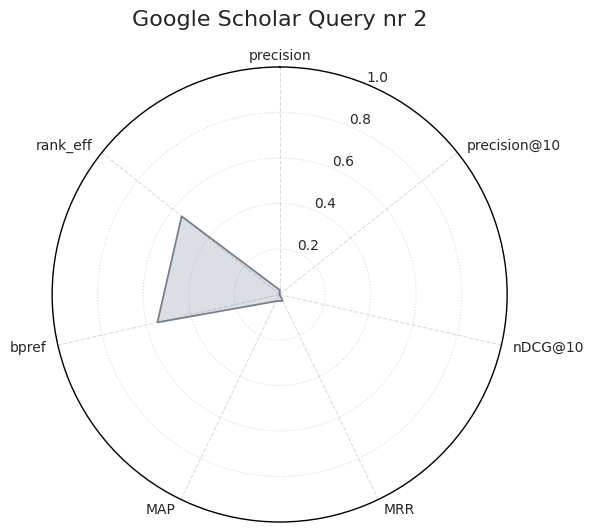

In [158]:
scholar_q2_results_fig = plot_ir_metrics_radar(scholar_q2_results_dct, title='Google Scholar Query nr 2')

##### 1.4.3.3. Query 3

In [159]:
print(bool_query_3)

architecture AND participation AND (NLP OR "machine learning")


###### **CHECK THE GROUND TRUTH**

In [164]:
googscholar_results_3_df[['gsrank', 'pub_url', 'title', 'abstract']].values[80:100]

array([[81, 'https://ieeexplore.ieee.org/abstract/document/5370818/',
        'Participatory sensing: applications and architecture [internet predictions]',
        'In addition, as UCSD’s Tajana Rosing has shown, we can use machine learning to implement  various power2 or thermal3 management approaches, each of which can save up to 70'],
       [82, 'https://ieeexplore.ieee.org/abstract/document/9046765/',
        'A secure ai-driven architecture for automated insurance systems: Fraud detection and risk measurement',
        'architecture based on AI and blockchain technologies. In Section IV, we describe the AI  modules including the machine learning  ) with trusted node participants authorized by military or'],
       [83, 'https://ieeexplore.ieee.org/abstract/document/8827509/',
        'Efficient privacy-preserving machine learning for blockchain network',
        'We describe this architecture minutely step by step which are  without synchronization with  other participants. The 

In [165]:
google_scholar_results_gt_3 = {
    'https://dl.acm.org/doi/abs/10.1145/3551624.3555285': True,  # Discusses ML, participation, and architecture/urban planning practices.
    'https://link.springer.com/chapter/10.1007/978-3-031-37189-9_18': True,  # Applies NLP (topic modeling) to public participation in urban design processes.
    'https://docserv.uni-duesseldorf.de/servlets/DerivateServlet/Derivate-69813/Diss_pdf2_1b__print_final.pdf': True,  # Evaluates ML models on public participation documents; architectural context implied.
    'https://ieeexplore.ieee.org/abstract/document/10534749/': False,  # Enterprise architecture assistant; not building design.
    'https://dergipark.org.tr/en/pub/opusjsr/article/1122785': True,  # Uses ML to assess public opinion on an architectural project; participatory aspect is present.
    'https://www.mdpi.com/2411-9660/3/3/32': False,  # Smart home NLP interface; unrelated to participatory design.
    'http://ir.bdu.edu.et/bitstream/handle/123456789/12651/Meba%20Thesis.pdf?sequence=1&isAllowed=y': False,  # Talks about software pattern selection; not relevant to participatory architectural design.
    'https://dl.acm.org/doi/abs/10.1145/3494523': False,  # Survey on ML in computer architecture, not relevant.
    'https://arxiv.org/abs/2308.05239': False,  # ML software framework paper; participation mentioned only in recruitment process.
    'https://pmc.ncbi.nlm.nih.gov/articles/PMC5001745/': False,  # Clinical NLP system; not related to architectural design or participatory design.
    'https://link.springer.com/article/10.1007/s43615-021-00079-0': True,  # Combines public participation, participatory design, and NLP to support circular economy — includes architecture angle.
    'https://link.springer.com/chapter/10.1007/978-3-642-14706-7_20': False,  # Uses “e-participation analysis architecture” in malware analysis — no architectural design context.
    'https://www.researchgate.net/profile/Saifeldin-Ahmed/publication/340924314_An_Architecture_for_Dynamic_Conversational_Agents_for_Citizen_Participation_and_Ideation/links/5ea462e392851c1a906f19ca/An-Architecture-for-Dynamic-Conversational-Agents-for-Citizen-Participation-and-Ideation.pdf': True,  # Conversational agents for citizen participation; mentions architecture and ML.
    'https://www.mdpi.com/2075-5309/14/12/3901': False,  # Cognitive framework for urban color assessment; participant survey not about participatory design process.
    'https://link.springer.com/chapter/10.1007/978-3-030-82824-0_10': True,  # Uses NLP/ML for citizen idea classification; in a government/public participation context.
    'https://journals.sagepub.com/doi/abs/10.1177/0163443718754648': False,  # Branding and social media, not about architectural design.
    'https://arxiv.org/abs/2302.06716': False,  # ML attribution benchmark; participants involved in benchmarking task only.
    'https://www.emerald.com/insight/content/doi/10.1108/ecam-01-2024-0134/full/html': False,  # About infrastructure finance; not architectural design nor participatory.
    'https://www.sciencedirect.com/science/article/pii/S0010482521003668': False,  # COVID cough classification; unrelated.
    'https://www.tandfonline.com/doi/abs/10.1080/00038628.2023.2278500': True,  # Comparative analysis of aesthetic judgments for building designs using ML and human participants.

    'http://www.lrec-conf.org/proceedings/lrec2014/pdf/775_Paper.pdf': False,  # Describes the IXA NLP pipeline; mentions participation in shared tasks, not related to architectural design.
    'https://staff.ru.is/hrafn/papers/SLTC_ICALL_architecture.pdf': False,  # About system architecture for CALL using NLP components; not related to building design or participatory processes.
    'https://academic.oup.com/jamia/article-abstract/17/5/507/830823': False,  # NLP system (cTAKES) for clinical text analysis; participation here refers to clinical tasks, not design.
    'https://ceur-ws.org/Vol-2936/paper-96.pdf': False,  # Participation in a shared NLP evaluation task; no connection to architecture or participatory design.
    'https://ieeexplore.ieee.org/abstract/document/9311906/': False,  # Federated ML overview; mentions participation of devices, not related to architectural or participatory design.
    'https://aisel.aisnet.org/pacis2024/track16_shareecon/track16_shareecon/6/': True,  # Analyzes citizens’ input from e-participation in urban planning using ML; matches both participatory architecture and ML criteria.
    'https://ieeexplore.ieee.org/abstract/document/6108265/': False,  # Chat assessment using NLP in educational contexts; uses term "participation paradigm" unrelated to architectural design.
    'https://dl.acm.org/doi/abs/10.1145/3613372.3613405': False,  # Runtime architecture evolution via NLP; mentions participants in a usability test, not participatory design.
    'https://link.springer.com/chapter/10.1007/978-3-319-07443-6_42': True,  # Mentions “architecture of participation” in lightweight text analytics; relevant framing of NLP tools enabling participation, though not strictly in architectural design.
    'https://www.academia.edu/download/84403995/paper16.pdf': False,  # Participation in CL-SciSumm challenge by NLP team; not design or architecture related.
    'https://ieeexplore.ieee.org/abstract/document/8501533/': False,  # Overview of ML in network automation; not related to participatory design or built environment.
    'https://ieeexplore.ieee.org/abstract/document/9251903/': False,  # ML model for education data; participation refers to online activity, no connection to architectural participation.
    'https://ceur-ws.org/Vol-1737/T6-5.pdf': False,  # NLP system participation in a FIRE shared task; no architectural or participatory design relevance.
    'https://dl.acm.org/doi/abs/10.1145/3501813': False,  # FL in healthcare; "participant" refers to FL clients, not citizen participation in design.
    'https://dl.acm.org/doi/abs/10.1145/3491102.3502004': False,  # Jury learning integrates dissent in ML models; mentions users as participants, but no link to architecture.
    'https://link.springer.com/chapter/10.1007/978-3-030-27325-5_18': True,  # Case study on applying BERT/NLP to citizen participation in German government; strong participatory architecture connection.
    'https://ieeexplore.ieee.org/abstract/document/10782799/': False,  # In-home activity recognition using ML; unrelated to participation in architectural design.
    'https://www.sciencedirect.com/science/article/pii/S0952197624010923': False,  # TIoT in 6G with federated learning; participation is about system clients, not citizens or users.
    'https://ieeexplore.ieee.org/abstract/document/9347454/': False,  # Federated ML with client selection; "participating clients" not related to design participation.
    'https://arxiv.org/abs/2204.13291': False,  # Architecture patterns for FL; participation again refers to computing clients, not humans in architectural processes.

    'https://link.springer.com/article/10.1007/s10115-025-02356-y': False,  # Discusses vertical federated learning architectures, but participation refers to data holders—not design-related.
    'https://ieeexplore.ieee.org/abstract/document/10711084/': False,  # MLOps architecture with project participants; "participation" is generic and not related to participatory design.
    'https://gnosis.library.ucy.ac.cy/handle/7/65614': True,  # Explores ML in parametric architectural design and explicitly mentions user participation in the design process.
    'https://ceur-ws.org/Vol-2125/paper_108.pdf': False,  # Describes participation in an NLP challenge (CLEF); not related to architectural design or citizen participation.
    'https://www.sciencedirect.com/science/article/pii/S1389128622003929': False,  # Zero trust network architecture; participation is technical, not design-related.
    'https://e-space.mmu.ac.uk/id/eprint/632688': True,  # Duplicate of #43 — focuses on rethinking architectural design using ML with user participation.
    'https://dl.acm.org/doi/abs/10.1145/3613904.3642109': False,  # Discussion of model compression and developer practices; participation refers to ML practitioners, not citizens.
    'https://library.iated.org/view/SALVATIERRATUMBACO2022IMA': True,  # Describes a case study where students participate in ML-based game design for architecture—partially relevant to participatory design.
    'https://ceur-ws.org/Vol-3497/paper-126.pdf': False,  # Participation in CLEF shared task; not about design or architectural participation.
    'https://journals.sagepub.com/doi/abs/10.1177/0956797620948810': False,  # Psychology study on color-emotion associations; participants refer to survey respondents, not participatory architecture.
    'https://ieeexplore.ieee.org/abstract/document/9177002/': False,  # ML in SDN architecture for cyber security; irrelevant to participatory design or architecture.
    'https://search.ebscohost.com/login.aspx?...': False,  # Talks about landscape architecture and NLP for environmental projects; participation is procedural, not participatory design-focused.
    'https://ieeexplore.ieee.org/abstract/document/10164759/': False,  # Discusses ML in software architecture frameworks; not about built environment or participatory design.
    'https://www.osti.gov/servlets/purl/1830908': False,  # Panel on compiler architecture participation; technical domain, not related to participatory building design.
    'https://ieeexplore.ieee.org/abstract/document/10530788/': False,  # Spam email detection using ML; mentions participants in an experiment—unrelated to architectural design.
    'https://ascelibrary.org/doi/abs/10.1061/(ASCE)ME.1943-5479.0000774': True,  # Smart city digital twins using ML and semantic modeling; mentions "participating domains," but relevant in architectural/urban modeling context.
    'https://research.rug.nl/en/publications/guiding-principles-for-participatory-design-inspired-natural-lang': True,  # Directly discusses participatory design approaches in NLP—core relevance.
    'http://web2py.iiit.ac.in/research_centres/publications/download/inproceedings.pdf...': False,  # System performance paper; mentions participation of NLP experts, not design-related.
    'https://arxiv.org/abs/1807.06557': False,  # Neural architecture to analyze social power in NLP datasets; participants refer to conversation agents, not humans in design.
    'https://www.sciencedirect.com/science/article/pii/S1383762120302071': False,  # Focuses on privacy-preserving frameworks for IoT and smart cities; participation is about devices, not humans in design.

    'https://ieeexplore.ieee.org/abstract/document/9675916/': False,  # Emergency management system architecture; "participation" refers to NGOs, not architectural design.
    'https://ebrary.net/186817/education/artificial_intelligence_machine_learning_landscape_architecture': True,  # Landscape architecture with participatory mapping using ML; relevant to participatory design.
    'https://pubsonline.informs.org/doi/abs/10.1287/mnsc.1060.0546': False,  # Software architecture in open-source coding; "architecture of participation" is metaphorical.
    'https://policycommons.net/artifacts/15829010/...': False,  # Software project metrics and ML; participation refers to developers, not participatory design.
    'https://link.springer.com/article/10.1007/s00607-024-01353-3': False,  # Fog computing architecture; participation refers to ML tasks/devices, not people.
    'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5068532': False,  # Predictive data architecture with generic reference to participants; not design-related.
    'https://ieeexplore.ieee.org/abstract/document/10839980/': False,  # Federated learning software architecture; participation is from organizations, not citizens.
    'https://ieeexplore.ieee.org/abstract/document/8424791/': False,  # Education-related NLP/ML system for forum discussion; participation is in online courses, not built environment.
    'https://link.springer.com/article/10.1007/s13042-025-02536-w': True,  # Landscape architecture and AI/ML tools with mention of public participation—relevant to participatory urban design.
    'https://www.biorxiv.org/content/10.1101/2022.10.24.513462.abstract': False,  # Visual illusion study; participation refers to test subjects, not design process.
    'https://arxiv.org/abs/2407.09818': False,  # NLP competition (AraFinNlp); "participants" are teams in the challenge—unrelated.
    'https://ieeexplore.ieee.org/abstract/document/8812912/': False,  # Software dev study on ML projects; participation refers to developers on GitHub.
    'https://iris.unito.it/bitstream/2318/1901536/1/paper1-annotated.pdf': True,  # Combines BIM and NLP for architectural design processes; relevant to participatory AEC workflows.
    'https://link.springer.com/chapter/10.1007/978-3-030-52584-2_5': True,  # Evaluates architectural designs using ML; acknowledges human participants—related to participatory evaluation.
    'https://scholar.archive.org/.../ecaade2018_176.pdf': True,  # Directly explores ML methods for participatory architectural design through opinion-based workflows.
    'https://link.springer.com/article/10.1186/s41239-022-00336-8': True,  # ePortfolio in architectural pedagogy; integrates NLP and participation in learning contexts—educationally participatory.
    'https://ieeexplore.ieee.org/abstract/document/10893114/': True,  # Sentiment analysis in architectural design studio critique; directly relates to participatory feedback in design education.
    'https://www.researchgate.net/.../Query_Expansion_Based_on_NLP_and_Word_Embeddings': False,  # Participation in an NLP evaluation challenge; unrelated to design participation.
    'https://www.sciencedirect.com/science/article/pii/S0142061521005433': False,  # Power plant energy markets; participation is market-based, not design-related.
    'https://proceedings.mlsys.org/.../7b770da633baf74895be22a8807f1a8f-Abstract.html': False,  # Federated learning system design; participation refers to devices or clients, not human stakeholders.


    'https://ieeexplore.ieee.org/abstract/document/5370818/': False,  # "Participatory sensing" is a computing paradigm unrelated to participatory architectural design.
    'https://ieeexplore.ieee.org/abstract/document/9046765/': False,  # Insurance system architecture with ML; participation relates to system nodes, not humans in design.
    'https://ieeexplore.ieee.org/abstract/document/8827509/': False,  # Privacy-preserving ML with blockchain; participation is about distributed parties, not citizen involvement in architecture.
    'https://www.sciencedirect.com/science/article/pii/S0045790624009522': False,  # Vehicular network architecture; participation refers to nodes and security, not human interaction or design.
    'https://onlinelibrary.wiley.com/doi/abs/10.1002/9781119815075.ch16': True,  # Directly about participatory design in architecture; aligned with query goals.
    'https://ceur-ws.org/Vol-3756/EmoSPeech2024_paper10.pdf': False,  # Emotion detection task in NLP; participation refers to competition participants, not design.
    'https://ieeexplore.ieee.org/abstract/document/9422544/': False,  # Smart building energy prediction via FL; participation is about training participants (devices or data nodes).
    'https://www.jmir.org/2023/1/e48498/': True,  # Participatory research in NLP explored explicitly; includes community involvement—relevant to the spirit of participatory design.
    'https://arxiv.org/abs/1909.05125': False,  # FL with Byzantine-robust averaging; participation = clients in training, not human co-designers.
    'https://search.proquest.com/openview/...diss=y': False,  # Neurocomputational architecture of anxiety; participation is experimental subjects, not participatory design.
    'https://arxiv.org/abs/2106.07385': False,  # NLP task challenge; participation is by NLP system teams, not human users/designers.
    'https://www.sciencedirect.com/science/article/pii/S0893608012000457': False,  # Traffic sign recognition benchmarking; participation = test users, not participatory design or architecture.
    'https://www.sciencedirect.com/science/article/pii/S0736585323000965': True,  # Citizen-centric digital twin with ML interfaces; supports participatory urban design—relevant.
    'https://dl.acm.org/doi/abs/10.1145/3173574.3173580': False,  # Voice UI error handling; NLP-related but no connection to architecture or participatory methods.
    'https://dl.acm.org/doi/abs/10.1145/3298981': False,  # Overview of federated learning; participation is technical (nodes or clients).
    'https://odr.chalmers.se/items/df37f1cc-bbb7-4099-8b86-e30674b0ed9b': False,  # Software architecture decisions in ML systems; no link to participatory processes.
    'https://www.mdpi.com/2076-3417/12/6/3130': False,  # FL for question answering; participation = training nodes/users, not relevant to built environment design.
    'https://www.sciencedirect.com/science/article/pii/S0950705121000381': False,  # General survey on FL; participation is algorithmic/distributed training context.
    'No publication URL available': False,  # No way to evaluate; insufficient information.
    'https://fdl.ai/s/Foundational-architecture-enabling-federated-learning.pdf': False,  # FL for space ML; participants are compute nodes, no design-related participation.

}

###### **COMPUTE METRICS**


In [166]:
scholar_q3_results_dct = compute_ir_metrics(gt_dict=OrderedDict(google_scholar_results_gt_3.items()), experiment_name='scholar_q3', k=10)
print(scholar_q3_results_dct)

{'experiment': 'scholar_q3', 'precision': 0.26, 'precision@10': 0.4, 'nDCG@10': 0.5541432109622958, 'MRR': 1.0, 'MAP': 0.41388414153078884, 'bpref': 0.5675675675675674, 'rank_eff': 0.5675675675675675}


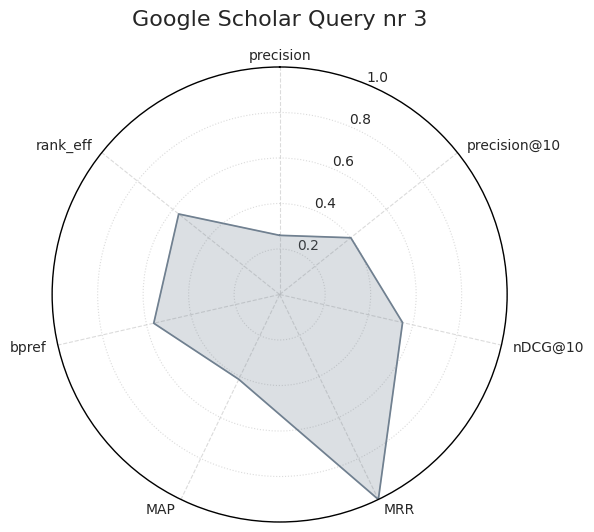

In [167]:
scholar_q3_results_fig = plot_ir_metrics_radar(scholar_q3_results_dct, title='Google Scholar Query nr 3')

##### 1.4.3.4. Query 4

In [168]:
print(bool_query_4)

architecture AND theory AND "natural language processing"


###### **CHECK THE GROUND TRUTH**

In [173]:
googscholar_results_4_df[['gsrank', 'pub_url', 'title', 'abstract']].values[80:100]

array([[81, 'https://ieeexplore.ieee.org/abstract/document/9747675/',
        'The dawn of quantum natural language processing',
        'In this paper, we discuss the initial attempts at boosting understanding human language  based on deep-learning models with quantum computing. We successfully train a quantum-'],
       [82,
        'https://www.sciencedirect.com/science/article/pii/S0950705111002759',
        'Functional grouping of natural language requirements for assistance in architectural software design',
        'This position paper concludes that natural language processing is mature enough to be  applied to ontology extraction in the context of requirements engineering, in spite of a necessary'],
       [83,
        'https://books.google.com/books?hl=en&lr=&id=IedDDwAAQBAJ&oi=fnd&pg=PP1&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=ndHQks-In7&sig=Jw1ZEUFQaBdofQ4XH6q_fg-sk4s',
        'Python natural language processing',
        'of the rule-based sys

In [176]:
google_scholar_results_gt_4 = {
    'https://link.springer.com/protocol/10.1007/978-1-4939-0847-9_16': False,  # System architecture for biomedical NLP – no link to architectural theory.
    'https://www.tandfonline.com/doi/abs/10.1080/09588221.2010.520674': False,  # NLP system for language tutors – "architecture" is computational only.
    'https://academic.oup.com/jamia/article-abstract/18/5/544/829676': False,  # Intro to NLP in medical context – no connection to architectural theory.
    'https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=60bd7be839be62cdcd0cef59daf6d51beca272a2': False,  # Cognitive model of NLP – no architectural theory.
    'https://escholarship.org/uc/item/08x8z99x': False,  # Massively-parallel NLP architecture – again, not architectural theory.
    'https://books.google.com/books?hl=en&lr=&id=vuLTBwAAQBAJ&oi=fnd&pg=PR11&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=azjH6ToRTI&sig=nNgDMv4yGGVXWTldlm9cirlwUa4': False,  # Theoretical NLP linguistics – not architecture in the sense of built environment.
    'https://www.academia.edu/download/30215692/nlpsystemarchitecture_update.pdf': False,  # Computational architecture – linguistic but not architectural design theory.
    'https://www.sciencedirect.com/science/article/pii/B9780123042606500049': False,  # System architecture again, focused on computational linguistics.
    'https://aclanthology.org/C88-2165.pdf': False,  # Multi-agent NLP processing – unrelated to architectural theory.
    'https://link.springer.com/chapter/10.1007/978-81-322-3972-7_19': False,  # NLP overview chapter – too general.
    'https://books.google.com/books?hl=en&lr=&id=N8qwt-59H0AC&oi=fnd&pg=PP1&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=eDCsZdF9vH&sig=BueMJP0JDWM14sXv1b28vHtXRXI': False,  # Paninian linguistic theory – about linguistic structure, not built architecture.
    'https://www.taylorfrancis.com/books/mono/10.4324/9781315636863/connectionist-approaches-natural-language-processing-reilly-noel-sharkey': False,  # Connectionist models for NLP – neural and cognitive, not architectural design.
    'https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog2304_2': False,  # Connectionist NLP, speech focus – not relevant to architectural theory.
    'https://books.google.com/books?hl=en&lr=&id=Za2zDgAAQBAJ&oi=fnd&pg=PP2&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=7DvH_j4hhY&sig=UdlaDSEmtiMA1JayntidHdEuLqc': False,  # Neural NLP methods – no link to architecture as design.
    'https://www.science.org/doi/abs/10.1126/science.aaa8685': False,  # General NLP advances – doesn't engage with architectural theory.
    'https://books.google.com/books?hl=en&lr=&id=U90MEAAAQBAJ&oi=fnd&pg=PP2&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=rw6k3z3fbC&sig=aylTBWSV2KYWgmIbT2UBfHqZAxs': False,  # Theoretical, but only about NLP vector representations.
    'https://users.soe.ucsc.edu/~michaelm/tenurereview/publications/mateas-tidse2003.pdf': False,  # Narrative systems + shallow NLP – some architectural metaphors, but not related to architectural theory.
    'https://books.google.com/books?hl=en&lr=&id=wNnPEAAAQBAJ&oi=fnd&pg=PT24&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=SXIPl6tt5q&sig=zYBi48MyTgXL7r5EmO5efatgth8': False,  # Teaching deep learning including NLP – general and technical.
    'https://books.google.com/books?hl=en&lr=&id=72yuDwAAQBAJ&oi=fnd&pg=PR5&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=gX8L55Ydq0&sig=NAkZ4evwUsnlEkuU1xi2vohLdmw': False,  # Intro to NLP – useful background but no connection to built environment or architectural theory.
    'https://ieeexplore.ieee.org/abstract/document/6786458/': False,  # NLP trends review – architectural metaphor likely refers to computational model structure, not building design.

    'https://www.scielo.br/j/rdbci/a/SqQGGdcVrL8bw5RppLJ4vpz/?lang=en': False,  # Theoretical framing of NLP data workflows; no link to architectural design theory.
    'https://www.researchgate.net/profile/Carmelo-Longo-2/publication/345670114_A_Reactive_Cognitive_Architecture_based_on_Natural_Language_Processing_for_the_task_of_Decision-Making_using_a_Rich_Semantic/links/5faa60fca6fdcc0624251e94/A-Reactive-Cognitive-Architecture-based-on-Natural-Language-Processing-for-the-task-of-Decision-Making-using-a-Rich-Semantic.pdf': False,  # Cognitive computational architecture – no connection to architectural theory.
    'https://www.sciencedirect.com/science/article/pii/S0926580522000425': False,  # NLP in construction workflows – practical, but not about architectural theory or language.
    'https://journals.sagepub.com/doi/abs/10.1177/21582440231177042': False,  # Multimodal data architecture in NLP – theoretical, but in information science context.
    'https://link.springer.com/chapter/10.1007/978-0-585-35958-8_1': False,  # Historical NLP overview – general NLP theory, no architectural design focus.
    'https://dl.acm.org/doi/abs/10.1145/366173.366190': False,  # NLP + security; not related to design or architectural theory.
    'https://www.sciencedirect.com/science/article/pii/S0959652622013361': False,  # NLP model for wind prediction – application of encoder-decoder architecture, irrelevant.
    'https://library.oapen.org/handle/20.500.12657/76271': False,  # Book on representation learning – theoretical NLP but no link to architectural theory.
    'https://link.springer.com/content/pdf/10.1007/978-3-031-79474-2.pdf': False,  # NLP + Semantic Web – again, not about architectural theory.
    'https://www.sciencedirect.com/science/article/pii/S0950705114003992': False,  # Distributed architecture for big NLP – computational infrastructure focus.
    'https://link.springer.com/chapter/10.1007/978-3-030-86523-8_41': False,  # NLP Transformer critique – interesting theoretical angle, but not architectural theory.
    'https://link.springer.com/article/10.1007/s11042-022-13428-4': False,  # NLP modular architectures – software system modularity, not relevant.
    'https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=547b6c77a78bd0c803316c20c6e66fd0676b8cea': False,  # Computational architecture for NLP – no architectural theory context.
    'https://books.google.com/books?hl=en&lr=&id=hBRDEQAAQBAJ&oi=fnd&pg=PA1&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=uAmNh-Fyv8&sig=EoTkaRVHmVpiBe8GSpsoCbWtDos': False,  # Intro book on NLP – useful for NLP, no relevance to architectural design theory.
    'https://www.sciencedirect.com/science/article/pii/S0304397522003887': False,  # Offensive language detection using ensemble ML – highly technical NLP.
    'https://ascelibrary.org/doi/abs/10.1061/(ASCE)CP.1943-5487.0000536': False,  # NLP used in BIM extension – this is close to architecture, but only via construction tech, not theory.
    'https://arxiv.org/abs/1812.09652': False,  # Binary code analysis via cross-architecture models – totally unrelated.
    'https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00577/116725': False,  # Survey of efficient NLP architectures – design of NLP models, not buildings.
    'https://link.springer.com/chapter/10.1007/978-3-319-10223-8_16': False,  # Web-based predictive editor – about NLP interface architecture.
    'https://arxiv.org/abs/cmp-lg/9702005': False,  # GATE system architecture – general NLP infrastructure, not architectural theory.

    'https://aclanthology.org/W03-0807.pdf': False,  # Focus on software engineering in NLP systems; not related to architectural theory (buildings).
    'http://gcris.etu.edu.tr:8080/handle/20.500.11851/10128': True,  # Relates NLP to managing *architectural knowledge* – this could imply architectural theory in design practice.
    'https://link.springer.com/content/pdf/10.1007/978-1-4842-3685-7.pdf': False,  # Textbook on DL for NLP – general model architecture, not architectural theory.
    'https://aclanthology.org/C14-1088.pdf': False,  # Conversational system architecture – purely NLP system design.
    'https://books.google.com/books?hl=en&lr=&id=Cr0YEAAAQBAJ&oi=fnd&pg=PP1&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=aao2YuYh14&sig=7ZalfELzMIMHG_MIwH3-EN3nJ8U': False,  # Transformer model architecture book – software/NLP models only.
    'https://www.atlantis-press.com/proceedings/agi10/1914': False,  # Artificial general intelligence + NLP system design – no architectural theory.
    'https://books.google.com/books?hl=en&lr=&id=hvrrDwAAQBAJ&oi=fnd&pg=PP1&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=gshrdu-Tif&sig=D-zSUbIuCjORM4GLrbYFV7_r5zM': False,  # Practical NLP book – mostly software/system theory.
    'https://www.academia.edu/download/7011642/10.1.1.64.7218.pdf': False,  # NLP system for scientific texts – technical NLP, not architectural theory.
    'https://ieeexplore.ieee.org/abstract/document/10159173/': False,  # Identifying instruction set architectures using NLP – not related to architecture as building or design.
    'https://dl.acm.org/doi/abs/10.1145/3663363': False,  # Multi-task NLP system architecture – no link to architectural theory.
    'https://content.iospress.com/articles/semantic-web/sw223228': False,  # Review of neuro-symbolic AI – theoretical but not related to architectural design theory.
    'https://journal.qubahan.com/index.php/qaj/article/view/44': False,  # Semantic analysis in NLP – no mention of architectural theory.
    'https://www.cambridge.org/core/journals/natural-language-engineering/article/software-architecture-for-language-engineering/CD07A5B52F888A4C3824719AAF311903': False,  # Software architecture for NLP pipelines – again, no design theory involved.
    'https://books.google.com/books?hl=en&lr=&id=HKdFDwAAQBAJ&oi=fnd&pg=PR9&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=9pwRCJoqhl&sig=UZBAfsNymh5bG_Y7PBSyo5xnRBc': False,  # Computational linguistics (semantics/discourse) – theoretical, but linguistics-oriented.
    'https://books.google.com/books?hl=en&lr=&id=-RvfDAAAQBAJ&oi=fnd&pg=PP2&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=ryVaiHM7mx&sig=eyEUcWsu30HygJ0wcp9mmE3VDQk': False,  # NLP/Computational Linguistics overview – focuses on syntax/morphology.
    'https://link.springer.com/chapter/10.1007/978-3-031-85463-7_7': False,  # NLP-based value elicitation in agents – unrelated to architectural theory of design.
    'https://link.springer.com/chapter/10.1007/11671299_34': False,  # NLP for NLP (natural language programming) – not architectural theory.
    'https://www.jmlr.org/papers/volume12/collobert11a/collobert11a.pdf?source': False,  # Foundational NN architecture for NLP tasks – not architecture in the design sense.
    'https://ieeexplore.ieee.org/abstract/document/8666928/': False,  # CNN in NLP applications – unrelated to design or theory of buildings.
    'https://aclanthology.org/O97-4003.pdf': False,  # Segmentation standard in Chinese NLP – linguistically focused, not architectural theory.

    'https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=b3c81b523b1f03c87192aa2abbf9ffb81a143e54': False,  # Software system architecture.
    'https://www.nature.com/articles/s42003-022-03036-1': False,  # Neural architecture vs brain — not about building design.
    'https://ieeexplore.ieee.org/abstract/document/10711166/': False,  # Financial document processing — irrelevant to architectural design.
    'https://www.sciencedirect.com/science/article/pii/S0925231223003557': False,  # Hate speech detection — no connection to building design.
    'https://www.mdpi.com/2078-2489/14/8/462': False,  # About ChatGPT and cybersecurity — not about architecture (buildings).
    'https://books.google.com/books?hl=en&lr=&id=nzxbEAAAQBAJ&oi=fnd&pg=PP1&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=sUrhL-qYNA&sig=hyYu5UNqNdt9M0-I9L9nOJYYatw': False,  # Book on Transformer architecture — not architectural design.
    'https://www.mdpi.com/2076-3417/14/23/11206': False,  # Offensive language detection — software architecture.
    'https://books.google.com/books?hl=en&lr=&id=yqp319ljJ2MC&oi=fnd&pg=PR4&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=hJrEVYOAEW&sig=EUxu7GQVzL4eWir7Z8ST2bnFG7Y': False,  # Subsymbolic NLP — no mention of architecture in building sense.
    'https://www.cambridge.org/core/journals/natural-language-engineering/article/on-some-applications-of-finitestate-automata-theory-to-natural-language-processing/F2BC0901379B970FCDFDF29ED1B6B2A5': False,  # Automata theory — not about building design.
    'https://search.proquest.com/openview/167ffd709df5c7942ce34377a07f0439/1?pq-origsite=gscholar&cbl=18750&diss=y': False,  # Massively parallel NLP architecture — software focus.
    'https://dl.acm.org/doi/abs/10.1145/3374217': False,  # Adversarial attacks on NLP — unrelated.
    'https://ieeexplore.ieee.org/abstract/document/8416973/': False,  # Review of deep learning NLP models — not building-related.
    'https://link.springer.com/article/10.1007/s10639-024-12919-1': False,  # AI in education — no link to architectural theory or design.
    'http://164.177.153.44/pubs/aaai94speech1.pdf': False,  # Integrative NLP and speech architecture — not about architectural design.
    'https://www.cambridge.org/core/journals/design-science/article/natural-language-processing-inandfor-design-research/5EE5CF29BC6632A1280EA30574D54076': True,  # Directly investigates how NLP supports **design research**, including architectural design.
    'https://books.google.com/books?hl=en&lr=&id=QCiaQlGY0xMC&oi=fnd&pg=PR11&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=7KbDKRRpzY&sig=6LUEOdB2FL60j8AW216vbbltbjE': False,  # Linguistic/ontology theory — no connection to built architecture.
    'https://www.academia.edu/download/99630804/77462.pdf': False,  # Privacy architecture for cloud NLP — not related to architectural theory.
    'https://www.academia.edu/download/60356682/Paper_120190821-107262-cctpim.pdf': False,  # General NLP overview — no architecture (buildings) focus.
    'https://link.springer.com/chapter/10.1007/978-3-031-37189-9_7': True,  # Applies GPT-3 to **architectural design** — highly relevant.
    'https://ieeexplore.ieee.org/abstract/document/9723439/': False,  # Skeletal pose estimation — unrelated to architecture as building design.

    'https://ieeexplore.ieee.org/abstract/document/9747675/': False,  # Quantum NLP — no link to architectural design.
    'https://www.sciencedirect.com/science/article/pii/S0950705111002759': False,  # Software architecture in requirements engineering.
    'https://books.google.com/books?hl=en&lr=&id=IedDDwAAQBAJ&oi=fnd&pg=PP1&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=ndHQks-In7&sig=Jw1ZEUFQaBdofQ4XH6q_fg-sk4s': False,  # General Python NLP book.
    'https://arxiv.org/abs/2007.04792': False,  # Methodology critique — not relevant to building architecture.
    'https://aclanthology.org/W04-0609.pdf': False,  # Ontology-based NLP — agent-based system architecture.
    'http://www.jair.org/index.php/jair/article/view/11030': False,  # Neural net intro — purely technical NLP model discussion.
    'https://link.springer.com/article/10.1007/s41870-022-00999-6': False,  # Mental health chatbot — unrelated to architecture.
    'https://ieeexplore.ieee.org/abstract/document/4222611/': False,  # Defect reports in software — no building design aspect.
    'https://link.springer.com/chapter/10.1007/978-981-10-5209-5_1': False,  # Book intro to deep learning and NLP.
    'https://www.academia.edu/download/38621185/4413ijwest03.pdf': False,  # Ontology-based Q&A system — not about architecture.
    'https://www.cambridge.org/core/journals/natural-language-engineering/article/scalable-architecture-for-dataintensive-natural-language-processing/D997E6EF5A477394485F7ED2B3E6AB36': False,  # Distributed NLP system — software-related.
    'https://www.sciencedirect.com/science/article/pii/S1045926X18300041': False,  # Cultural heritage and knowledge graphs — no actual architectural theory discussed.
    'https://theses.hal.science/tel-03411393/': False,  # Software architecture models from requirements.
    'https://www.sciencedirect.com/science/article/pii/S0166361522001300': True,  # Direct mention of NLP in the AEC domain (Architecture, Engineering, Construction) — highly relevant.
    'https://ieeexplore.ieee.org/abstract/document/7803103/': False,  # Indonesian NLP toolkit — no building design link.
    'https://books.google.com/books?hl=en&lr=&id=KGIbfiiP1i4C&oi=fnd&pg=PR5&dq=architecture+AND+theory+AND+%22natural+language+processing%22&ots=Y5CiE7FBN6&sig=LkBbdoGrxVgns-_1JC89lEffL3I': False,  # NLP with Python — no relevance to built environment.
    'https://link.springer.com/chapter/10.1007/3-540-48089-7_3': False,  # Information retrieval — not about buildings.
    'https://link.springer.com/chapter/10.1007/978-3-031-25928-9_5': False,  # Generic NLP chapter — architectural references are neural.
    'https://www.thieme-connect.com/products/all/doi/10.1055/s-0038-1634681': False,  # Medical NLP overview — no building relevance.
    'https://www.jstor.org/stable/27093649': False,  # Neural architecture of language — neuroscience, not building architecture.
}

###### **COMPUTE METRICS**


In [177]:
scholar_q4_results_dct = compute_ir_metrics(gt_dict=OrderedDict(google_scholar_results_gt_4.items()), experiment_name='scholar_q4', k=10)
print(scholar_q4_results_dct)

{'experiment': 'scholar_q4', 'precision': 0.04, 'precision@10': 0.0, 'nDCG@10': 0.0, 'MRR': 0.023809523809523808, 'MAP': 0.032751016377464, 'bpref': 0.27083333333333337, 'rank_eff': 0.2708333333333333}


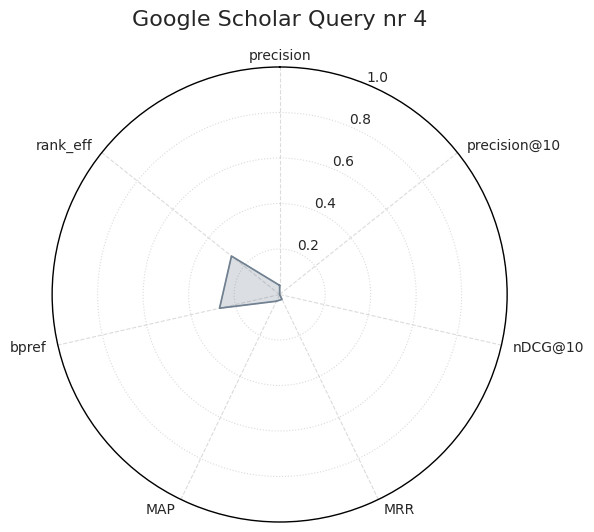

In [178]:
scholar_q4_results_fig = plot_ir_metrics_radar(scholar_q4_results_dct, title='Google Scholar Query nr 4')

## 2. Results Summarization

In [218]:
# List of query strings
queries_list = [bool_query_1, bool_query_2, bool_query_3, bool_query_4]

# List of result dictionaries
scopus_dicts_list = [elsevier_q1_results_dct, elsevier_q2_results_dct, elsevier_q3_results_dct, elsevier_q4_results_dct]
semantic_dicts_list = [semsch_q1_results_dct, semsch_q2_results_dct, semsch_q3_results_dct, semsch_q4_results_dct]
arxiv_dicts_list = [arxiv_q1_results_dct, arxiv_q2_results_dct, arxiv_q3_results_dct, arxiv_q4_results_dct]
scholar_dicts_list = [scholar_q1_results_dct, scholar_q2_results_dct, scholar_q3_results_dct, scholar_q4_results_dct]

all_results = [scopus_dicts_list, semantic_dicts_list, arxiv_dicts_list, scholar_dicts_list]

In [219]:
repos = ['Scopus', 'Semantic Scholar', 'arXiv', 'Google Scholar']
queries = ['Query 1', 'Query 2', 'Query 3', 'Query 4']

In [225]:
# Flatten and convert to a MultiIndex DataFrame
records = []
for repo_name, repo_results in zip(repos, all_results):
    for query_name, result_dict in zip(queries, repo_results):
        for metric, value in result_dict.items():
            if metric != 'experiment':
                records.append((repo_name, query_name, metric, value))

# Create a MultiIndex DataFrame
bool_experiment_metrics_df = pd.DataFrame(records, columns=['Repository', 'Query', 'Metric', 'Value'])
bool_experiment_metrics_df_pivot = bool_experiment_metrics_df.pivot_table(index=['Repository', 'Metric'], columns='Query', values='Value')


In [224]:
bool_experiment_metrics_df

,Repository,Query,Metric,Value
0,Scopus,Query 1,precision,0.250000
1,Scopus,Query 1,precision@10,0.300000
2,Scopus,Query 1,nDCG@10,0.643658
3,Scopus,Query 1,MRR,1.000000
4,Scopus,Query 1,MAP,0.498512
...,...,...,...,...
107,Google Scholar,Query 4,nDCG@10,0.000000
108,Google Scholar,Query 4,MRR,0.023810
109,Google Scholar,Query 4,MAP,0.032751
110,Google Scholar,Query 4,bpref,0.270833


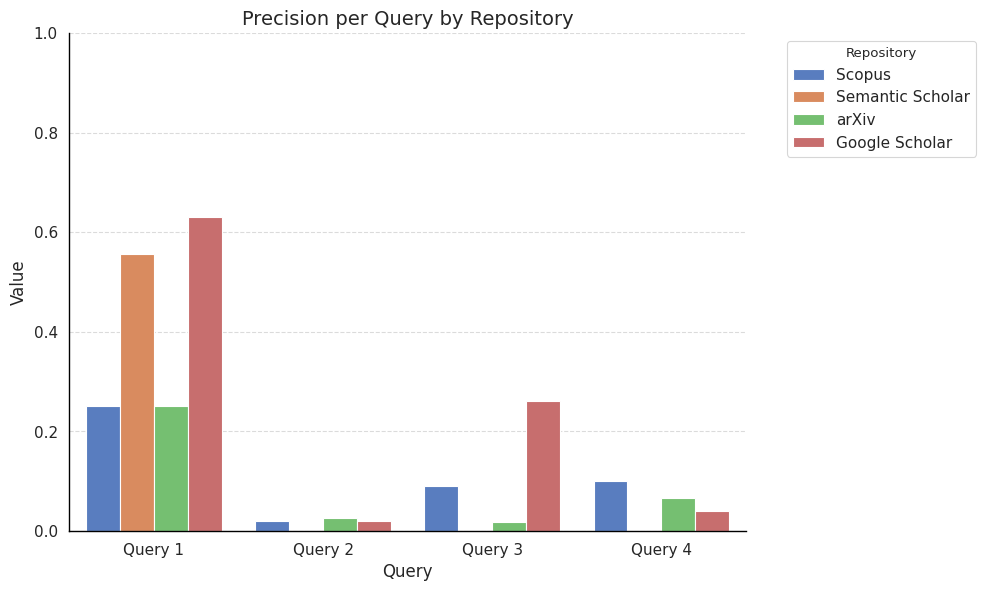

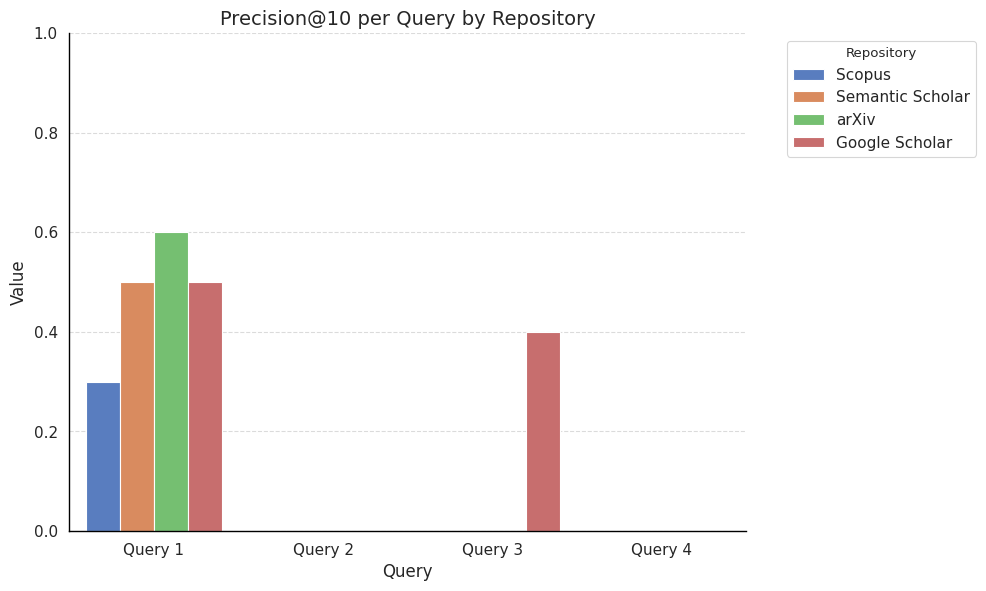

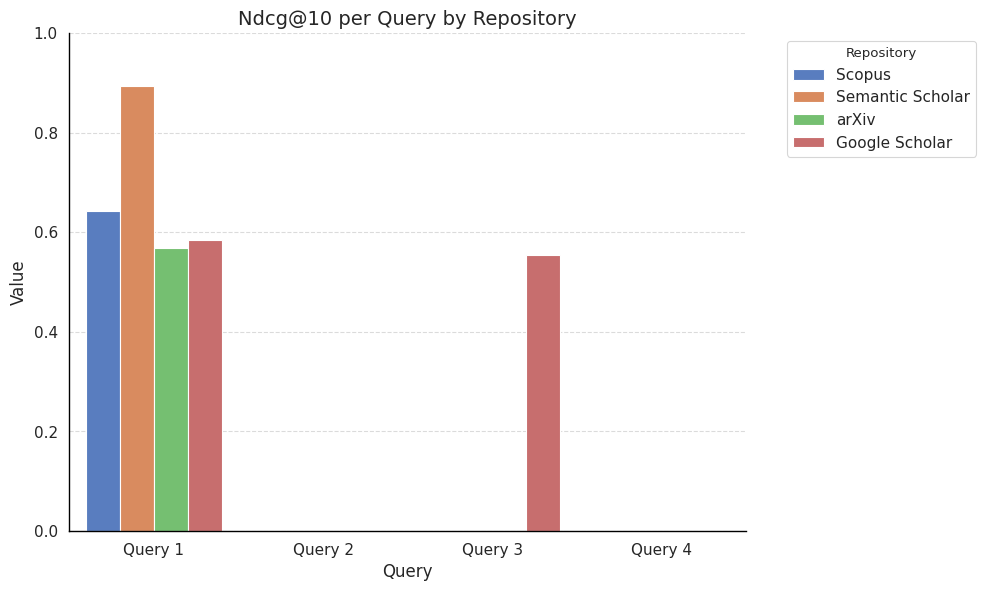

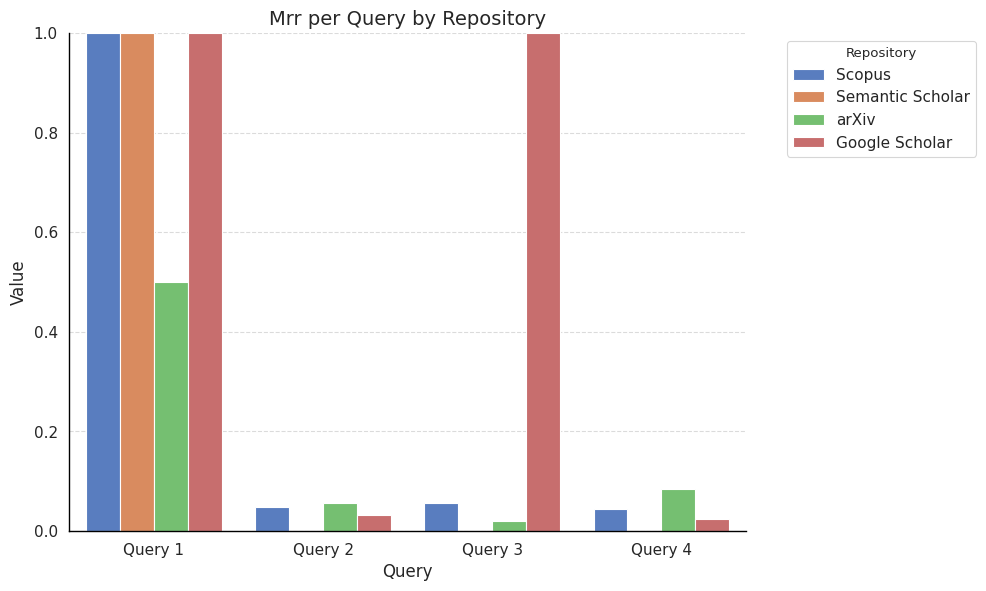

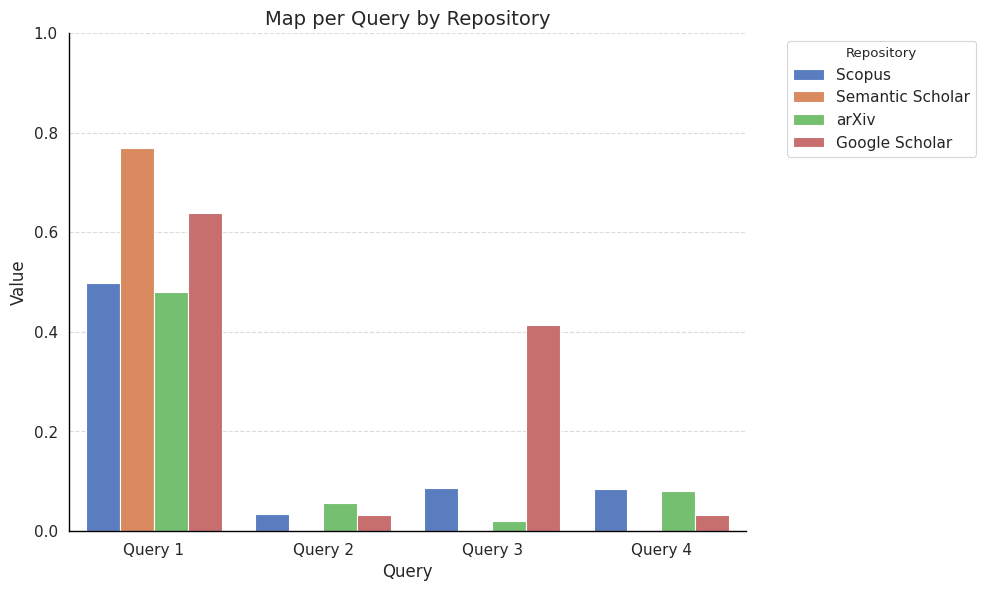

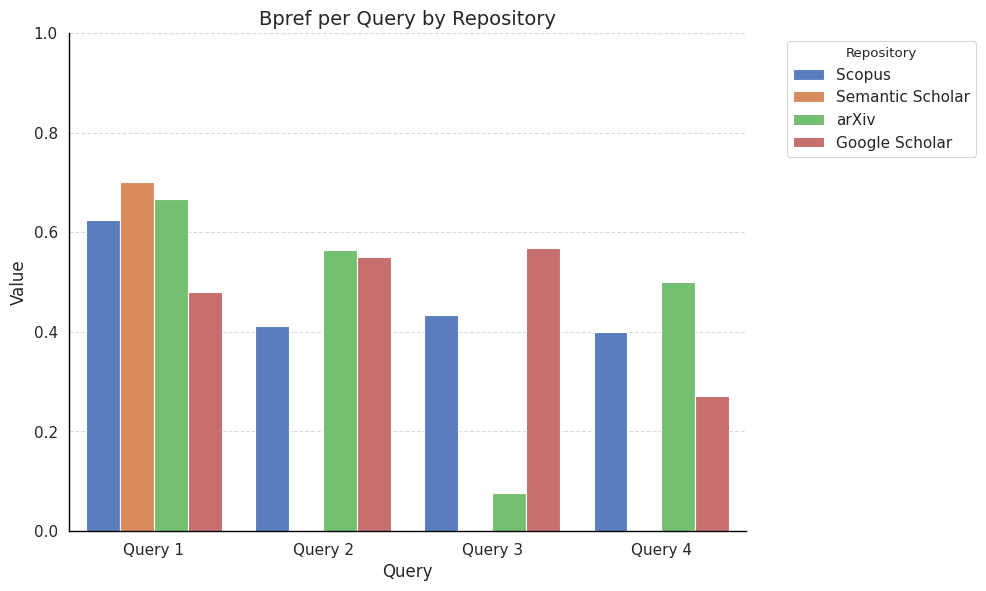

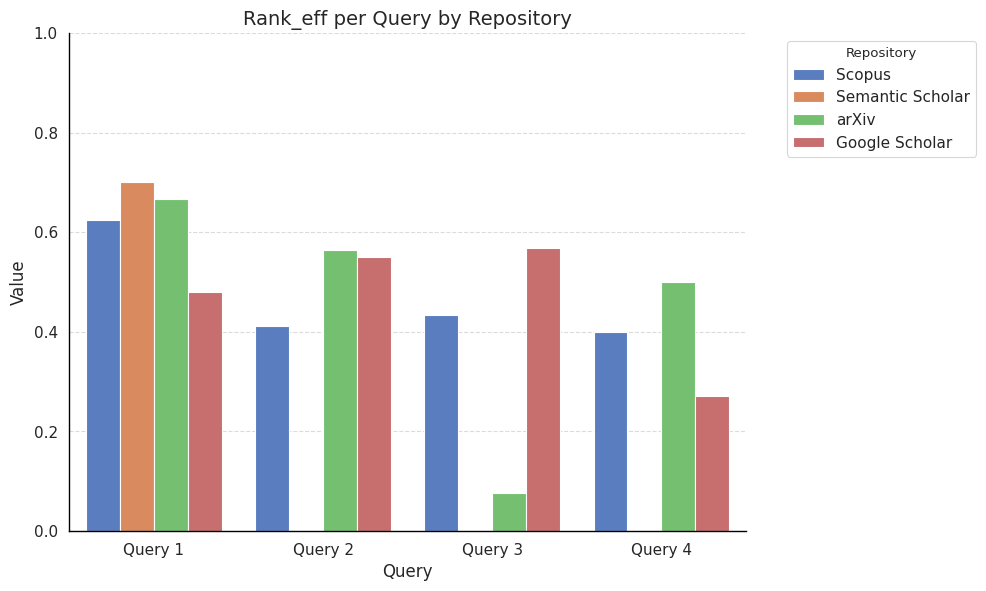

In [227]:
# Create one barplot per metric
metrics = bool_experiment_metrics_df['Metric'].unique()
for metric in metrics:
    plt.figure(figsize=(10, 6))
    subset = bool_experiment_metrics_df[bool_experiment_metrics_df['Metric'] == metric]
    sns.barplot(data=subset, x='Query', y='Value', hue='Repository')
    plt.title(f'{metric.capitalize()} per Query by Repository')
    plt.ylim(0, 1)
    plt.legend(title='Repository', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

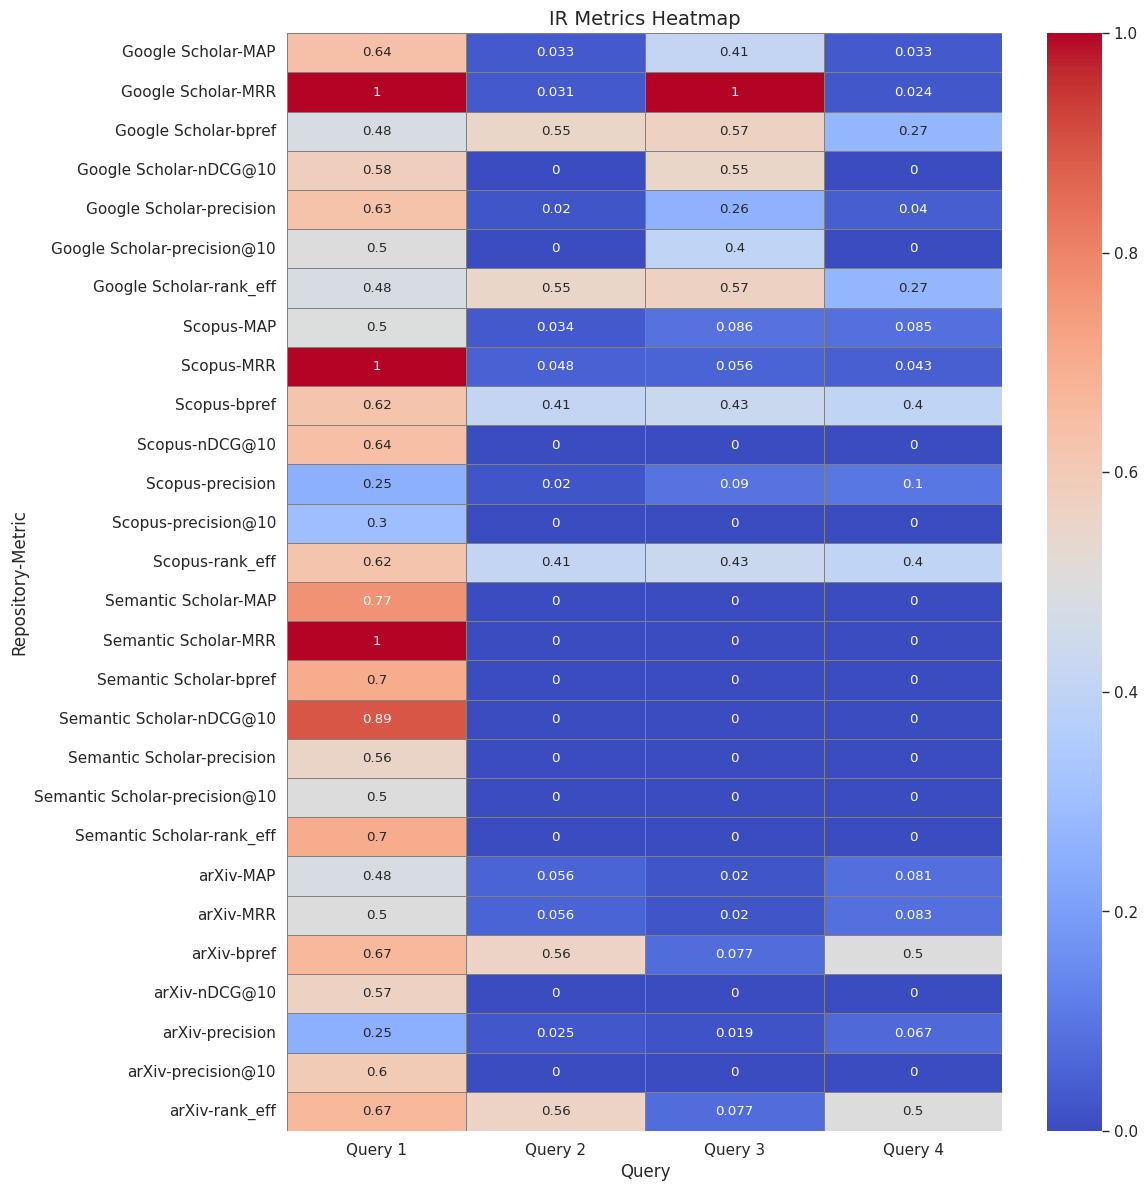

In [229]:
plt.figure(figsize=(12, 12))
sns.heatmap(bool_experiment_metrics_df_pivot, annot=True, cmap='coolwarm', vmin=0, vmax=1, linewidths=.5, linecolor='gray')
plt.title('IR Metrics Heatmap')
plt.tight_layout()
plt.show()